In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split , cross_val_score,KFold
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import warnings
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,Flatten,LSTM,Bidirectional
import keras
#from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.preprocessing.text import one_hot,Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from imblearn.over_sampling import SVMSMOTE
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
file = open("astralia-bedon-http-tekrar-balance.txt", "r", encoding='Latin-1')
content = file.read()
lines = content.split("\n")
# Create empty array for this groups:
# No need (0)
# Need    (1)
groups = np.zeros((len(lines), 1))
# Create empty matrix for
# injured medical
# live
# transmit
what_needed = np.zeros((len(lines), 3))
texts = []
for i in range(len(lines)):
  parts = lines[i].split("\t")
  group, *extra = parts[0].split(" ")[0]

  groups[i] = float(group)

  if (group == '1'):
    what_needed[i, 0] = '1' in extra  # injured
    what_needed[i, 1] = '2' in extra  # live
    what_needed[i, 0] = '3' in extra  # medical
    what_needed[i, 2] = '4' in extra  # transmit

  texts.append(parts[-1])

In [3]:
y1 = groups
y2 = what_needed
texts = np.array(texts)
df = pd.DataFrame(texts, columns = ['text'])
df['target']=y1
df['injured']=y2[:,0]
df['live']=y2[:,1]
#df['medical']=y2[:,2]
df['transmit']=y2[:,2]

In [5]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
!wget https://archive.org/download/glove.6B.50d-300d/glove.6B.100d.txt

--2023-06-29 06:54:34--  https://archive.org/download/glove.6B.50d-300d/glove.6B.100d.txt
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia903006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.100d.txt [following]
--2023-06-29 06:54:37--  https://ia903006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.100d.txt
Resolving ia903006.us.archive.org (ia903006.us.archive.org)... 207.241.233.16
Connecting to ia903006.us.archive.org (ia903006.us.archive.org)|207.241.233.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘glove.6B.100d.txt’

glove.6B.100d.txt   100%[===================>] 331.04M  2.99MB/s    in 1m 42s  

2023-06-29 06:56:19 (3.25 MB/s) - ‘glove.6B.100d.txt’ saved [347116733/347116733]



In [6]:
!pip install nlpaug

import nlpaug.augmenter.word as naw
from tqdm import tqdm
from sklearn.utils import shuffle
aug_glove = naw.WordEmbsAug(
    model_type='glove', model_path='glove.6B.100d.txt',
    action="substitute")
def augment_text(df,cl,samples=300,pr=0.1):
    aug_glove.aug_p=pr
    new_text=[]
    t21=[]
    t22=[]
    t23=[]
    ##selecting the minority class samples
    df_n=df[df.target==cl].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):

            text = df_n.iloc[i]['text']
            t21.append(df_n.iloc[i]['injured'])
            t22.append(df_n.iloc[i]['live'])
            t23.append(df_n.iloc[i]['transmit'])
            augmented_text = aug_glove.augment(text)[0]
            new_text.append(augmented_text)


    ## dataframe
    new=pd.DataFrame({'text':new_text,'target':cl,'injured':t21,'live':t22,'transmit':t23})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

df2 = augment_text(df,0,samples=110)
df2 = augment_text(df2,1,samples=152)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.1 MB/s eta 0:00:00


100%|██████████| 152/152 [00:41<00:00,  3.63it/s]


In [7]:
y1=df['target']

In [8]:
def clean1(review1):
    descrip = re.sub('[^a-zA-Z]', ' ', review1)
    review1 = descrip.lower()
    return review1

df['text_Cleaned'] = pd.DataFrame(df['text'].apply(lambda y: clean1(y)))
df.head()

text  target  injured  live  \
0  WARNING - RIVERINE FLOOD  Incident Location: T...     0.0      0.0   0.0   
1  @electricfuture5 Stay safe. Flood waters hit t...     0.0      0.0   0.0   
2  RT @vicsesnews: Flood - Safe to Return for Tra...     0.0      0.0   0.0   
3  Evacuation order has now been lifted. Safe for...     0.0      0.0   0.0   
4  BOM has just downgraded flood warning for Trar...     1.0      0.0   0.0   

   transmit                                       text_Cleaned  
0       0.0  warning   riverine flood  incident location  t...  
1       0.0   electricfuture  stay safe  flood waters hit t...  
2       0.0  rt  vicsesnews  flood   safe to return for tra...  
3       0.0  evacuation order has now been lifted  safe for...  
4       1.0  bom has just downgraded flood warning for trar...

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
df['text_Cleaned'].replace('[@+]', "", regex=True,inplace=True)
df['text_Cleaned'].replace('[()]', "", regex=True,inplace=True)
df['text_Cleaned']= df['text_Cleaned'].replace('[#+]', "", regex=True)
url_regex = "((https?):((//)|(\\\\))+[\w\d:#@%/;$()~_?\+-=\\\.&]*)"
df['text_Cleaned'] = df['text_Cleaned'].replace(url_regex, "", regex=True)
df['text_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df['text_Cleaned']]
text_new=[]
for each_row in df['text_Cleaned']:
    text_new.append([i for i in each_row if i.isalpha()])
stop_words = set(stopwords.words('english'))
text_new_alpha=[]
for each_row in text_new:
    text_new_alpha.append([i for i in each_row if i not in stop_words])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
nltk.download('wordnet')
text_new_lemma = []
lemma = nltk.WordNetLemmatizer()
for each_row in text_new_alpha:
    text_new_lemma.append([lemma.lemmatize(word) for word in each_row])
df['text_Cleaned'] = text_new_lemma
df['text_Cleaned'] = [" ".join(desc) for desc in df['text_Cleaned'].values]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
def show_confusion_ROC(label,pred_label,nm):
    class_names=['NO Need','Need']
    cm=confusion_matrix(label,pred_label)
    disp =ConfusionMatrixDisplay(cm,display_labels=class_names)
    disp.plot()
    plt.title(f'Confusion Matrix {nm}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    fpr, tpr, thresholds = metrics.roc_curve(label, pred_label)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=nm)
    display.plot()
def mymetrics(Y,P , alg = None):
    cm =confusion_matrix(Y,P)
    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    recall= TP/(TP+FN)
    # acc1= TP+TN/len(P)
    acc2= (TP+TN)/(TN+TP+FN+FP)
    # print(acc1 == acc2)
    precision= TP/(TP+FP)
    FAR= FP/(FP+TN)
    Fmeasure = 2*((precision*recall)/(precision+recall))
    print(f"accuracy = {acc2*100}")
    print(f'recall= {recall*100}')
    print(f'precision= {precision*100}')
    print(f'FAR= {FAR*100}')
    print(f'Fmeasure= {Fmeasure*100}')
def precRecall(Y,P):
    cm =confusion_matrix(Y,P)
    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    precision= TP/(TP+FP)
    recall= TP/(TP+FN)
    return precision,recall

In [12]:
len(text_new_lemma)

450

-----------------LSTM with GLOVE-------------------------------
Training for fold 1 ...
Epoch 1/20
13/13 [==============================] - 13s 394ms/step - loss: 0.6884 - accuracy: 0.5407 - val_loss: 0.6812 - val_accuracy: 0.6444
Epoch 2/20
13/13 [==============================] - 3s 227ms/step - loss: 0.6687 - accuracy: 0.7111 - val_loss: 0.6732 - val_accuracy: 0.7111
Epoch 3/20
13/13 [==============================] - 1s 117ms/step - loss: 0.6524 - accuracy: 0.7333 - val_loss: 0.6593 - val_accuracy: 0.6889
Epoch 4/20
13/13 [==============================] - 3s 237ms/step - loss: 0.6287 - accuracy: 0.7827 - val_loss: 0.6358 - val_accuracy: 0.7333
Epoch 5/20
13/13 [==============================] - 3s 213ms/step - loss: 0.6037 - accuracy: 0.7901 - val_loss: 0.6019 - val_accuracy: 0.7333
Epoch 6/20
13/13 [==============================] - 4s 306ms/step - loss: 0.5568 - accuracy: 0.8395 - val_loss: 0.5576 - val_accuracy: 0.7556
Epoch 7/20
13/13 [==============================] - 2s 120m

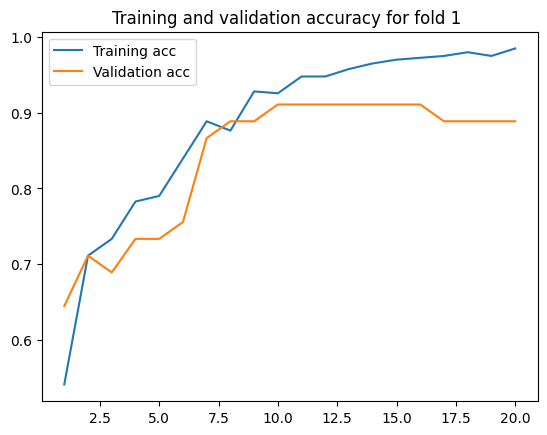

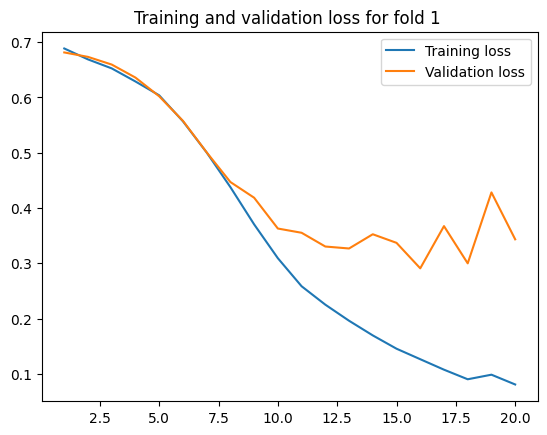

13/13 [==============================] - 1s 59ms/step
===== : TRAIN for fold 2 : =====
accuracy = 98.27160493827161
recall= 99.11111111111111
precision= 97.80701754385966
FAR= 2.7777777777777777
Fmeasure= 98.45474613686534


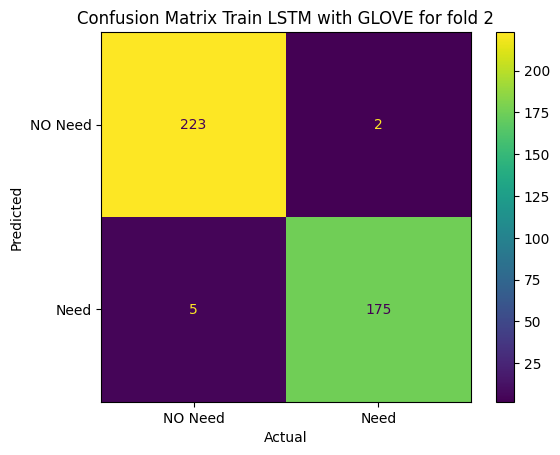

2/2 [==============================] - 0s 16ms/step
===== : TEST for fold 2 : =====
accuracy = 88.88888888888889
recall= 88.46153846153845
precision= 92.0
FAR= 10.526315789473683
Fmeasure= 90.19607843137256


<Figure size 640x480 with 0 Axes>

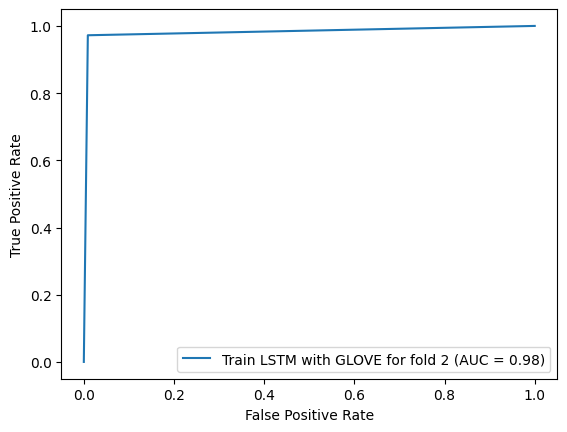

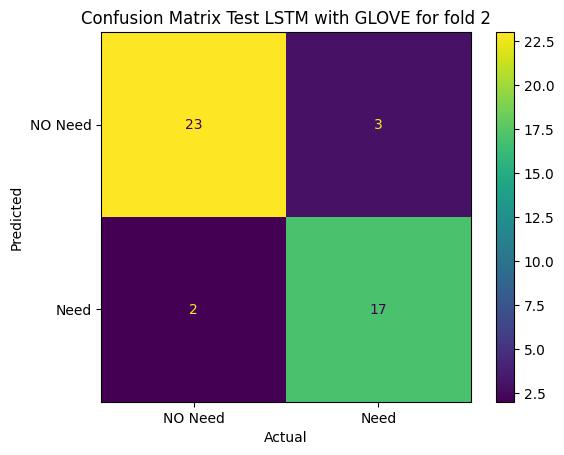

-----------------LSTM with GLOVE-------------------------------
Training for fold 2 ...
Epoch 1/20
13/13 [==============================] - 10s 174ms/step - loss: 0.6939 - accuracy: 0.5580 - val_loss: 0.6860 - val_accuracy: 0.5111
Epoch 2/20
13/13 [==============================] - 3s 231ms/step - loss: 0.6658 - accuracy: 0.6123 - val_loss: 0.6722 - val_accuracy: 0.5333
Epoch 3/20
13/13 [==============================] - 5s 388ms/step - loss: 0.6487 - accuracy: 0.6593 - val_loss: 0.6562 - val_accuracy: 0.6222
Epoch 4/20
13/13 [==============================] - 1s 110ms/step - loss: 0.6216 - accuracy: 0.7012 - val_loss: 0.6371 - val_accuracy: 0.7111
Epoch 5/20
13/13 [==============================] - 3s 247ms/step - loss: 0.6007 - accuracy: 0.7309 - val_loss: 0.6051 - val_accuracy: 0.7333
Epoch 6/20
13/13 [==============================] - 4s 309ms/step - loss: 0.5513 - accuracy: 0.7506 - val_loss: 0.5413 - val_accuracy: 0.7556
Epoch 7/20
13/13 [==============================] - 4s 340m

<Figure size 640x480 with 0 Axes>

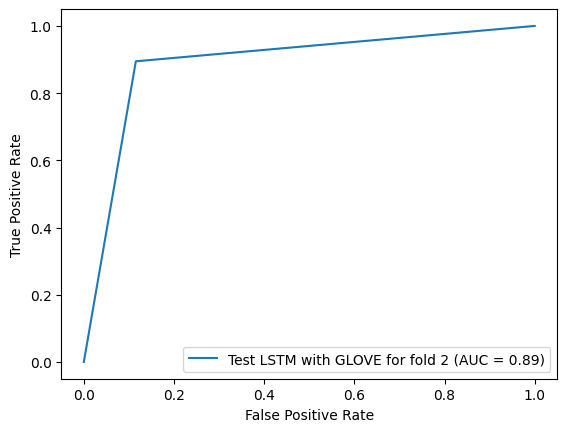

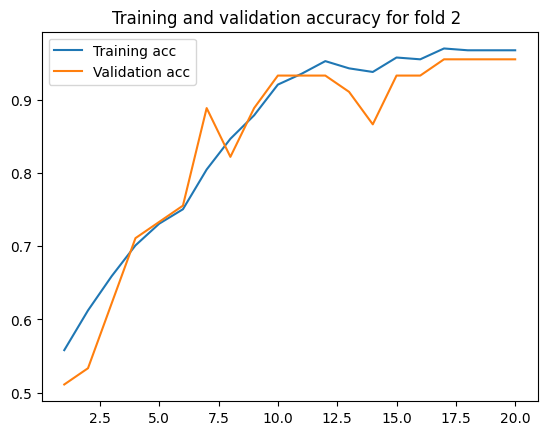

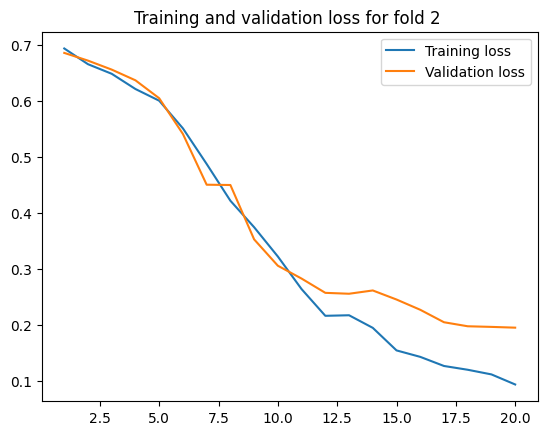

13/13 [==============================] - 1s 43ms/step
===== : TRAIN for fold 3 : =====
accuracy = 98.51851851851852
recall= 99.12280701754386
precision= 98.26086956521739
FAR= 2.2598870056497176
Fmeasure= 98.68995633187774


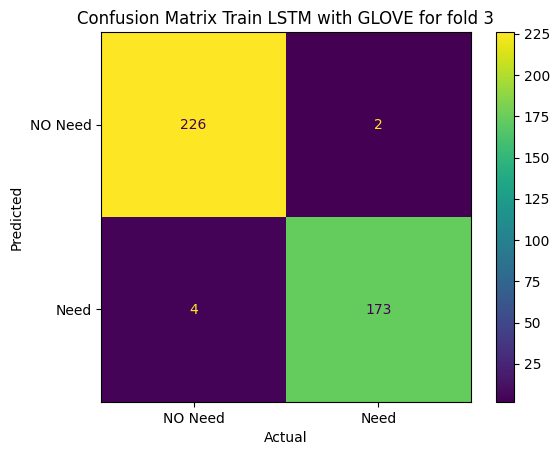

2/2 [==============================] - 0s 18ms/step
===== : TEST for fold 3 : =====
accuracy = 95.55555555555556
recall= 91.30434782608695
precision= 100.0
FAR= 0.0
Fmeasure= 95.45454545454545


<Figure size 640x480 with 0 Axes>

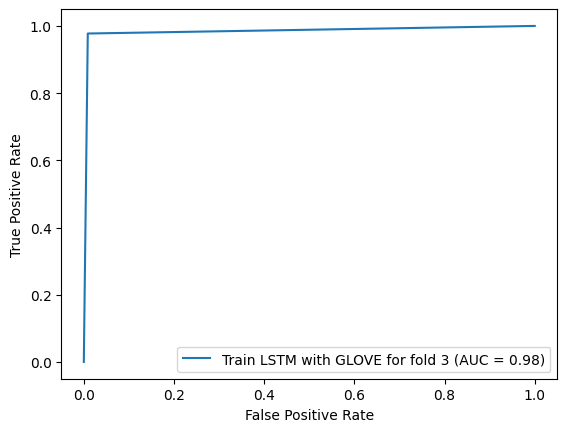

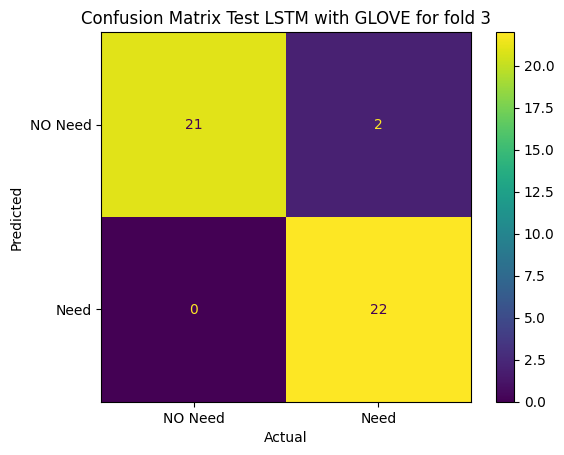

-----------------LSTM with GLOVE-------------------------------
Training for fold 3 ...
Epoch 1/20
13/13 [==============================] - 11s 232ms/step - loss: 0.6446 - accuracy: 0.6568 - val_loss: 0.5941 - val_accuracy: 0.7556
Epoch 2/20
13/13 [==============================] - 3s 218ms/step - loss: 0.6072 - accuracy: 0.6815 - val_loss: 0.5654 - val_accuracy: 0.7333
Epoch 3/20
13/13 [==============================] - 3s 258ms/step - loss: 0.5701 - accuracy: 0.7358 - val_loss: 0.5423 - val_accuracy: 0.7333
Epoch 4/20
13/13 [==============================] - 3s 268ms/step - loss: 0.5326 - accuracy: 0.7432 - val_loss: 0.5020 - val_accuracy: 0.7778
Epoch 5/20
13/13 [==============================] - 4s 311ms/step - loss: 0.5060 - accuracy: 0.7531 - val_loss: 0.4748 - val_accuracy: 0.7556
Epoch 6/20
13/13 [==============================] - 1s 105ms/step - loss: 0.4471 - accuracy: 0.8025 - val_loss: 0.4423 - val_accuracy: 0.8000
Epoch 7/20
13/13 [==============================] - 2s 168m

<Figure size 640x480 with 0 Axes>

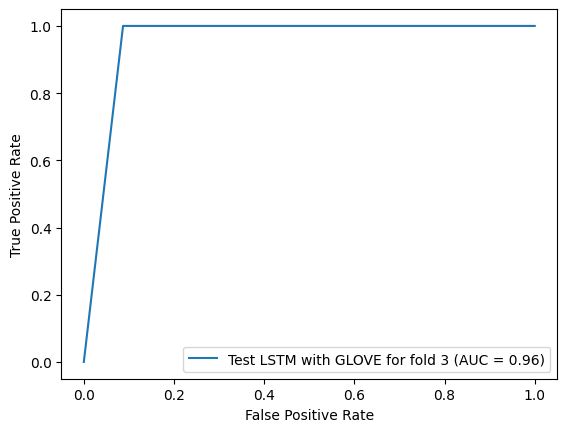

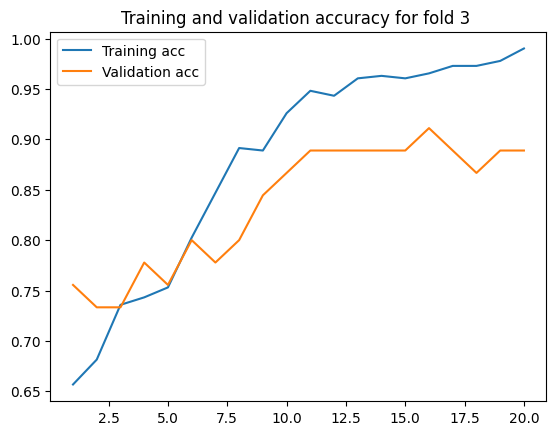

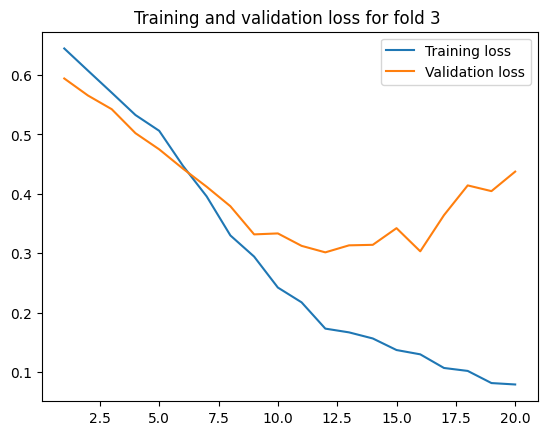

13/13 [==============================] - 1s 12ms/step
===== : TRAIN for fold 4 : =====
accuracy = 99.50617283950616
recall= 100.0
precision= 99.11111111111111
FAR= 1.098901098901099
Fmeasure= 99.55357142857144


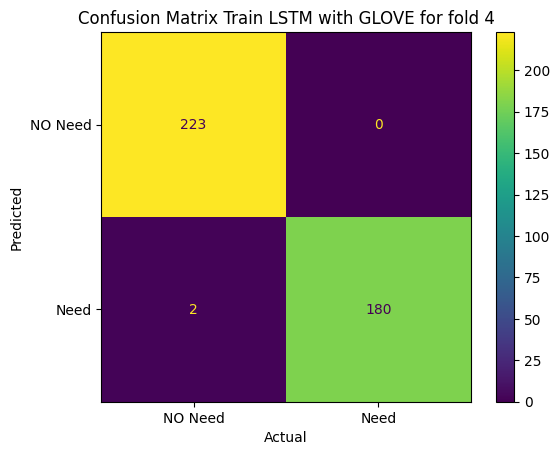

2/2 [==============================] - 1s 834ms/step
===== : TEST for fold 4 : =====
accuracy = 88.88888888888889
recall= 85.71428571428571
precision= 96.0
FAR= 5.88235294117647
Fmeasure= 90.56603773584904


<Figure size 640x480 with 0 Axes>

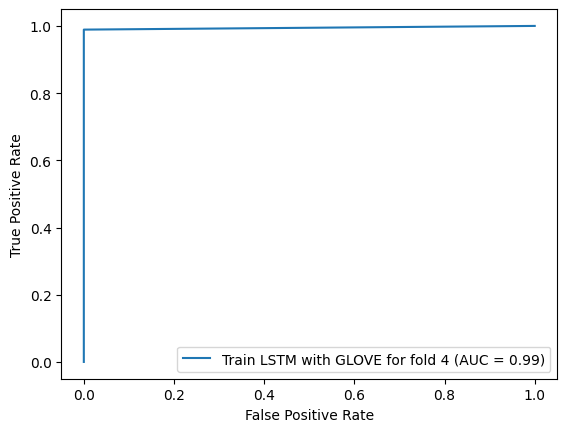

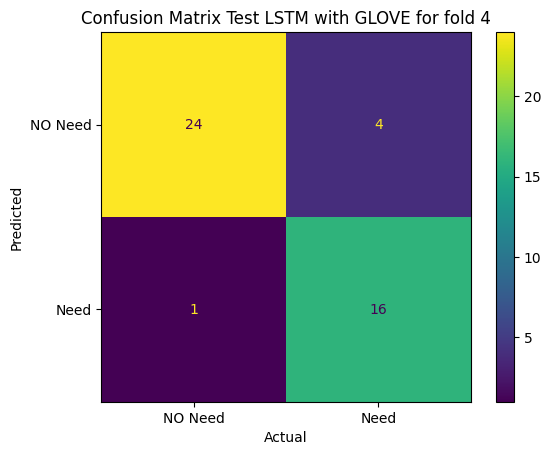

-----------------LSTM with GLOVE-------------------------------
Training for fold 4 ...
Epoch 1/20
13/13 [==============================] - 12s 234ms/step - loss: 0.6951 - accuracy: 0.4444 - val_loss: 0.6868 - val_accuracy: 0.5556
Epoch 2/20
13/13 [==============================] - 2s 183ms/step - loss: 0.6831 - accuracy: 0.6296 - val_loss: 0.6744 - val_accuracy: 0.6222
Epoch 3/20
13/13 [==============================] - 2s 119ms/step - loss: 0.6523 - accuracy: 0.6741 - val_loss: 0.6565 - val_accuracy: 0.6889
Epoch 4/20
13/13 [==============================] - 6s 461ms/step - loss: 0.6258 - accuracy: 0.7185 - val_loss: 0.6308 - val_accuracy: 0.6889
Epoch 5/20
13/13 [==============================] - 4s 312ms/step - loss: 0.5854 - accuracy: 0.7605 - val_loss: 0.5884 - val_accuracy: 0.7333
Epoch 6/20
13/13 [==============================] - 3s 257ms/step - loss: 0.5445 - accuracy: 0.7951 - val_loss: 0.5398 - val_accuracy: 0.8667
Epoch 7/20
13/13 [==============================] - 5s 407m

<Figure size 640x480 with 0 Axes>

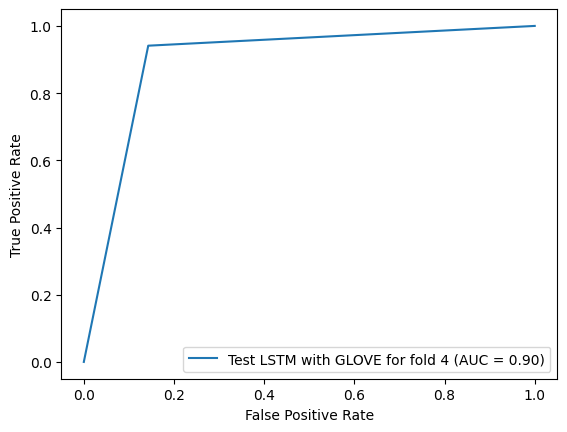

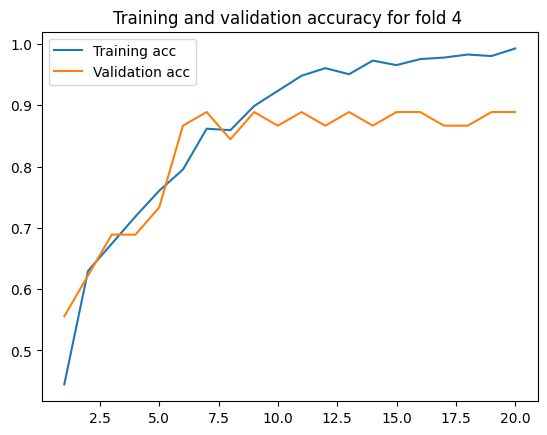

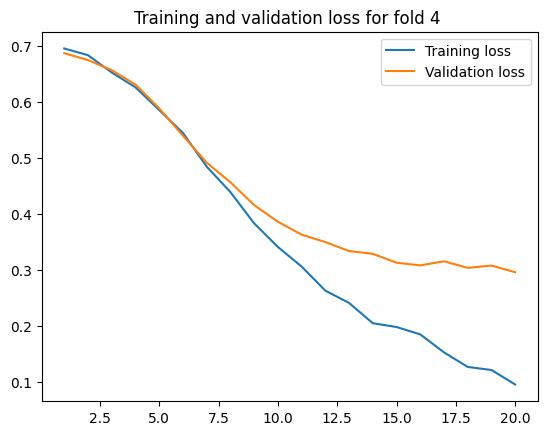

13/13 [==============================] - 1s 60ms/step
===== : TRAIN for fold 5 : =====
accuracy = 98.51851851851852
recall= 98.2532751091703
precision= 99.11894273127754
FAR= 1.1363636363636365
Fmeasure= 98.6842105263158


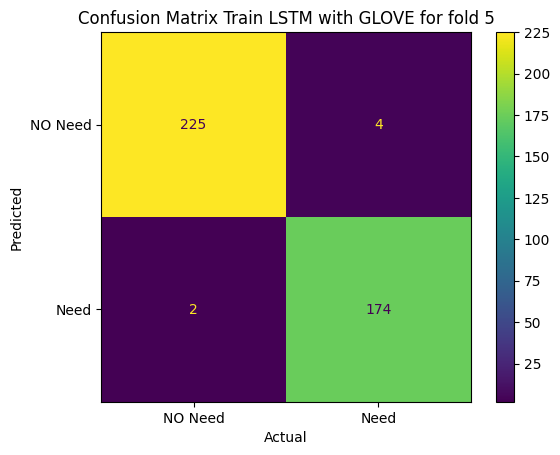

2/2 [==============================] - 0s 19ms/step
===== : TEST for fold 5 : =====
accuracy = 88.88888888888889
recall= 86.36363636363636
precision= 90.47619047619048
FAR= 8.695652173913043
Fmeasure= 88.37209302325581


<Figure size 640x480 with 0 Axes>

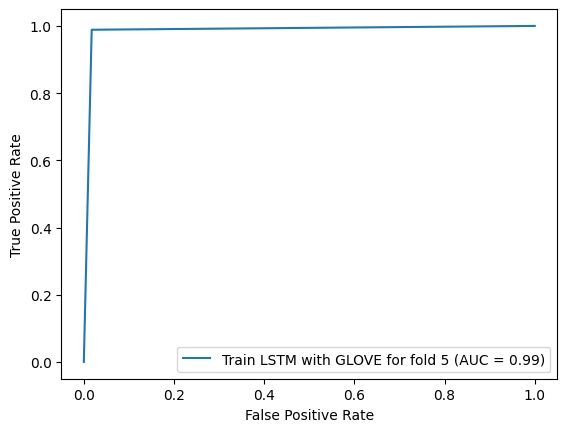

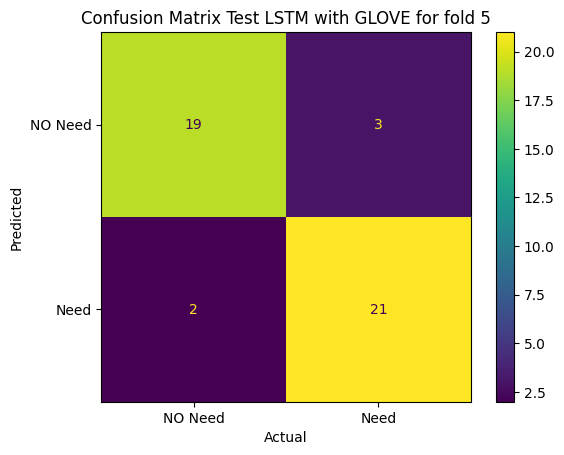

-----------------LSTM with GLOVE-------------------------------
Training for fold 5 ...
Epoch 1/20
13/13 [==============================] - 12s 293ms/step - loss: 0.6823 - accuracy: 0.5605 - val_loss: 0.6403 - val_accuracy: 0.6222
Epoch 2/20
13/13 [==============================] - 3s 262ms/step - loss: 0.6510 - accuracy: 0.6148 - val_loss: 0.6014 - val_accuracy: 0.7333
Epoch 3/20
13/13 [==============================] - 5s 388ms/step - loss: 0.6217 - accuracy: 0.6914 - val_loss: 0.5665 - val_accuracy: 0.7778
Epoch 4/20
13/13 [==============================] - 4s 305ms/step - loss: 0.5927 - accuracy: 0.7136 - val_loss: 0.5245 - val_accuracy: 0.8889
Epoch 5/20
13/13 [==============================] - 3s 255ms/step - loss: 0.5502 - accuracy: 0.7827 - val_loss: 0.4705 - val_accuracy: 0.9111
Epoch 6/20
13/13 [==============================] - 5s 443ms/step - loss: 0.4942 - accuracy: 0.8099 - val_loss: 0.4098 - val_accuracy: 0.9556
Epoch 7/20
13/13 [==============================] - 2s 194m

<Figure size 640x480 with 0 Axes>

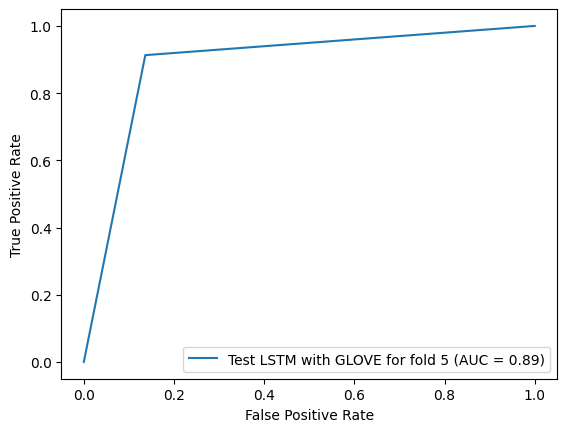

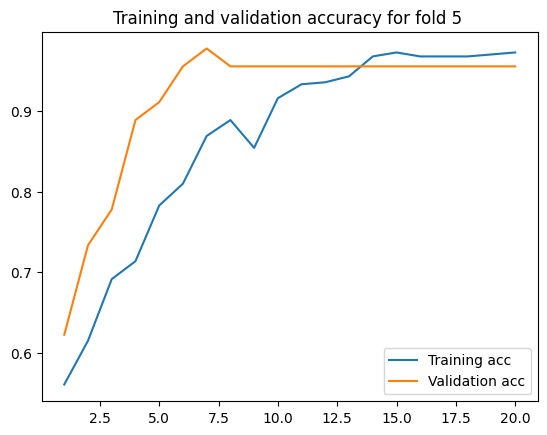

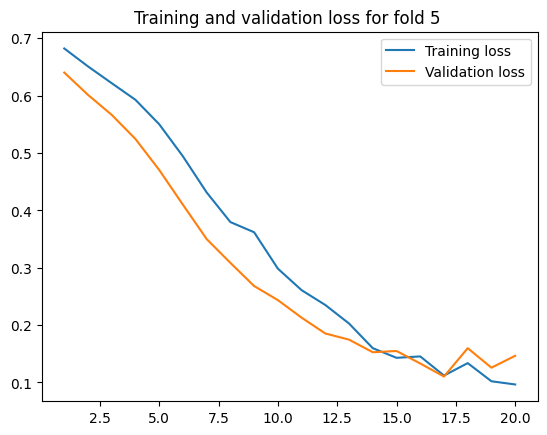

13/13 [==============================] - 1s 56ms/step
===== : TRAIN for fold 6 : =====
accuracy = 98.27160493827161
recall= 99.11111111111111
precision= 97.80701754385966
FAR= 2.7777777777777777
Fmeasure= 98.45474613686534


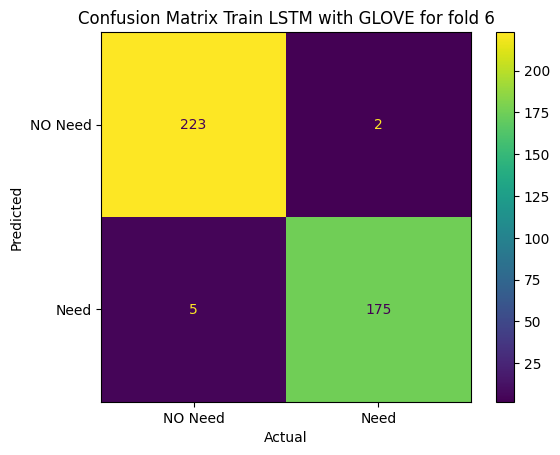

2/2 [==============================] - 0s 26ms/step
===== : TEST for fold 6 : =====
accuracy = 95.55555555555556
recall= 92.3076923076923
precision= 100.0
FAR= 0.0
Fmeasure= 96.00000000000001


<Figure size 640x480 with 0 Axes>

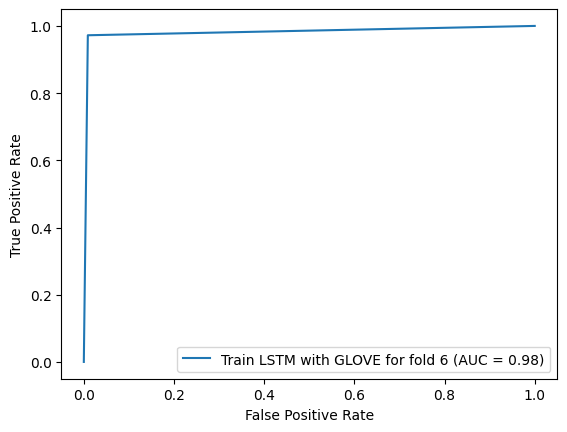

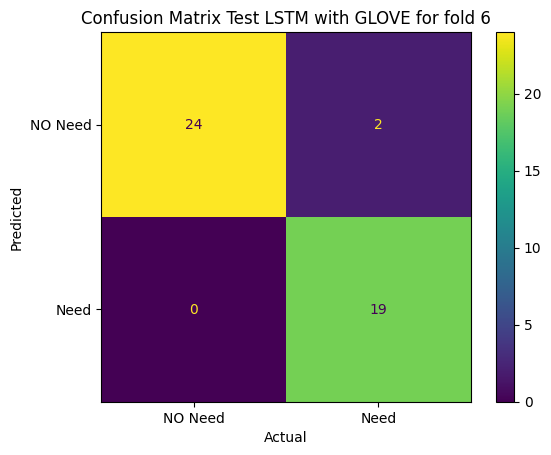

-----------------LSTM with GLOVE-------------------------------
Training for fold 6 ...
Epoch 1/20
13/13 [==============================] - 11s 279ms/step - loss: 0.6957 - accuracy: 0.4790 - val_loss: 0.6947 - val_accuracy: 0.4889
Epoch 2/20
13/13 [==============================] - 3s 244ms/step - loss: 0.6910 - accuracy: 0.5778 - val_loss: 0.6941 - val_accuracy: 0.4889
Epoch 3/20
13/13 [==============================] - 4s 314ms/step - loss: 0.6882 - accuracy: 0.6000 - val_loss: 0.6911 - val_accuracy: 0.5778
Epoch 4/20
13/13 [==============================] - 3s 255ms/step - loss: 0.6769 - accuracy: 0.6642 - val_loss: 0.6659 - val_accuracy: 0.8000
Epoch 5/20
13/13 [==============================] - 4s 295ms/step - loss: 0.6531 - accuracy: 0.7235 - val_loss: 0.6315 - val_accuracy: 0.8222
Epoch 6/20
13/13 [==============================] - 4s 310ms/step - loss: 0.6305 - accuracy: 0.7407 - val_loss: 0.6042 - val_accuracy: 0.8444
Epoch 7/20
13/13 [==============================] - 3s 239m

<Figure size 640x480 with 0 Axes>

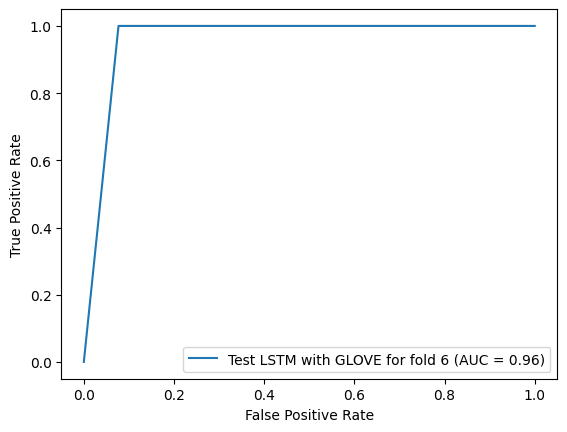

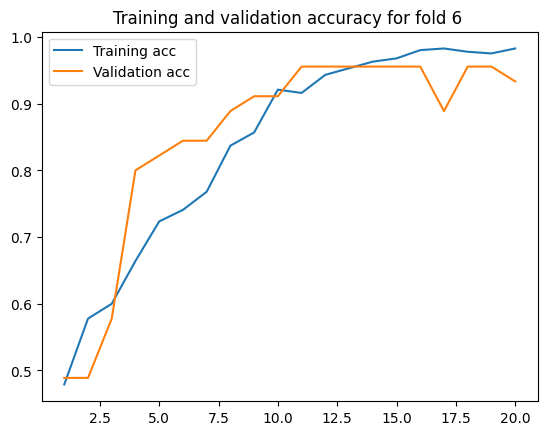

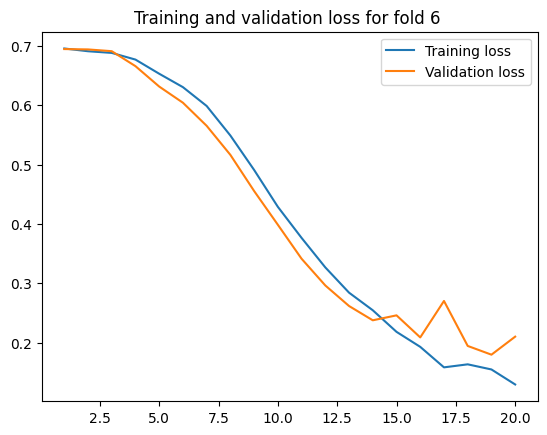

13/13 [==============================] - 1s 13ms/step
===== : TRAIN for fold 7 : =====
accuracy = 99.50617283950616
recall= 99.56331877729258
precision= 99.56331877729258
FAR= 0.5681818181818182
Fmeasure= 99.56331877729258


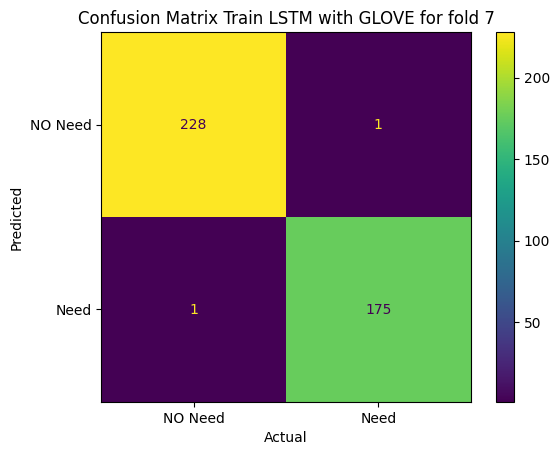

2/2 [==============================] - 1s 758ms/step
===== : TEST for fold 7 : =====
accuracy = 93.33333333333333
recall= 90.9090909090909
precision= 95.23809523809523
FAR= 4.3478260869565215
Fmeasure= 93.02325581395348


<Figure size 640x480 with 0 Axes>

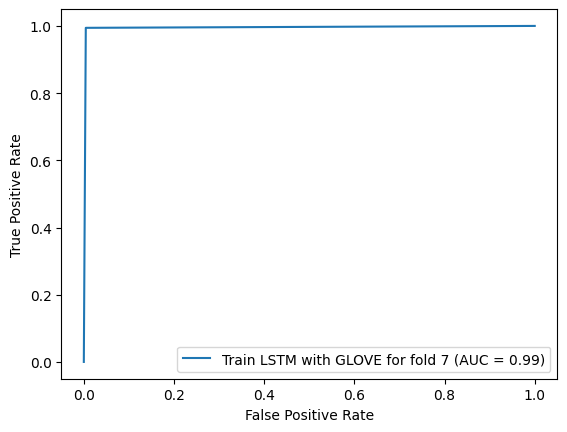

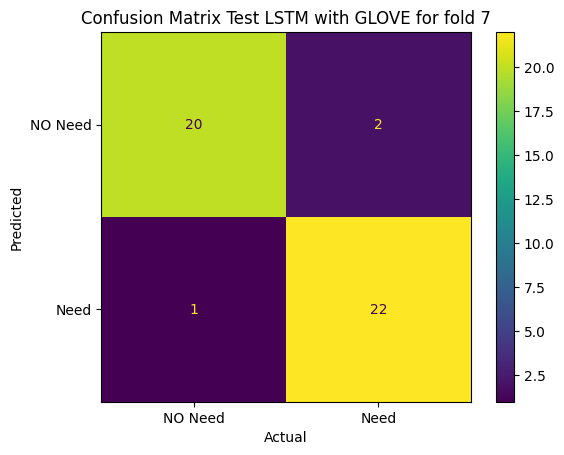

-----------------LSTM with GLOVE-------------------------------
Training for fold 7 ...
Epoch 1/20
13/13 [==============================] - 13s 464ms/step - loss: 0.6845 - accuracy: 0.6296 - val_loss: 0.6692 - val_accuracy: 0.7333
Epoch 2/20
13/13 [==============================] - 3s 243ms/step - loss: 0.6482 - accuracy: 0.7432 - val_loss: 0.6535 - val_accuracy: 0.7111
Epoch 3/20
13/13 [==============================] - 3s 250ms/step - loss: 0.6136 - accuracy: 0.7457 - val_loss: 0.6271 - val_accuracy: 0.7111
Epoch 4/20
13/13 [==============================] - 4s 362ms/step - loss: 0.5699 - accuracy: 0.7877 - val_loss: 0.5837 - val_accuracy: 0.7778
Epoch 5/20
13/13 [==============================] - 4s 286ms/step - loss: 0.5146 - accuracy: 0.8272 - val_loss: 0.5350 - val_accuracy: 0.8000
Epoch 6/20
13/13 [==============================] - 3s 254ms/step - loss: 0.4666 - accuracy: 0.8765 - val_loss: 0.4867 - val_accuracy: 0.8222
Epoch 7/20
13/13 [==============================] - 4s 343m

<Figure size 640x480 with 0 Axes>

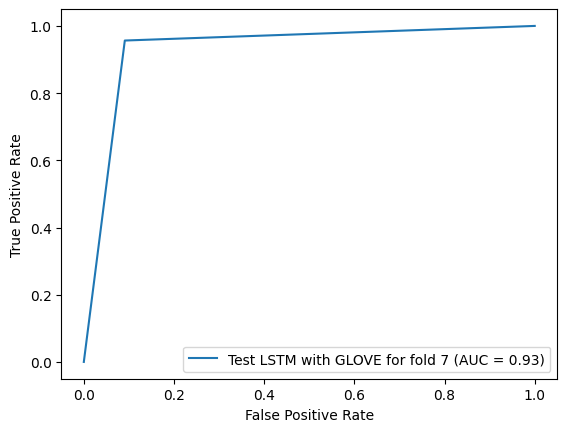

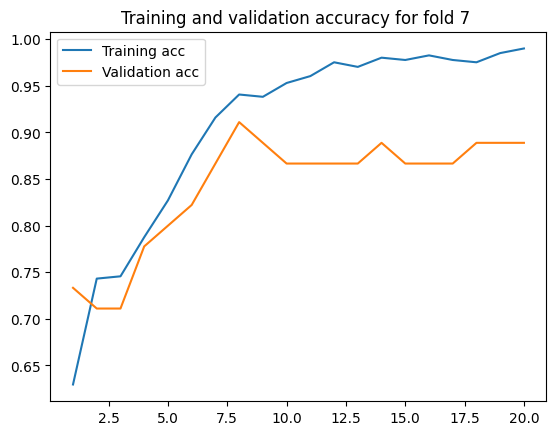

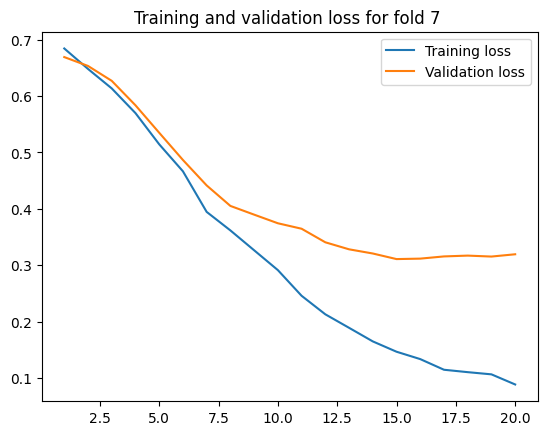

13/13 [==============================] - 2s 89ms/step
===== : TRAIN for fold 8 : =====
accuracy = 99.25925925925925
recall= 100.0
precision= 98.7012987012987
FAR= 1.694915254237288
Fmeasure= 99.34640522875817


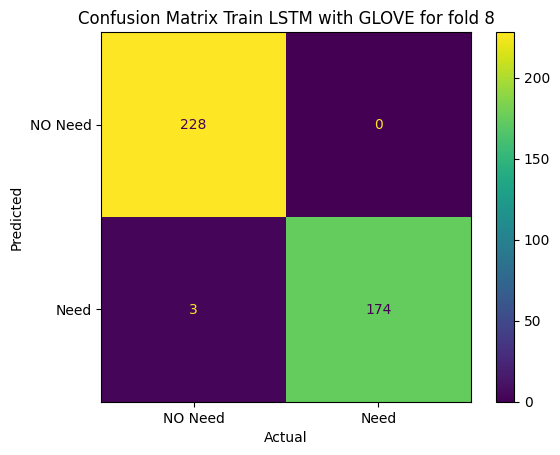

2/2 [==============================] - 0s 15ms/step
===== : TEST for fold 8 : =====
accuracy = 88.88888888888889
recall= 91.30434782608695
precision= 87.5
FAR= 13.636363636363635
Fmeasure= 89.36170212765957


<Figure size 640x480 with 0 Axes>

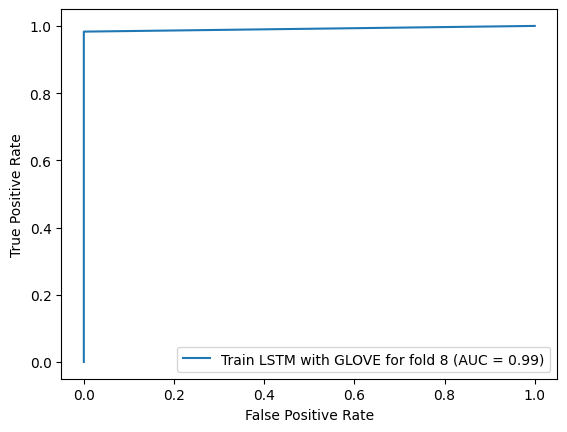

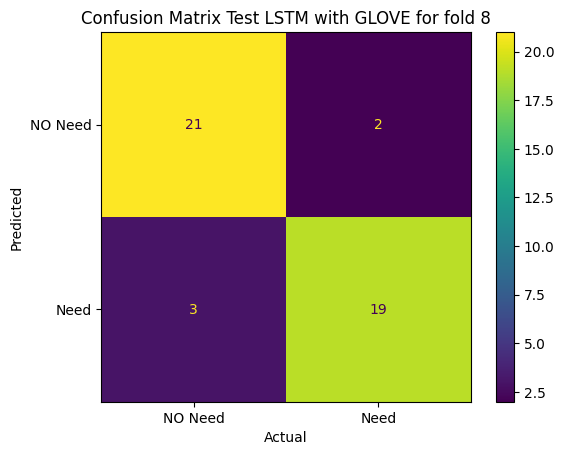

-----------------LSTM with GLOVE-------------------------------
Training for fold 8 ...
Epoch 1/20
13/13 [==============================] - 13s 450ms/step - loss: 0.6999 - accuracy: 0.5160 - val_loss: 0.6643 - val_accuracy: 0.7556
Epoch 2/20
13/13 [==============================] - 2s 177ms/step - loss: 0.6644 - accuracy: 0.5926 - val_loss: 0.6206 - val_accuracy: 0.6667
Epoch 3/20
13/13 [==============================] - 3s 254ms/step - loss: 0.6408 - accuracy: 0.6370 - val_loss: 0.5855 - val_accuracy: 0.7111
Epoch 4/20
13/13 [==============================] - 3s 227ms/step - loss: 0.6111 - accuracy: 0.6988 - val_loss: 0.5595 - val_accuracy: 0.7778
Epoch 5/20
13/13 [==============================] - 3s 246ms/step - loss: 0.5901 - accuracy: 0.7481 - val_loss: 0.5298 - val_accuracy: 0.7778
Epoch 6/20
13/13 [==============================] - 4s 308ms/step - loss: 0.5592 - accuracy: 0.7753 - val_loss: 0.5083 - val_accuracy: 0.7778
Epoch 7/20
13/13 [==============================] - 4s 290m

<Figure size 640x480 with 0 Axes>

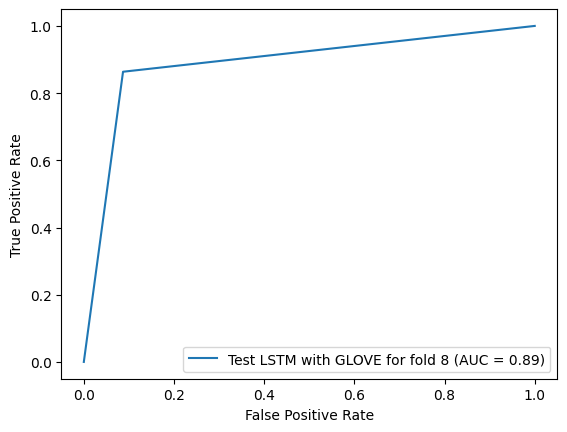

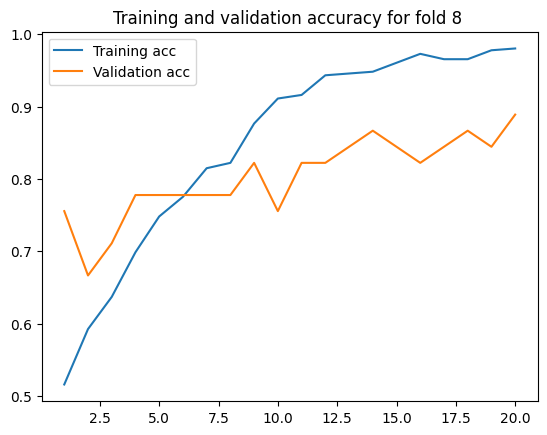

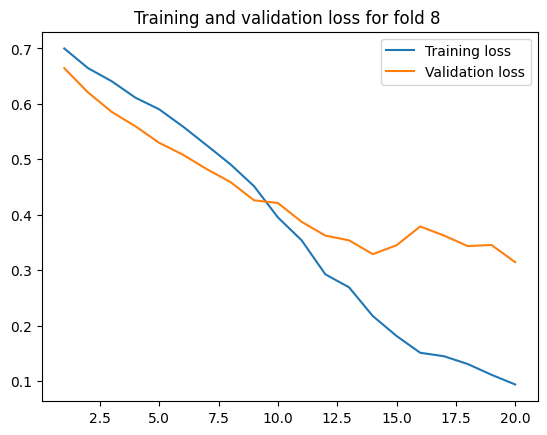

13/13 [==============================] - 1s 65ms/step
===== : TRAIN for fold 9 : =====
accuracy = 99.25925925925925
recall= 99.08675799086758
precision= 99.54128440366972
FAR= 0.5376344086021506
Fmeasure= 99.31350114416475


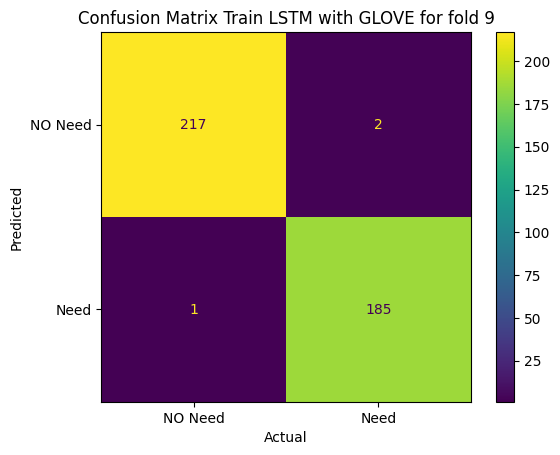

2/2 [==============================] - 0s 19ms/step
===== : TEST for fold 9 : =====
accuracy = 88.88888888888889
recall= 87.5
precision= 96.55172413793103
FAR= 7.6923076923076925
Fmeasure= 91.80327868852459


<Figure size 640x480 with 0 Axes>

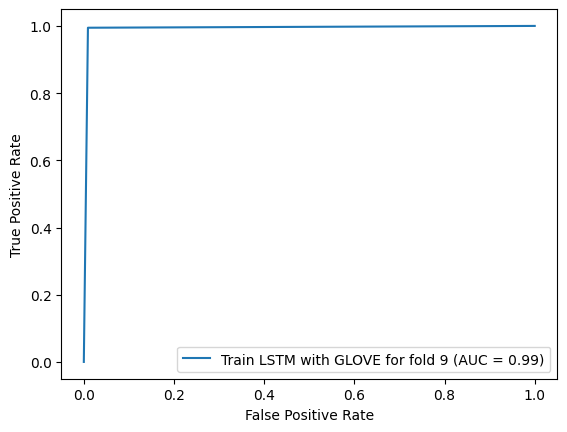

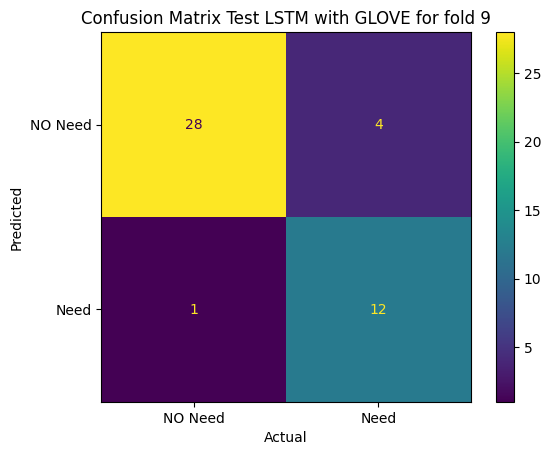

-----------------LSTM with GLOVE-------------------------------
Training for fold 9 ...
Epoch 1/20
13/13 [==============================] - 14s 431ms/step - loss: 0.6555 - accuracy: 0.6049 - val_loss: 0.6626 - val_accuracy: 0.6000
Epoch 2/20
13/13 [==============================] - 2s 136ms/step - loss: 0.6151 - accuracy: 0.6346 - val_loss: 0.6444 - val_accuracy: 0.6889
Epoch 3/20
13/13 [==============================] - 2s 190ms/step - loss: 0.5746 - accuracy: 0.7358 - val_loss: 0.6212 - val_accuracy: 0.6000
Epoch 4/20
13/13 [==============================] - 4s 337ms/step - loss: 0.5249 - accuracy: 0.8074 - val_loss: 0.5821 - val_accuracy: 0.6444
Epoch 5/20
13/13 [==============================] - 3s 274ms/step - loss: 0.4766 - accuracy: 0.8148 - val_loss: 0.5327 - val_accuracy: 0.7556
Epoch 6/20
13/13 [==============================] - 2s 120ms/step - loss: 0.4282 - accuracy: 0.8494 - val_loss: 0.4852 - val_accuracy: 0.8000
Epoch 7/20
13/13 [==============================] - 4s 330m

<Figure size 640x480 with 0 Axes>

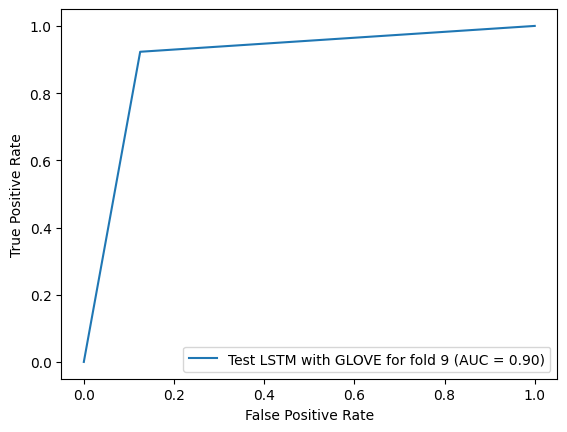

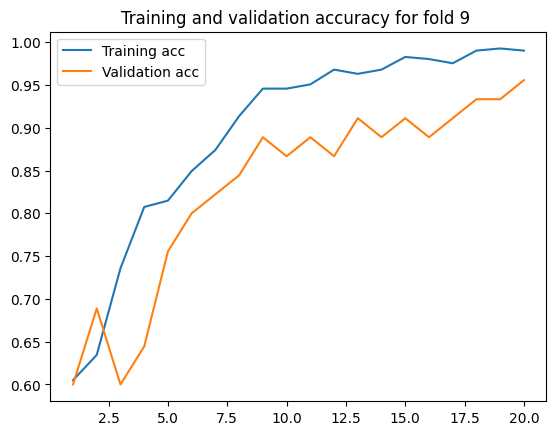

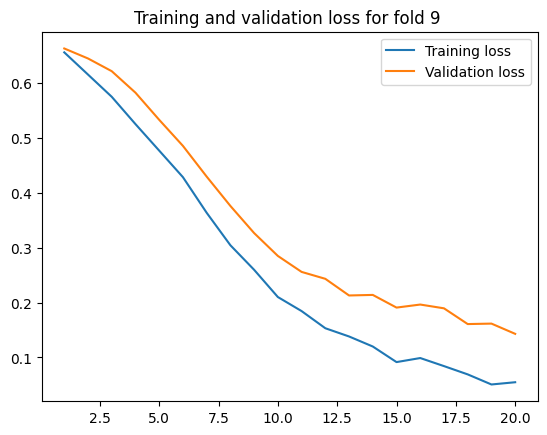

13/13 [==============================] - 1s 72ms/step
===== : TRAIN for fold 10 : =====
accuracy = 99.25925925925925
recall= 99.11894273127754
precision= 99.5575221238938
FAR= 0.5617977528089888
Fmeasure= 99.33774834437085


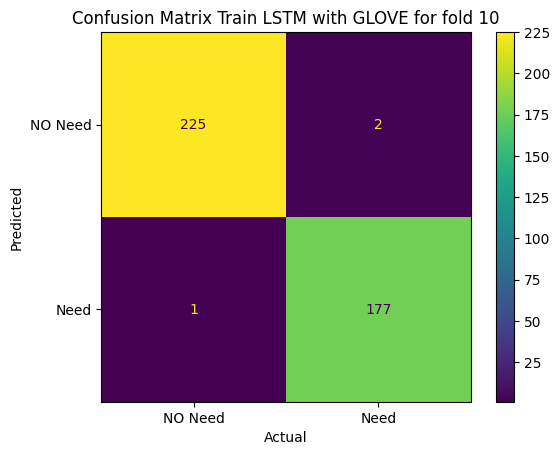

2/2 [==============================] - 0s 21ms/step
===== : TEST for fold 10 : =====
accuracy = 95.55555555555556
recall= 91.66666666666666
precision= 100.0
FAR= 0.0
Fmeasure= 95.65217391304348


<Figure size 640x480 with 0 Axes>

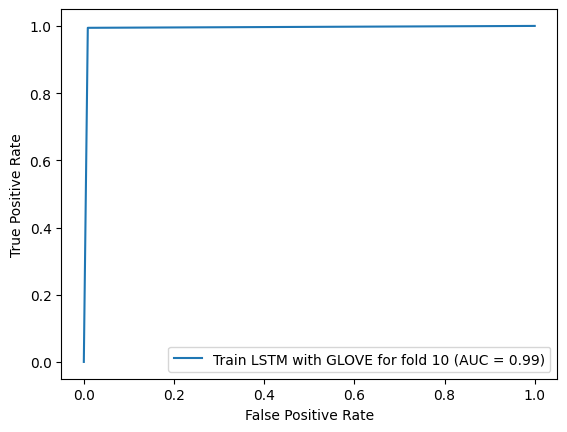

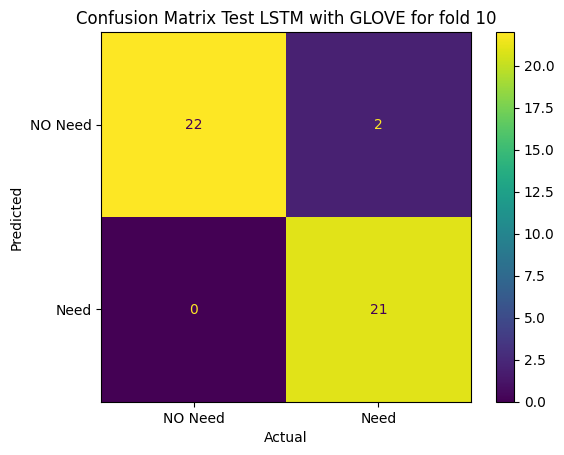

-----------------LSTM with GLOVE-------------------------------
Training for fold 10 ...
Epoch 1/20
13/13 [==============================] - 11s 254ms/step - loss: 0.6886 - accuracy: 0.5506 - val_loss: 0.6564 - val_accuracy: 0.7333
Epoch 2/20
13/13 [==============================] - 5s 440ms/step - loss: 0.6559 - accuracy: 0.6247 - val_loss: 0.6204 - val_accuracy: 0.7111
Epoch 3/20
13/13 [==============================] - 3s 257ms/step - loss: 0.6343 - accuracy: 0.6519 - val_loss: 0.5964 - val_accuracy: 0.7333
Epoch 4/20
13/13 [==============================] - 4s 326ms/step - loss: 0.6153 - accuracy: 0.6543 - val_loss: 0.5748 - val_accuracy: 0.7778
Epoch 5/20
13/13 [==============================] - 2s 150ms/step - loss: 0.5824 - accuracy: 0.7259 - val_loss: 0.5542 - val_accuracy: 0.7778
Epoch 6/20
13/13 [==============================] - 4s 334ms/step - loss: 0.5478 - accuracy: 0.7531 - val_loss: 0.5303 - val_accuracy: 0.8000
Epoch 7/20
13/13 [==============================] - 2s 184

<Figure size 640x480 with 0 Axes>

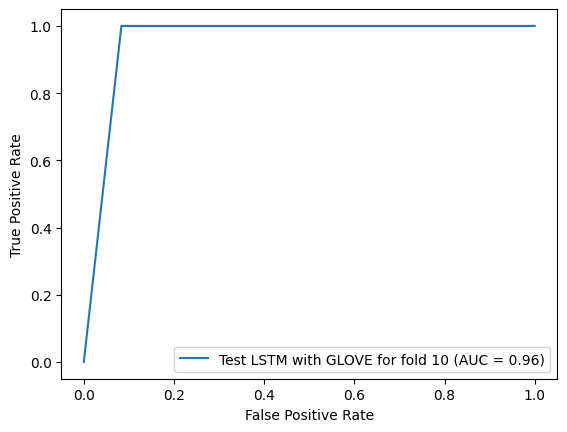

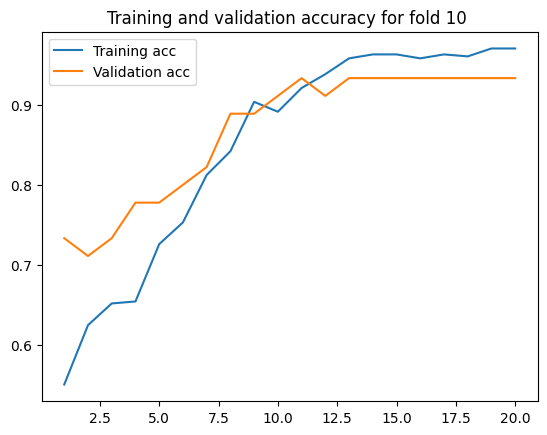

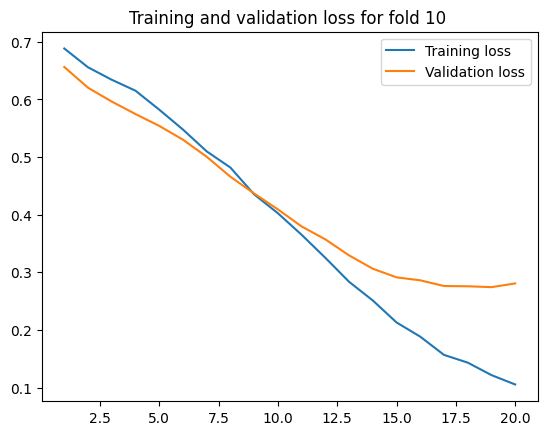

13/13 [==============================] - 2s 112ms/step
===== : TRAIN for fold 11 : =====
accuracy = 98.51851851851852
recall= 99.5575221238938
precision= 97.82608695652173
FAR= 2.793296089385475
Fmeasure= 98.6842105263158


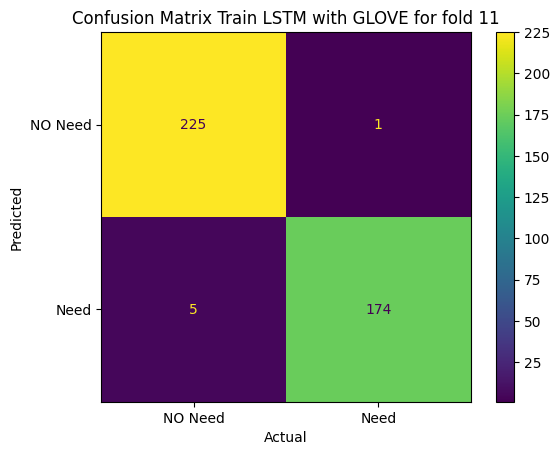

2/2 [==============================] - 0s 19ms/step
===== : TEST for fold 11 : =====
accuracy = 93.33333333333333
recall= 100.0
precision= 89.28571428571429
FAR= 15.0
Fmeasure= 94.33962264150945


<Figure size 640x480 with 0 Axes>

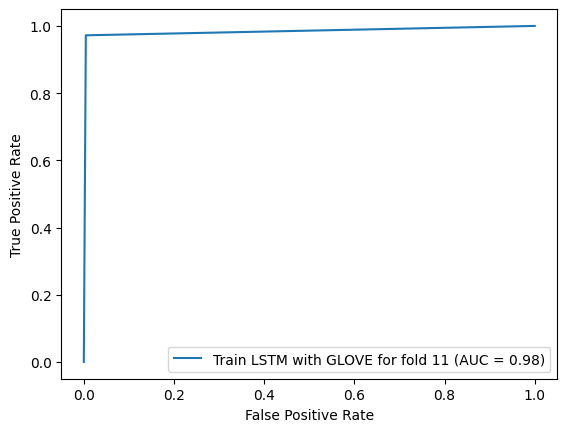

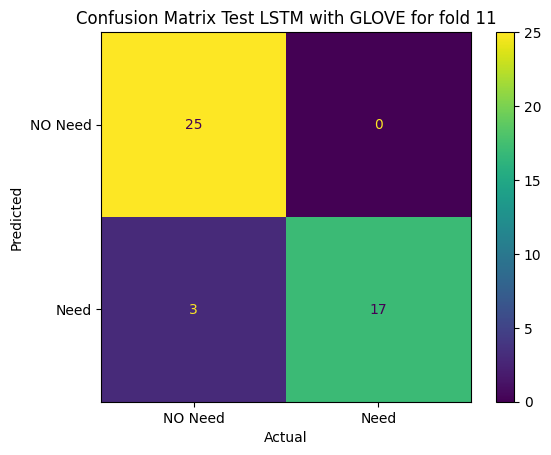

<Figure size 640x480 with 0 Axes>

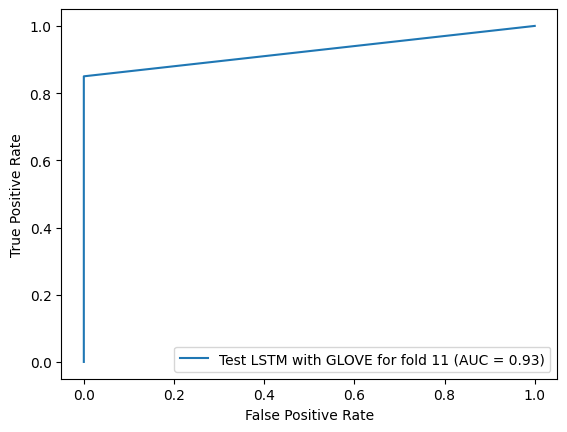

In [ ]:
#LSTM with GLOVE by k-fold
# K-fold Cross Validation model evaluation
embd_index={}
f=open("glove.6B.100d.txt",encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embd_index[word]=coefs
f.close()

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(text_new_lemma)
sequence=tokenizer_obj.texts_to_sequences(text_new_lemma)
word_index=tokenizer_obj.word_index
max_len=max([len(s) for s in text_new_lemma])
review_pad=pad_sequences(sequence,maxlen=max_len)
num_words=len(word_index)+1
EmbeddingDIM=100
emb_matrix=np.zeros((num_words,EmbeddingDIM))
for word,i in word_index.items():
    if i>num_words:
        continue
    emb_vector=embd_index.get(word)
    if emb_vector is not None:
        emb_matrix[i]=emb_vector

kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
acc=[]
val_acc=[]
loss=[]
val_loss=[]
recallTrain=[]
recallTest=[]
precTrain=[]
precTest=[]

for train, test in kfold.split(review_pad, y1):
    model=Sequential()
    embd_layer=Embedding(num_words, EmbeddingDIM, embeddings_initializer=Constant(emb_matrix),input_length=max_len)
    model.add(embd_layer)
    model.add(Bidirectional(LSTM(units=5,dropout=0.1,recurrent_dropout=0.1)))
    optimizer = keras.optimizers.Adam(lr=0.001)
    #optimizer =keras.optimizers.SGD(lr=0.1)
    #optimizer =keras.optimizers.RMSprop(lr=0.8)
    model.add(Dense(5, activation = "relu")) #denselayer_2
    model.add(Dropout(0.1)) #dropout_3
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid')) #classification_layer
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Generate a print
    print('-----------------LSTM with GLOVE-------------------------------')
    print(f'Training for fold {fold_no} ...')
    history =model.fit(review_pad[train], y1[train],
              validation_data= (review_pad[test], y1[test]),
              epochs= 20,verbose=1)

    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    epochs = range(1, 20 + 1)

    plt.figure()
    plt.plot(epochs, acc[-1], label='Training acc')
    plt.plot(epochs, val_acc[-1], label='Validation acc')
    plt.title(f'Training and validation accuracy for fold {fold_no} ')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, loss[-1], label='Training loss')
    plt.plot(epochs, val_loss[-1], label='Validation loss')
    plt.title(f'Training and validation loss for fold {fold_no} ')
    plt.legend()

    plt.show()
    # Increase fold number
    fold_no = fold_no + 1
    p_tr = (model.predict(review_pad[train])>0.5).astype("int32")
    print(f"===== : TRAIN for fold {fold_no} : =====")
    mymetrics(y1[train],p_tr,f"Train LSTM with GLOVE for fold {fold_no}")
    show_confusion_ROC(y1[train],p_tr,f'Train LSTM with GLOVE for fold {fold_no}')
    p_te = (model.predict(review_pad[test])>0.5).astype("int32")
    print(f"===== : TEST for fold {fold_no} : =====")
    mymetrics(y1[test],p_te,f'Test LSTM with GLOVE for fold {fold_no}')
    show_confusion_ROC(y1[test],p_te,f'Test LSTM with GLOVE for fold {fold_no}')
    prec,reca=precRecall(y1[train],p_tr)
    recallTrain.append(reca)
    precTrain.append(prec)
    prec,reca=precRecall(y1[test],p_te)
    recallTest.append(reca)
    precTest.append(prec)


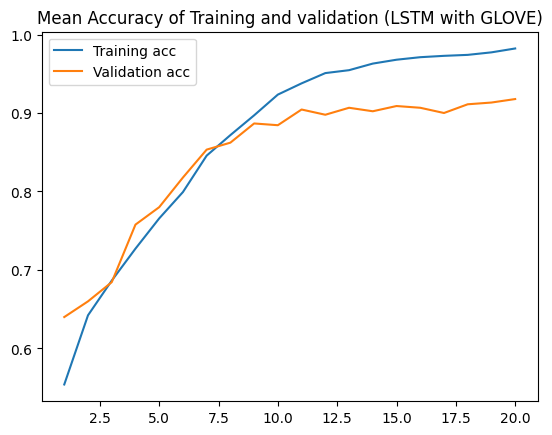

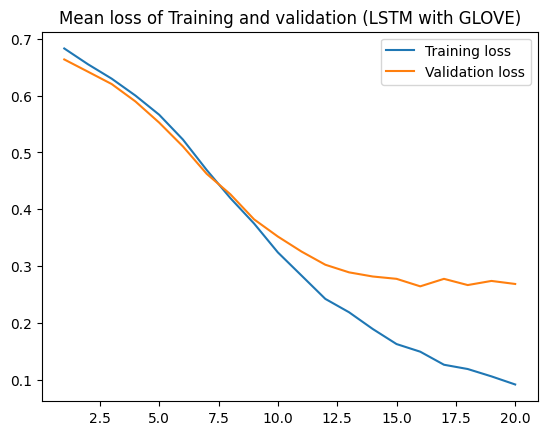

In [ ]:
accmean=np.array(acc).mean(axis=0)
val_accmean=np.array(val_acc).mean(axis=0)
lossmean=np.array(loss).mean(axis=0)
val_lossmean=np.array(val_loss).mean(axis=0)
plt.figure()
plt.plot(epochs, accmean, label='Training acc')
plt.plot(epochs, val_accmean, label='Validation acc')
plt.title('Mean Accuracy of Training and validation (LSTM with GLOVE)')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, lossmean, label='Training loss')
plt.plot(epochs, val_lossmean, label='Validation loss')
plt.title('Mean loss of Training and validation (LSTM with GLOVE)')
plt.legend()

plt.show()

-----------------LSTM with TF-IDF-------------------------------
Training for fold 1 ...
Epoch 1/20
13/13 [==============================] - 40s 3s/step - loss: 0.6859 - accuracy: 0.5654 - val_loss: 0.7357 - val_accuracy: 0.4444
Epoch 2/20
13/13 [==============================] - 24s 2s/step - loss: 0.6806 - accuracy: 0.5704 - val_loss: 0.6898 - val_accuracy: 0.4444
Epoch 3/20
13/13 [==============================] - 28s 2s/step - loss: 0.6798 - accuracy: 0.7383 - val_loss: 0.6759 - val_accuracy: 0.6000
Epoch 4/20
13/13 [==============================] - 19s 1s/step - loss: 0.6515 - accuracy: 0.6346 - val_loss: 0.6730 - val_accuracy: 0.4444
Epoch 5/20
13/13 [==============================] - 20s 2s/step - loss: 0.5830 - accuracy: 0.6889 - val_loss: 0.6056 - val_accuracy: 0.5778
Epoch 6/20
13/13 [==============================] - 18s 1s/step - loss: 0.5055 - accuracy: 0.7284 - val_loss: 0.5738 - val_accuracy: 0.6444
Epoch 7/20
13/13 [==============================] - 18s 1s/step - loss:

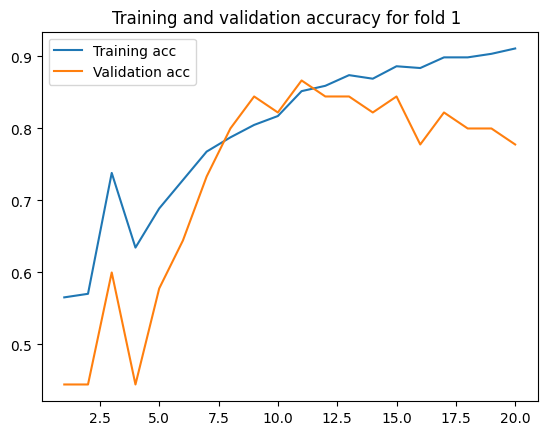

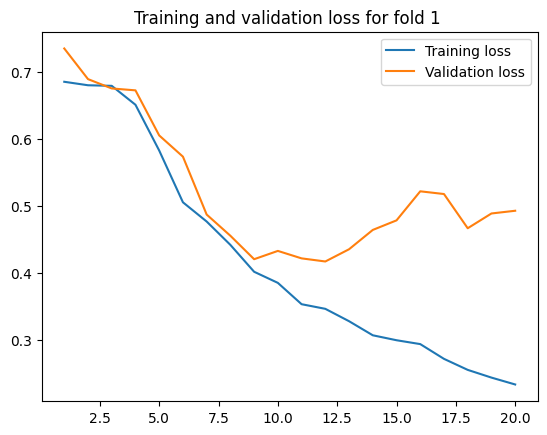

13/13 [==============================] - 5s 297ms/step
===== : TRAIN for fold 2 : =====
accuracy = 92.34567901234568
recall= 91.34199134199135
precision= 95.04504504504504
FAR= 6.321839080459771
Fmeasure= 93.15673289183222


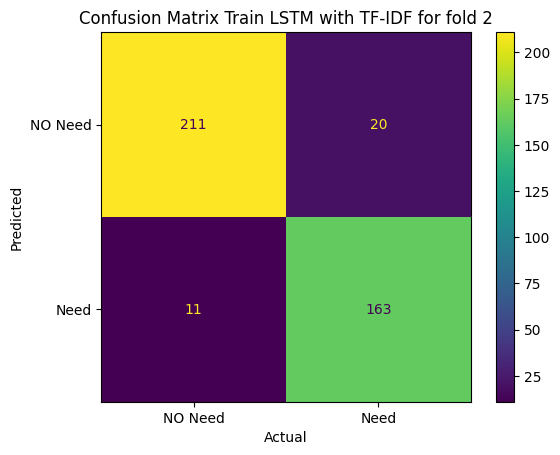

2/2 [==============================] - 2s 2s/step
===== : TEST for fold 2 : =====
accuracy = 77.77777777777779
recall= 85.0
precision= 70.83333333333334
FAR= 28.000000000000004
Fmeasure= 77.27272727272727


<Figure size 640x480 with 0 Axes>

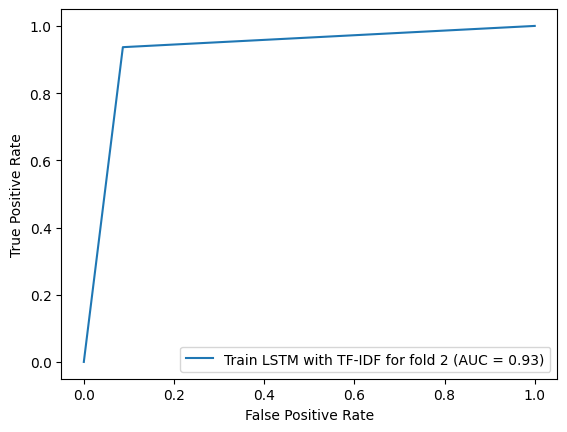

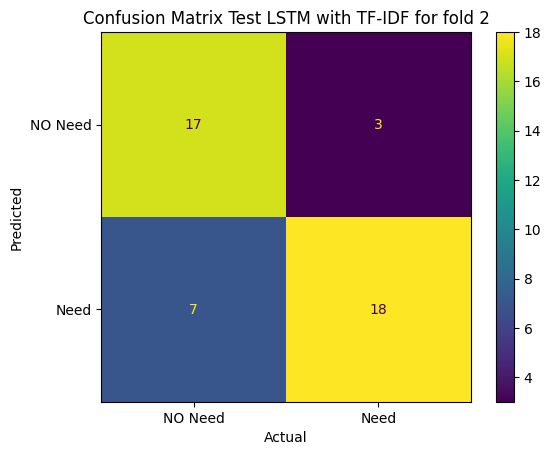

-----------------LSTM with TF-IDF-------------------------------
Training for fold 2 ...
Epoch 1/20
13/13 [==============================] - 27s 2s/step - loss: 0.6914 - accuracy: 0.5136 - val_loss: 0.6758 - val_accuracy: 0.6000
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.6839 - accuracy: 0.5531 - val_loss: 0.6720 - val_accuracy: 0.6000
Epoch 3/20
13/13 [==============================] - 19s 1s/step - loss: 0.6770 - accuracy: 0.5531 - val_loss: 0.6622 - val_accuracy: 0.6000
Epoch 4/20
13/13 [==============================] - 17s 1s/step - loss: 0.6630 - accuracy: 0.5654 - val_loss: 0.6399 - val_accuracy: 0.6889
Epoch 5/20
13/13 [==============================] - 16s 1s/step - loss: 0.6083 - accuracy: 0.7531 - val_loss: 0.5529 - val_accuracy: 0.8222
Epoch 6/20
13/13 [==============================] - 24s 2s/step - loss: 0.5300 - accuracy: 0.7309 - val_loss: 0.4948 - val_accuracy: 0.8000
Epoch 7/20
13/13 [==============================] - 24s 2s/step - loss:

<Figure size 640x480 with 0 Axes>

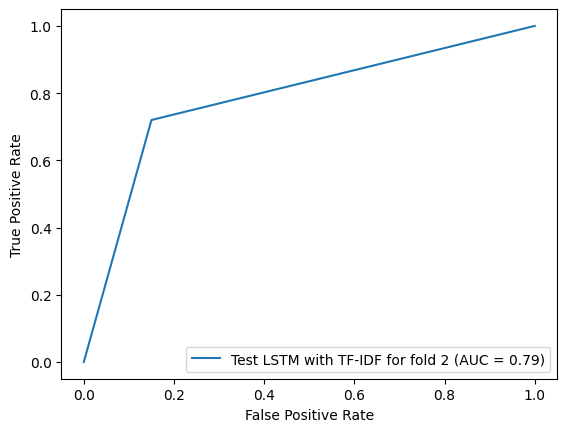

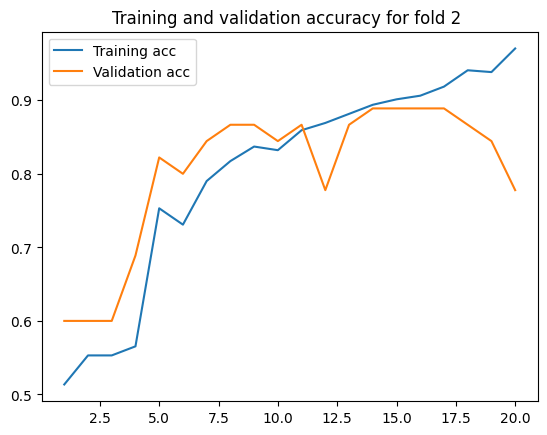

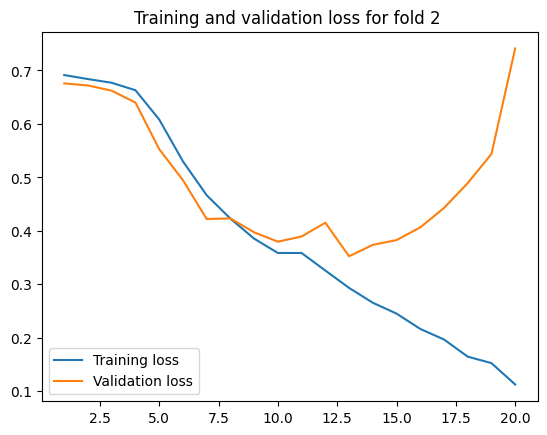

13/13 [==============================] - 7s 461ms/step
===== : TRAIN for fold 3 : =====
accuracy = 96.04938271604938
recall= 95.08928571428571
precision= 97.70642201834863
FAR= 2.7624309392265194
Fmeasure= 96.38009049773757


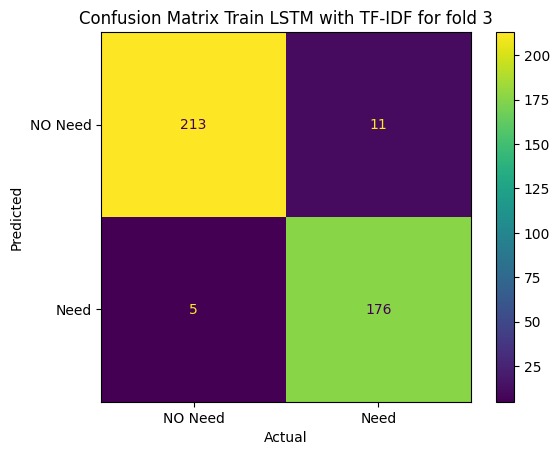

2/2 [==============================] - 0s 170ms/step
===== : TEST for fold 3 : =====
accuracy = 77.77777777777779
recall= 74.07407407407408
precision= 86.95652173913044
FAR= 16.666666666666664
Fmeasure= 80.0


<Figure size 640x480 with 0 Axes>

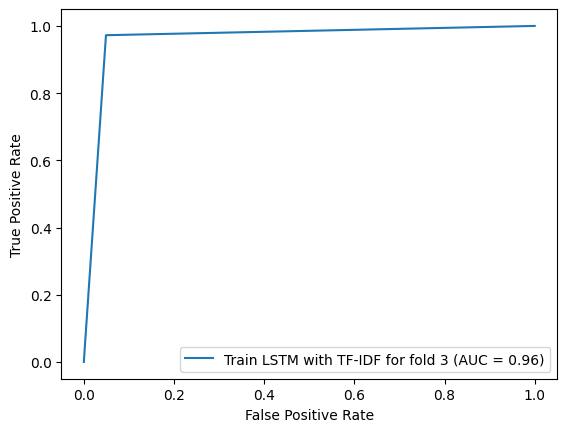

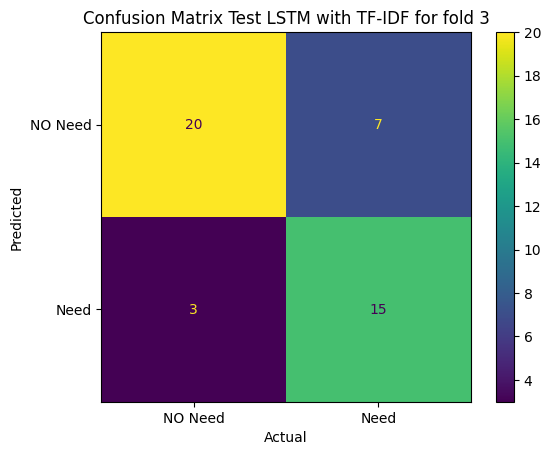

-----------------LSTM with TF-IDF-------------------------------
Training for fold 3 ...
Epoch 1/20
13/13 [==============================] - 30s 2s/step - loss: 0.6963 - accuracy: 0.5531 - val_loss: 0.6798 - val_accuracy: 0.5778
Epoch 2/20
13/13 [==============================] - 23s 2s/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6870 - val_accuracy: 0.5778
Epoch 3/20
13/13 [==============================] - 22s 2s/step - loss: 0.6879 - accuracy: 0.5556 - val_loss: 0.6810 - val_accuracy: 0.5778
Epoch 4/20
13/13 [==============================] - 21s 2s/step - loss: 0.6890 - accuracy: 0.5556 - val_loss: 0.6805 - val_accuracy: 0.5778
Epoch 5/20
13/13 [==============================] - 21s 2s/step - loss: 0.6841 - accuracy: 0.5556 - val_loss: 0.6773 - val_accuracy: 0.5778
Epoch 6/20
13/13 [==============================] - 22s 2s/step - loss: 0.6790 - accuracy: 0.5556 - val_loss: 0.6682 - val_accuracy: 0.5778
Epoch 7/20
13/13 [==============================] - 22s 2s/step - loss:

<Figure size 640x480 with 0 Axes>

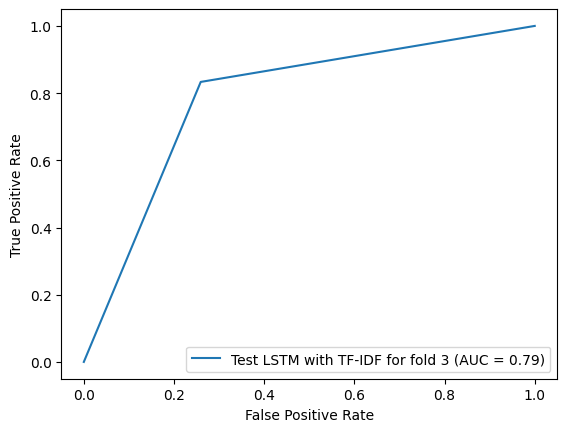

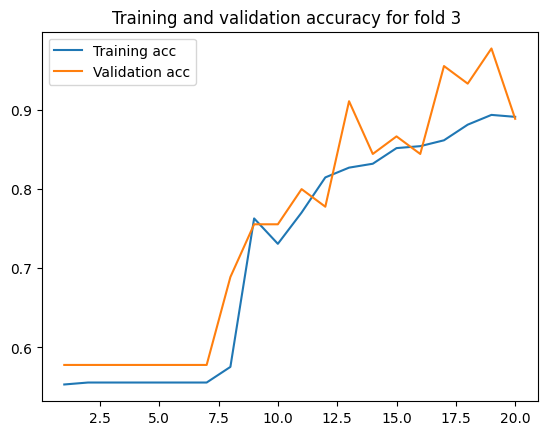

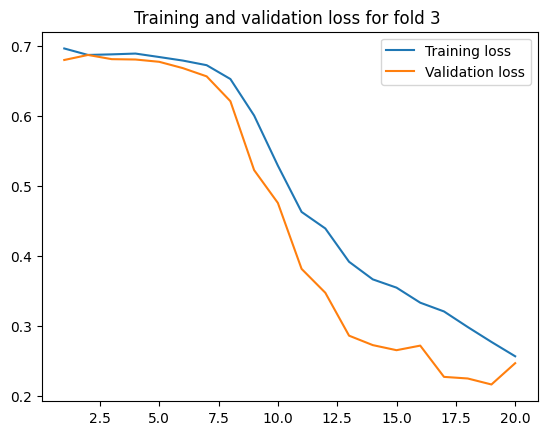

13/13 [==============================] - 9s 633ms/step
===== : TRAIN for fold 4 : =====
accuracy = 90.8641975308642
recall= 93.33333333333333
precision= 90.51724137931035
FAR= 12.222222222222221
Fmeasure= 91.90371991247265


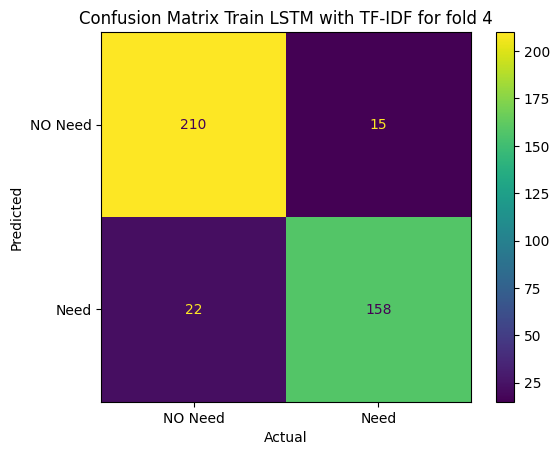

2/2 [==============================] - 1s 786ms/step
===== : TEST for fold 4 : =====
accuracy = 88.88888888888889
recall= 96.15384615384616
precision= 86.20689655172413
FAR= 21.052631578947366
Fmeasure= 90.9090909090909


<Figure size 640x480 with 0 Axes>

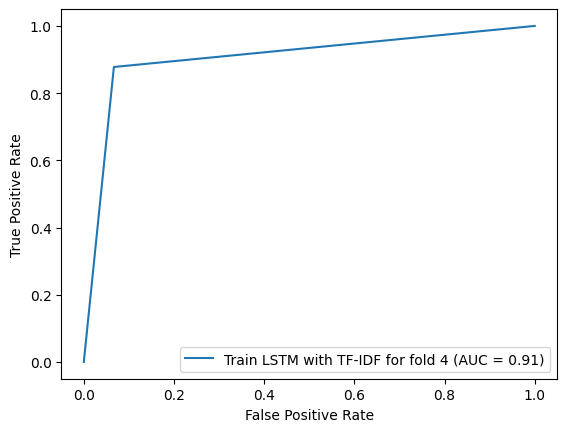

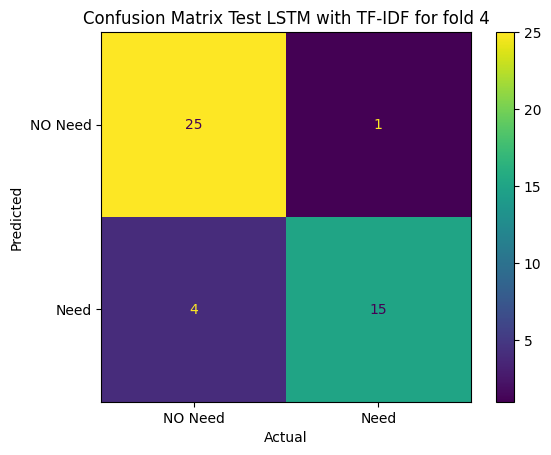

-----------------LSTM with TF-IDF-------------------------------
Training for fold 4 ...
Epoch 1/20
13/13 [==============================] - 23s 1s/step - loss: 0.6914 - accuracy: 0.5630 - val_loss: 0.7015 - val_accuracy: 0.4667
Epoch 2/20
13/13 [==============================] - 19s 1s/step - loss: 0.6830 - accuracy: 0.5679 - val_loss: 0.7258 - val_accuracy: 0.4667
Epoch 3/20
13/13 [==============================] - 17s 1s/step - loss: 0.6828 - accuracy: 0.5679 - val_loss: 0.7013 - val_accuracy: 0.4667
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.6873 - accuracy: 0.5679 - val_loss: 0.6928 - val_accuracy: 0.4667
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: 0.6792 - accuracy: 0.5679 - val_loss: 0.7106 - val_accuracy: 0.4667
Epoch 6/20
13/13 [==============================] - 17s 1s/step - loss: 0.6708 - accuracy: 0.5679 - val_loss: 0.6879 - val_accuracy: 0.4667
Epoch 7/20
13/13 [==============================] - 17s 1s/step - loss:

<Figure size 640x480 with 0 Axes>

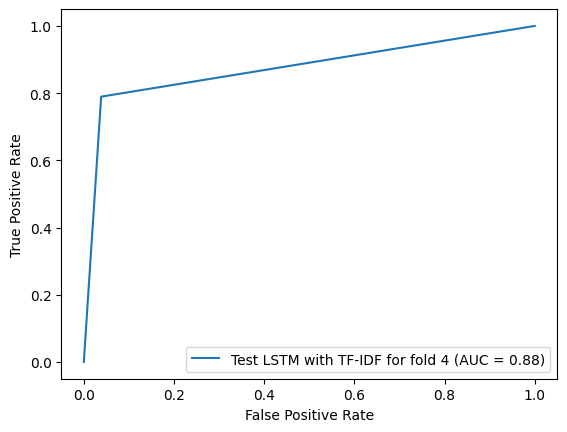

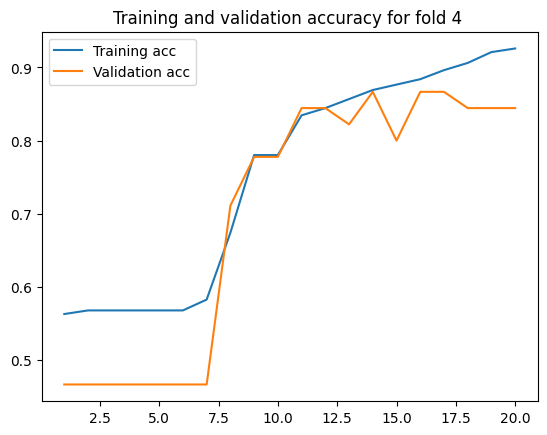

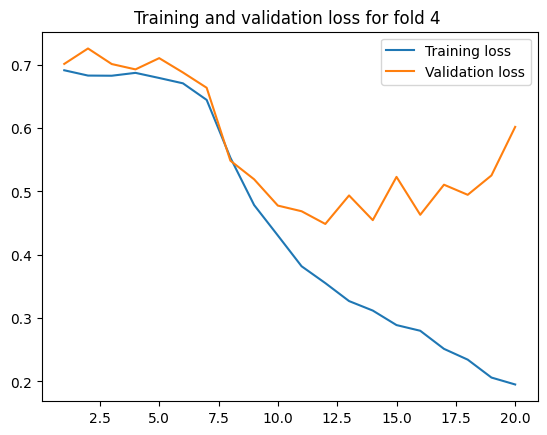

13/13 [==============================] - 9s 606ms/step
===== : TRAIN for fold 5 : =====
accuracy = 94.07407407407408
recall= 92.6086956521739
precision= 96.81818181818181
FAR= 4.0
Fmeasure= 94.66666666666667


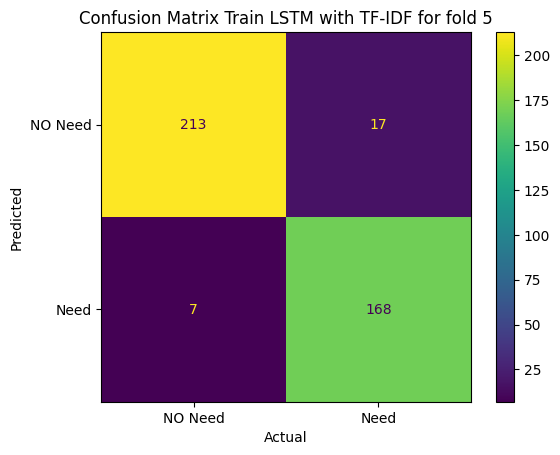

2/2 [==============================] - 0s 285ms/step
===== : TEST for fold 5 : =====
accuracy = 84.44444444444444
recall= 80.95238095238095
precision= 85.0
FAR= 12.5
Fmeasure= 82.92682926829269


<Figure size 640x480 with 0 Axes>

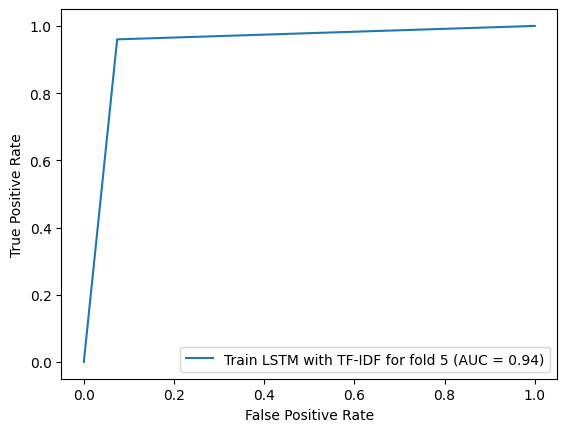

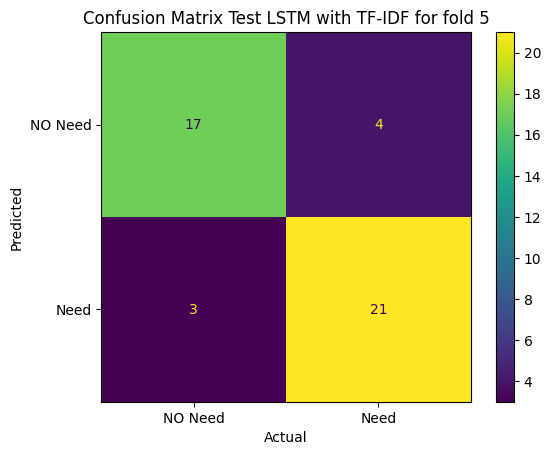

-----------------LSTM with TF-IDF-------------------------------
Training for fold 5 ...
Epoch 1/20
13/13 [==============================] - 29s 2s/step - loss: 0.6929 - accuracy: 0.5407 - val_loss: 0.6704 - val_accuracy: 0.6889
Epoch 2/20
13/13 [==============================] - 19s 2s/step - loss: 0.6880 - accuracy: 0.5432 - val_loss: 0.6768 - val_accuracy: 0.6889
Epoch 3/20
13/13 [==============================] - 20s 2s/step - loss: 0.6822 - accuracy: 0.5432 - val_loss: 0.6564 - val_accuracy: 0.6889
Epoch 4/20
13/13 [==============================] - 21s 2s/step - loss: 0.6688 - accuracy: 0.5827 - val_loss: 0.6270 - val_accuracy: 0.6889
Epoch 5/20
13/13 [==============================] - 21s 2s/step - loss: 0.6242 - accuracy: 0.6519 - val_loss: 0.6094 - val_accuracy: 0.7556
Epoch 6/20
13/13 [==============================] - 22s 2s/step - loss: 0.5087 - accuracy: 0.7778 - val_loss: 0.5592 - val_accuracy: 0.7111
Epoch 7/20
13/13 [==============================] - 21s 2s/step - loss:

<Figure size 640x480 with 0 Axes>

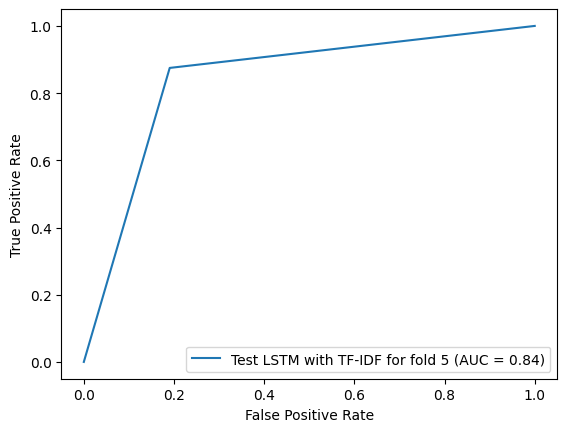

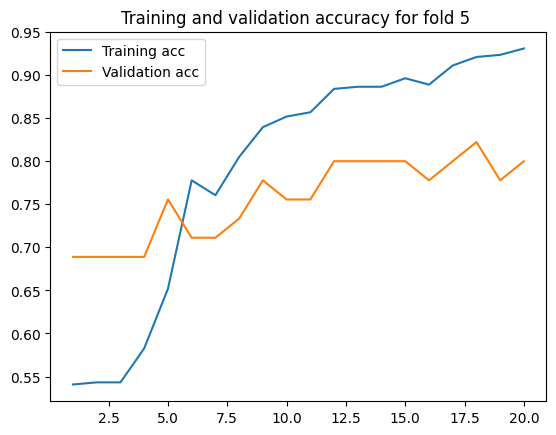

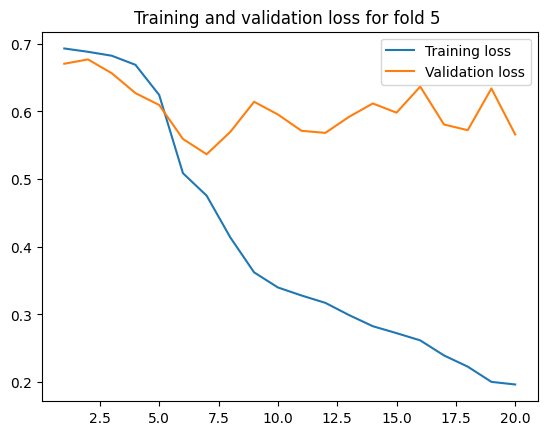

13/13 [==============================] - 4s 265ms/step
===== : TRAIN for fold 6 : =====
accuracy = 92.8395061728395
recall= 90.9090909090909
precision= 95.69377990430623
FAR= 4.864864864864865
Fmeasure= 93.24009324009323


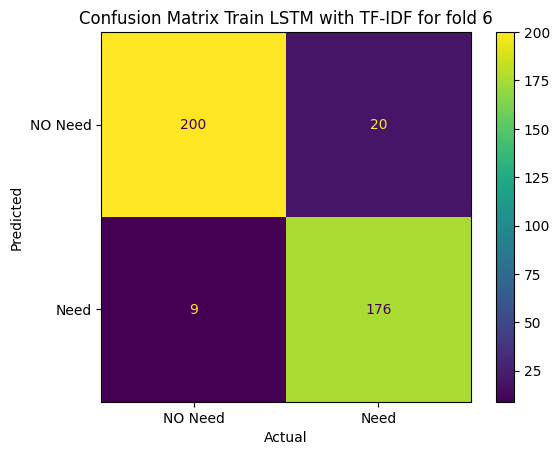

2/2 [==============================] - 0s 148ms/step
===== : TEST for fold 6 : =====
accuracy = 80.0
recall= 80.64516129032258
precision= 89.28571428571429
FAR= 21.428571428571427
Fmeasure= 84.74576271186439


<Figure size 640x480 with 0 Axes>

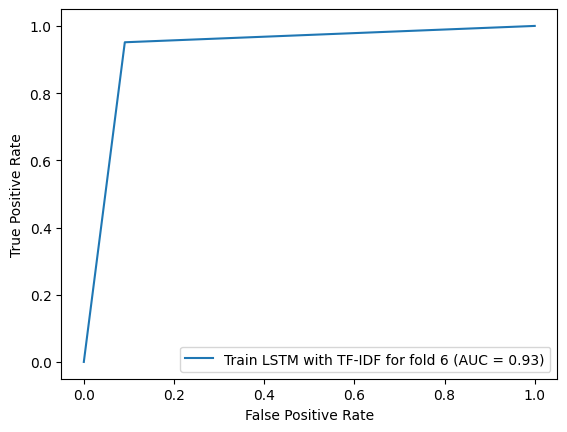

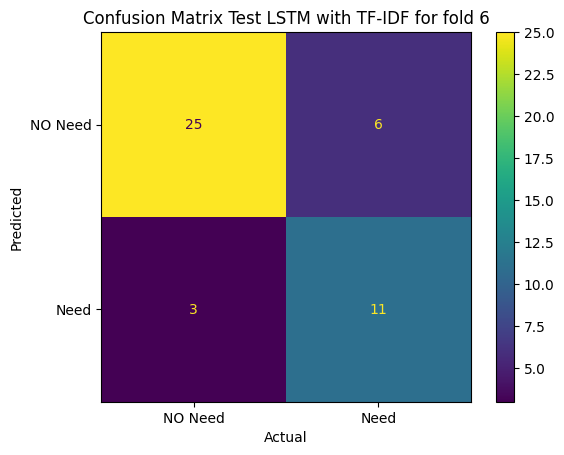

-----------------LSTM with TF-IDF-------------------------------
Training for fold 6 ...
Epoch 1/20
13/13 [==============================] - 21s 1s/step - loss: 0.6926 - accuracy: 0.5407 - val_loss: 0.6734 - val_accuracy: 0.6444
Epoch 2/20
13/13 [==============================] - 14s 1s/step - loss: 0.6895 - accuracy: 0.5481 - val_loss: 0.6685 - val_accuracy: 0.6444
Epoch 3/20
13/13 [==============================] - 14s 1s/step - loss: 0.6908 - accuracy: 0.5481 - val_loss: 0.6695 - val_accuracy: 0.6444
Epoch 4/20
13/13 [==============================] - 15s 1s/step - loss: 0.6871 - accuracy: 0.5630 - val_loss: 0.6735 - val_accuracy: 0.6444
Epoch 5/20
13/13 [==============================] - 14s 1s/step - loss: 0.6801 - accuracy: 0.5481 - val_loss: 0.6549 - val_accuracy: 0.6444
Epoch 6/20
13/13 [==============================] - 15s 1s/step - loss: 0.6876 - accuracy: 0.5630 - val_loss: 0.6690 - val_accuracy: 0.8444
Epoch 7/20
13/13 [==============================] - 14s 1s/step - loss:

<Figure size 640x480 with 0 Axes>

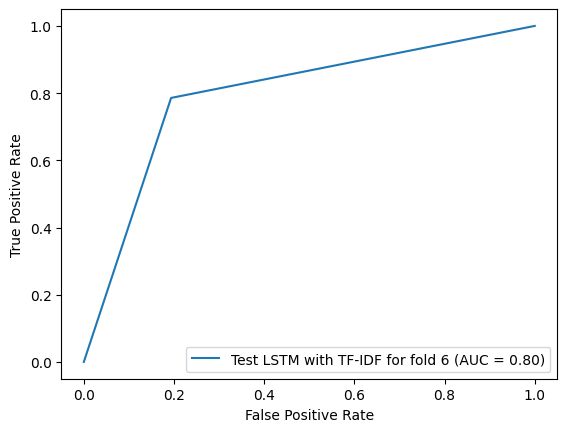

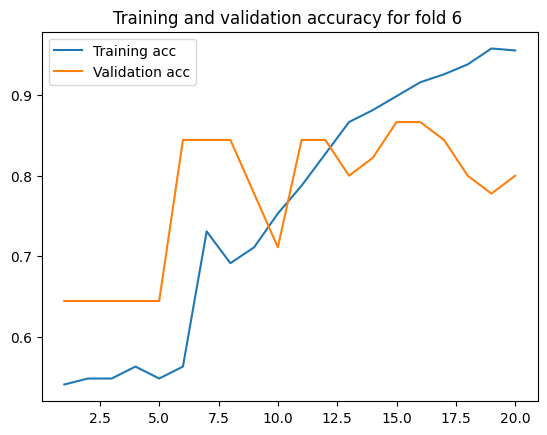

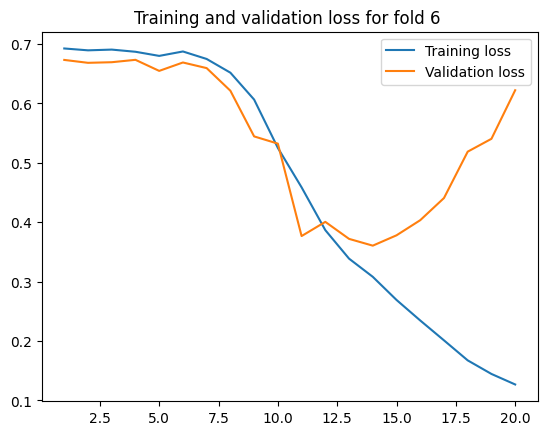

13/13 [==============================] - 3s 192ms/step
===== : TRAIN for fold 7 : =====
accuracy = 98.0246913580247
recall= 97.2972972972973
precision= 99.08256880733946
FAR= 1.092896174863388
Fmeasure= 98.18181818181819


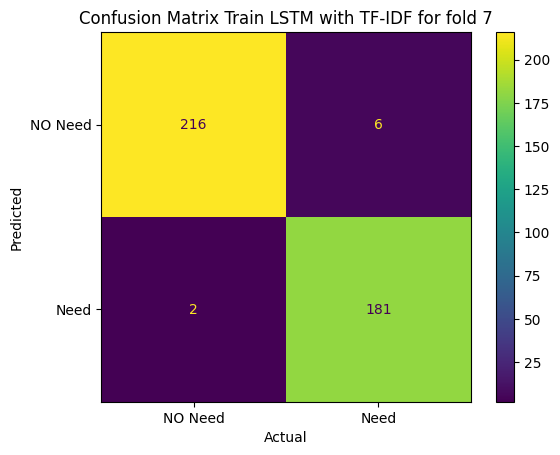

2/2 [==============================] - 1s 438ms/step
===== : TEST for fold 7 : =====
accuracy = 80.0
recall= 79.3103448275862
precision= 88.46153846153845
FAR= 18.75
Fmeasure= 83.63636363636363


<Figure size 640x480 with 0 Axes>

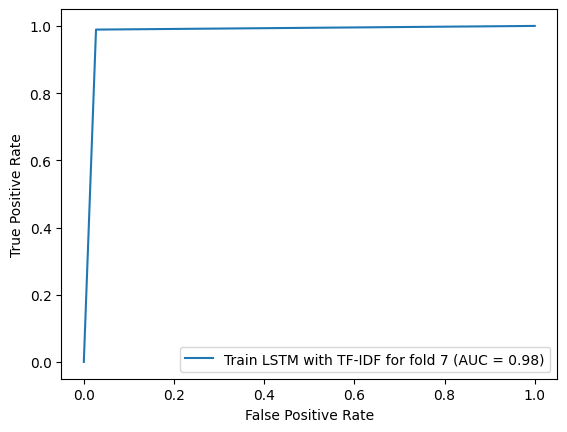

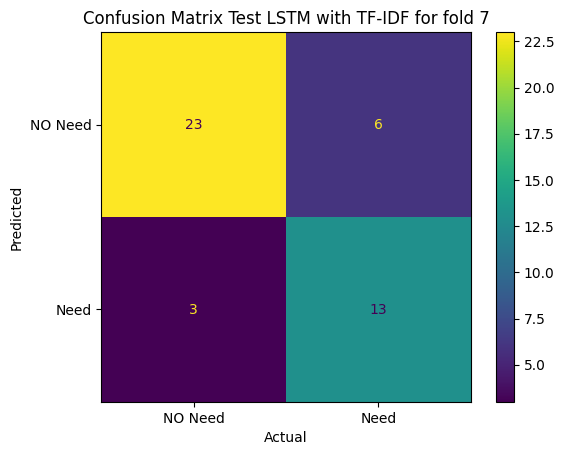

-----------------LSTM with TF-IDF-------------------------------
Training for fold 7 ...
Epoch 1/20
13/13 [==============================] - 22s 1s/step - loss: 0.6910 - accuracy: 0.5309 - val_loss: 0.6738 - val_accuracy: 0.6000
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.6832 - accuracy: 0.5531 - val_loss: 0.6702 - val_accuracy: 0.6000
Epoch 3/20
13/13 [==============================] - 16s 1s/step - loss: 0.6754 - accuracy: 0.5556 - val_loss: 0.6601 - val_accuracy: 0.6444
Epoch 4/20
13/13 [==============================] - 17s 1s/step - loss: 0.6421 - accuracy: 0.7185 - val_loss: 0.6170 - val_accuracy: 0.7333
Epoch 5/20
13/13 [==============================] - 16s 1s/step - loss: 0.5579 - accuracy: 0.7136 - val_loss: 0.5211 - val_accuracy: 0.7333
Epoch 6/20
13/13 [==============================] - 17s 1s/step - loss: 0.4746 - accuracy: 0.7753 - val_loss: 0.4843 - val_accuracy: 0.7556
Epoch 7/20
13/13 [==============================] - 20s 2s/step - loss:

<Figure size 640x480 with 0 Axes>

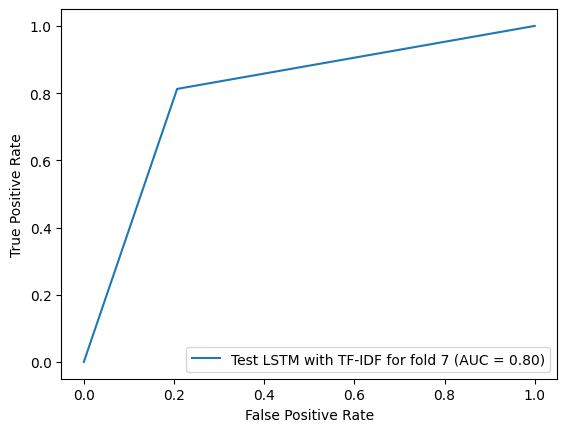

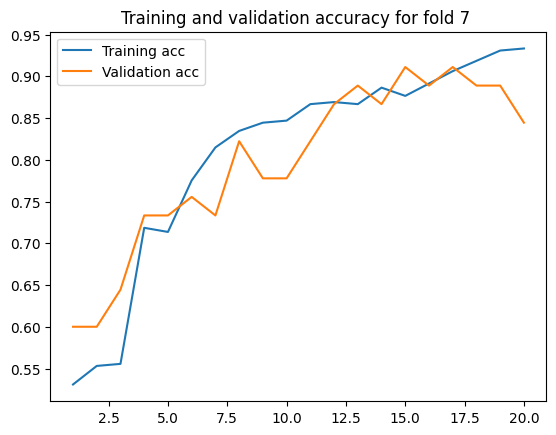

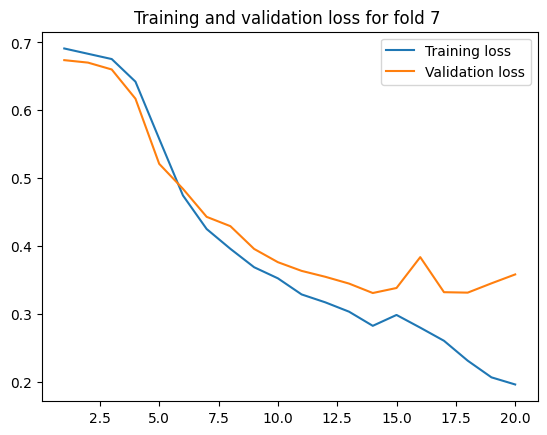

13/13 [==============================] - 4s 208ms/step
===== : TRAIN for fold 8 : =====
accuracy = 93.82716049382715
recall= 92.41071428571429
precision= 96.27906976744185
FAR= 4.41988950276243
Fmeasure= 94.30523917995444


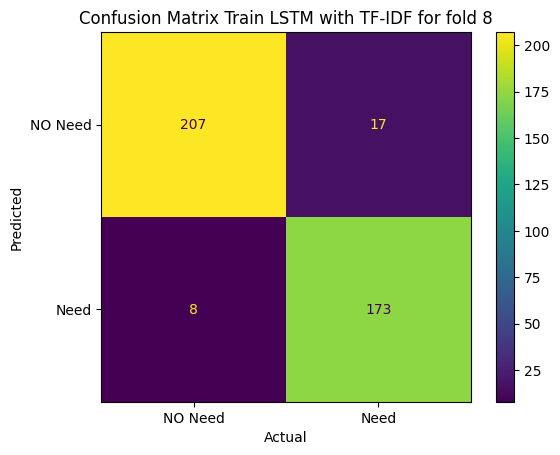

2/2 [==============================] - 0s 157ms/step
===== : TEST for fold 8 : =====
accuracy = 84.44444444444444
recall= 81.48148148148148
precision= 91.66666666666666
FAR= 11.11111111111111
Fmeasure= 86.27450980392156


<Figure size 640x480 with 0 Axes>

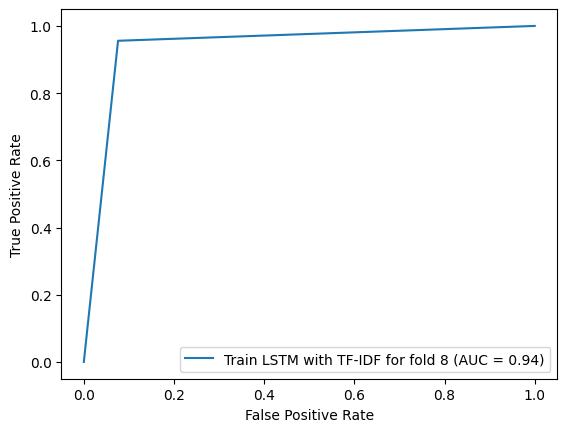

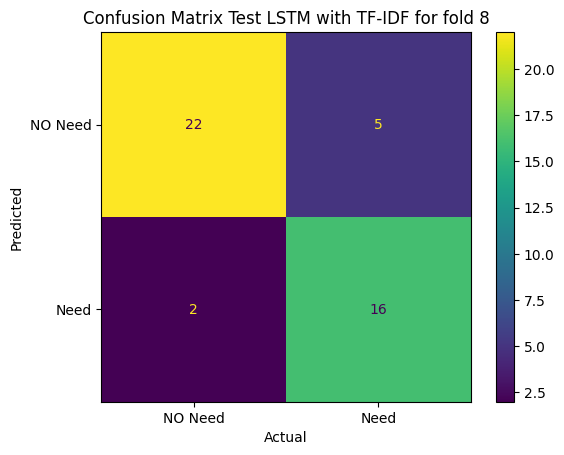

-----------------LSTM with TF-IDF-------------------------------
Training for fold 8 ...
Epoch 1/20
13/13 [==============================] - 23s 1s/step - loss: 0.6853 - accuracy: 0.5926 - val_loss: 0.7183 - val_accuracy: 0.4444
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.6811 - accuracy: 0.5704 - val_loss: 0.6969 - val_accuracy: 0.4444
Epoch 3/20
13/13 [==============================] - 15s 1s/step - loss: 0.6652 - accuracy: 0.5704 - val_loss: 0.6883 - val_accuracy: 0.4444
Epoch 4/20
13/13 [==============================] - 17s 1s/step - loss: 0.6422 - accuracy: 0.6741 - val_loss: 0.6850 - val_accuracy: 0.4444
Epoch 5/20
13/13 [==============================] - 16s 1s/step - loss: 0.5821 - accuracy: 0.6741 - val_loss: 0.6160 - val_accuracy: 0.5778
Epoch 6/20
13/13 [==============================] - 15s 1s/step - loss: 0.4990 - accuracy: 0.7778 - val_loss: 0.6800 - val_accuracy: 0.5333
Epoch 7/20
13/13 [==============================] - 16s 1s/step - loss:

<Figure size 640x480 with 0 Axes>

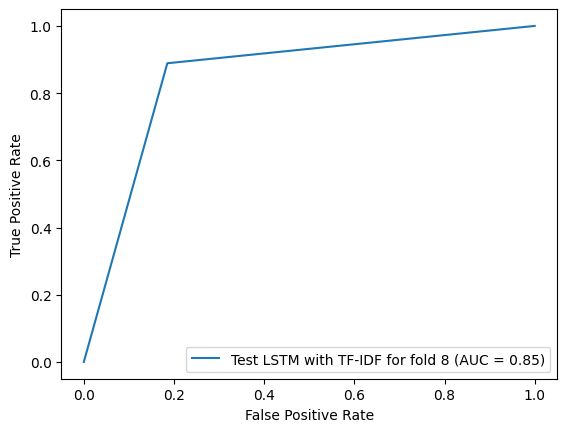

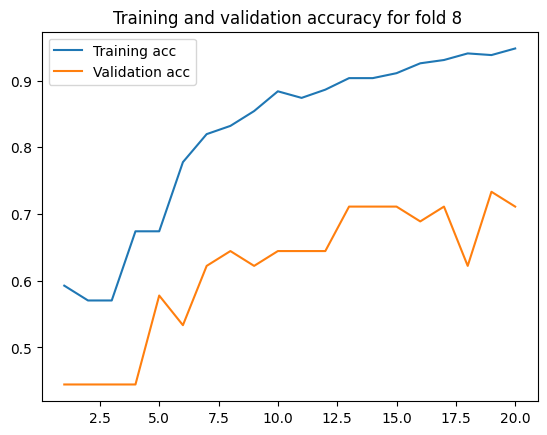

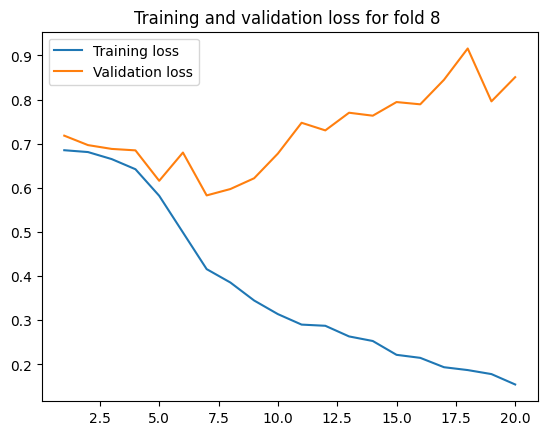

13/13 [==============================] - 4s 264ms/step
===== : TRAIN for fold 9 : =====
accuracy = 95.55555555555556
recall= 93.93939393939394
precision= 98.19004524886877
FAR= 2.2988505747126435
Fmeasure= 96.01769911504424


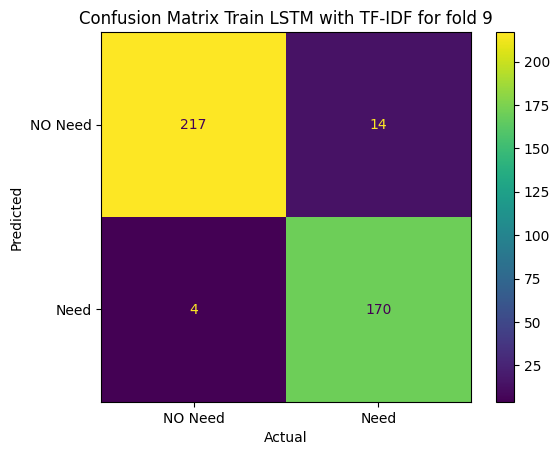

2/2 [==============================] - 0s 158ms/step
===== : TEST for fold 9 : =====
accuracy = 71.11111111111111
recall= 75.0
precision= 65.21739130434783
FAR= 32.0
Fmeasure= 69.76744186046511


<Figure size 640x480 with 0 Axes>

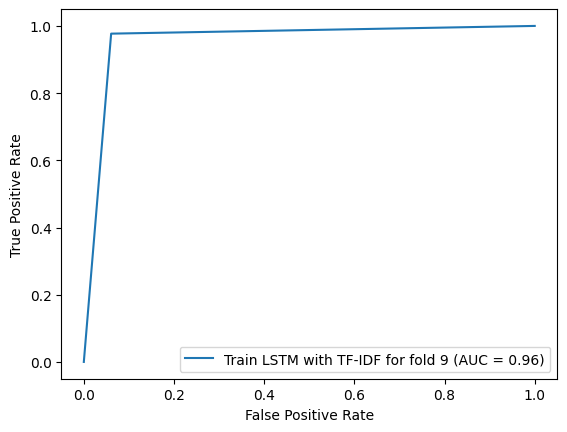

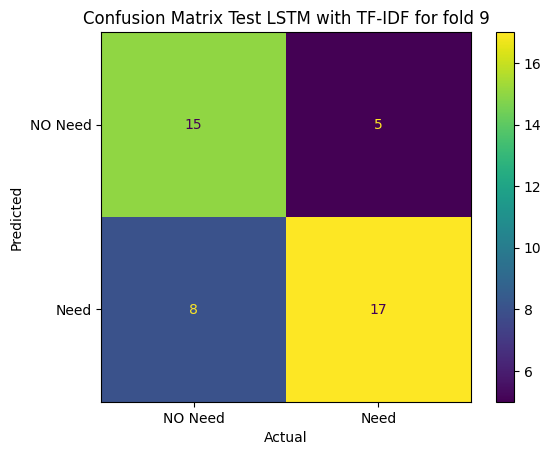

-----------------LSTM with TF-IDF-------------------------------
Training for fold 9 ...
Epoch 1/20
13/13 [==============================] - 24s 1s/step - loss: 0.6911 - accuracy: 0.5210 - val_loss: 0.6872 - val_accuracy: 0.5333
Epoch 2/20
13/13 [==============================] - 18s 1s/step - loss: 0.6824 - accuracy: 0.5605 - val_loss: 0.6807 - val_accuracy: 0.5333
Epoch 3/20
13/13 [==============================] - 17s 1s/step - loss: 0.6727 - accuracy: 0.5605 - val_loss: 0.6633 - val_accuracy: 0.5333
Epoch 4/20
13/13 [==============================] - 17s 1s/step - loss: 0.6496 - accuracy: 0.6148 - val_loss: 0.6092 - val_accuracy: 0.6222
Epoch 5/20
13/13 [==============================] - 17s 1s/step - loss: 0.5802 - accuracy: 0.6691 - val_loss: 0.4928 - val_accuracy: 0.7333
Epoch 6/20
13/13 [==============================] - 17s 1s/step - loss: 0.5129 - accuracy: 0.7358 - val_loss: 0.4433 - val_accuracy: 0.8000
Epoch 7/20
13/13 [==============================] - 17s 1s/step - loss:

<Figure size 640x480 with 0 Axes>

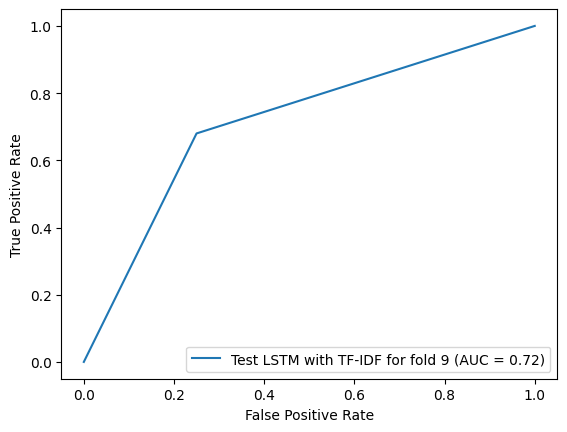

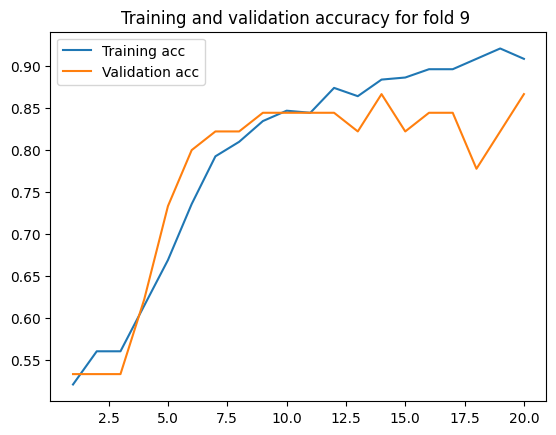

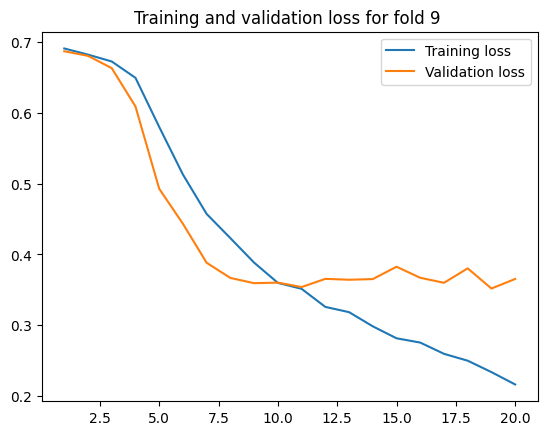

13/13 [==============================] - 5s 283ms/step
===== : TRAIN for fold 10 : =====
accuracy = 93.08641975308643
recall= 92.07048458149781
precision= 95.4337899543379
FAR= 5.617977528089887
Fmeasure= 93.72197309417041


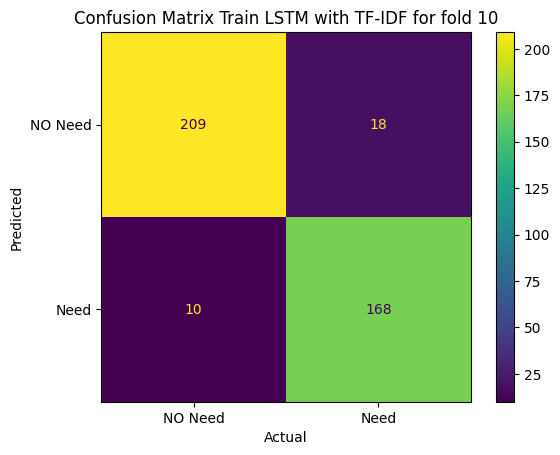

2/2 [==============================] - 0s 173ms/step
===== : TEST for fold 10 : =====
accuracy = 86.66666666666667
recall= 83.33333333333334
precision= 90.9090909090909
FAR= 9.523809523809524
Fmeasure= 86.95652173913044


<Figure size 640x480 with 0 Axes>

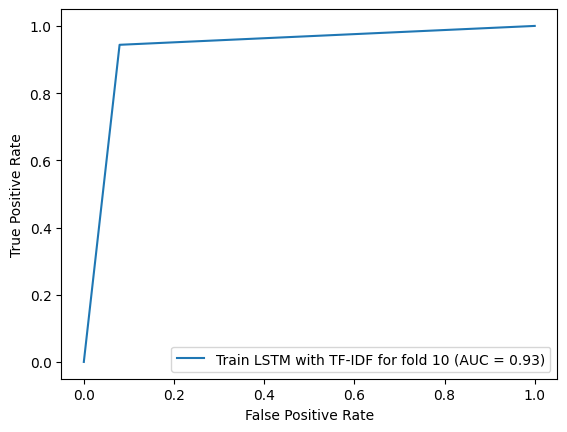

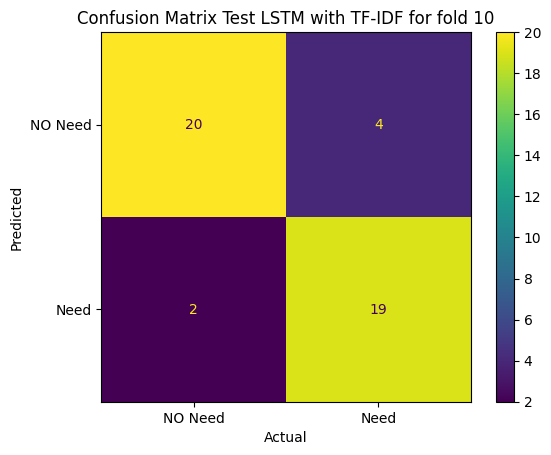

-----------------LSTM with TF-IDF-------------------------------
Training for fold 10 ...
Epoch 1/20
13/13 [==============================] - 22s 1s/step - loss: 0.6920 - accuracy: 0.5531 - val_loss: 0.6844 - val_accuracy: 0.5778
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.6891 - accuracy: 0.5556 - val_loss: 0.6809 - val_accuracy: 0.5778
Epoch 3/20
13/13 [==============================] - 16s 1s/step - loss: 0.6865 - accuracy: 0.5556 - val_loss: 0.6829 - val_accuracy: 0.5778
Epoch 4/20
13/13 [==============================] - 16s 1s/step - loss: 0.6869 - accuracy: 0.5556 - val_loss: 0.6793 - val_accuracy: 0.5778
Epoch 5/20
13/13 [==============================] - 16s 1s/step - loss: 0.6838 - accuracy: 0.5556 - val_loss: 0.6762 - val_accuracy: 0.5778
Epoch 6/20
13/13 [==============================] - 16s 1s/step - loss: 0.6810 - accuracy: 0.5556 - val_loss: 0.6693 - val_accuracy: 0.5778
Epoch 7/20
13/13 [==============================] - 16s 1s/step - loss

<Figure size 640x480 with 0 Axes>

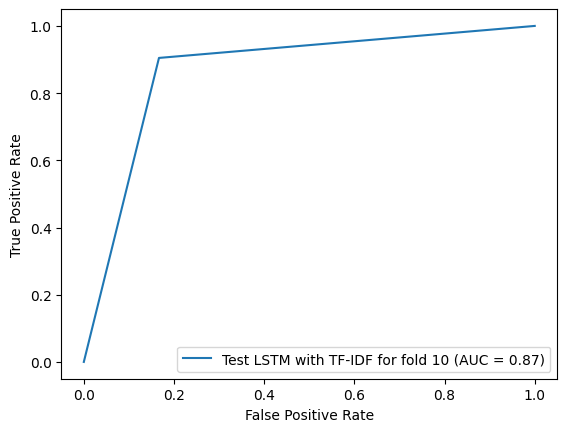

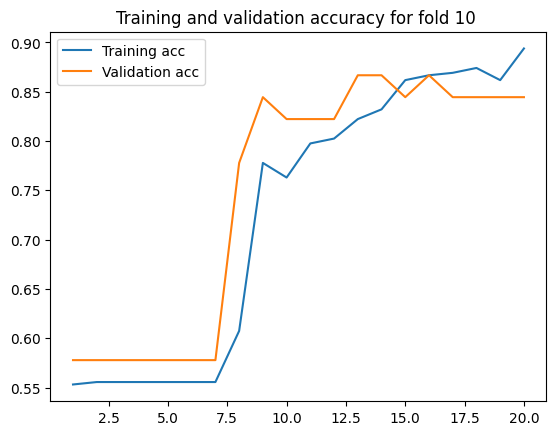

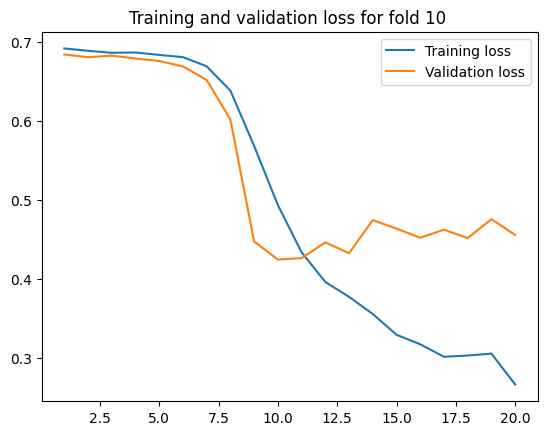

13/13 [==============================] - 5s 311ms/step
===== : TRAIN for fold 11 : =====
accuracy = 89.38271604938272
recall= 86.66666666666667
precision= 93.75
FAR= 7.222222222222221
Fmeasure= 90.06928406466513


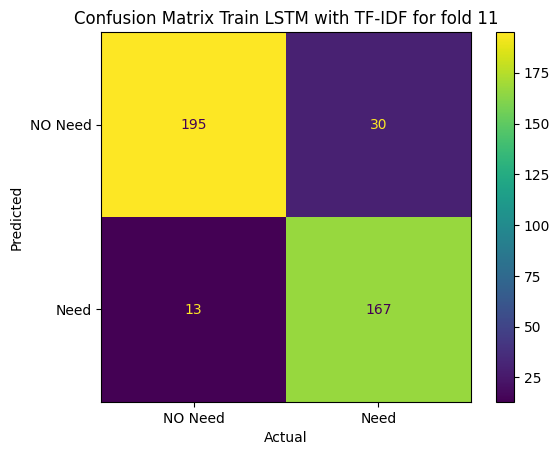

2/2 [==============================] - 1s 399ms/step
===== : TEST for fold 11 : =====
accuracy = 84.44444444444444
recall= 84.61538461538461
precision= 88.0
FAR= 15.789473684210526
Fmeasure= 86.27450980392156


<Figure size 640x480 with 0 Axes>

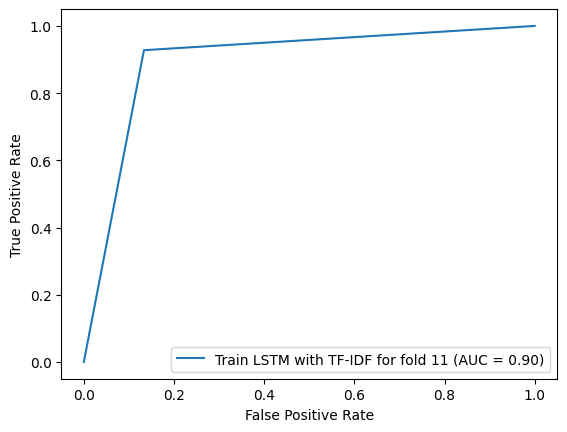

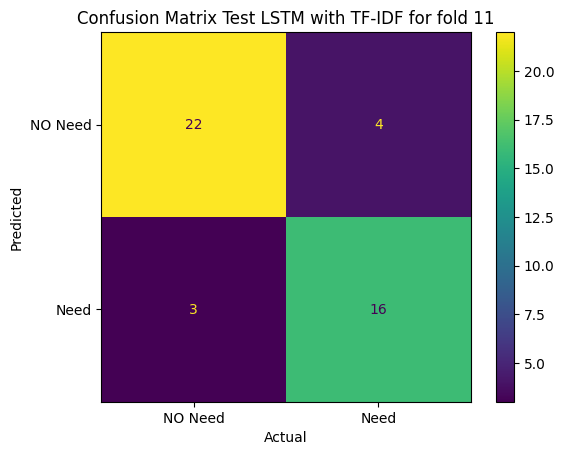

<Figure size 640x480 with 0 Axes>

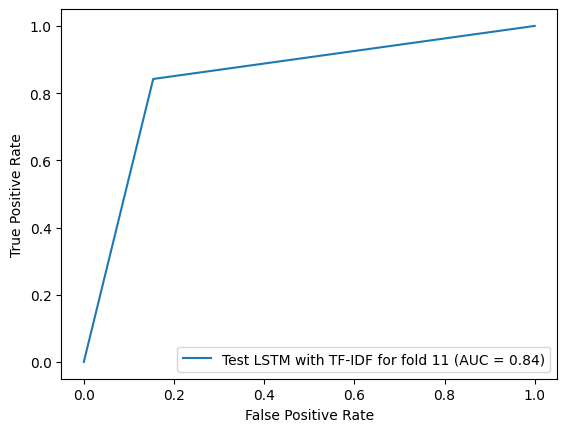

In [ ]:
#LSTM with TF-IDF by kfold

vectorizer = TfidfVectorizer().fit(df['text_Cleaned'])
tfidf_vector_X = vectorizer.transform(df['text_Cleaned']).toarray()  #//shape - (3,6)
tfidf_vector_X = tfidf_vector_X[:, :, None] #//shape - (3,6,1)

kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
acc2=[]
val_acc2=[]
loss2=[]
val_loss2=[]
recallTrain2=[]
recallTest2=[]
precTrain2=[]
precTest2=[]

for train, test in kfold.split(tfidf_vector_X, y1):
    model=Sequential()
    model.add(LSTM(units=10, input_shape = tfidf_vector_X.shape[1:], return_sequences = True))
    model.add(LSTM(units=10, return_sequences=True))
    model.add(Dense(10, activation = "relu")) #denselayer_2
    model.add(Dropout(0.1)) #dropout_3
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid')) #classification_layer
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Generate a print
    print('-----------------LSTM with TF-IDF-------------------------------')
    print(f'Training for fold {fold_no} ...')
    history =model.fit(tfidf_vector_X[train], y1[train],
              validation_data= (tfidf_vector_X[test], y1[test]),
              epochs= 20,verbose=1)

    acc2.append(history.history['accuracy'])
    val_acc2.append(history.history['val_accuracy'])
    loss2.append(history.history['loss'])
    val_loss2.append(history.history['val_loss'])
    epochs = range(1, 20 + 1)

    plt.figure()
    plt.plot(epochs, acc2[-1], label='Training acc')
    plt.plot(epochs, val_acc2[-1], label='Validation acc')
    plt.title(f'Training and validation accuracy for fold {fold_no} ')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, loss2[-1], label='Training loss')
    plt.plot(epochs, val_loss2[-1], label='Validation loss')
    plt.title(f'Training and validation loss for fold {fold_no} ')
    plt.legend()

    plt.show()
    # Increase fold number
    fold_no = fold_no + 1
    p_tr = (model.predict(tfidf_vector_X[train])>0.5).astype("int32")
    print(f"===== : TRAIN for fold {fold_no} : =====")
    mymetrics(y1[train],p_tr,f"Train LSTM with TF-IDF for fold {fold_no}")
    show_confusion_ROC(y1[train],p_tr,f'Train LSTM with TF-IDF for fold {fold_no}')
    p_te = (model.predict(tfidf_vector_X[test])>0.5).astype("int32")
    print(f"===== : TEST for fold {fold_no} : =====")
    mymetrics(y1[test],p_te,f'Test LSTM with TF-IDF for fold {fold_no}')
    show_confusion_ROC(y1[test],p_te,f'Test LSTM with TF-IDF for fold {fold_no}')
    prec,reca=precRecall(y1[train],p_tr)
    recallTrain2.append(reca)
    precTrain2.append(prec)
    prec,reca=precRecall(y1[test],p_te)
    recallTest2.append(reca)
    precTest2.append(prec)

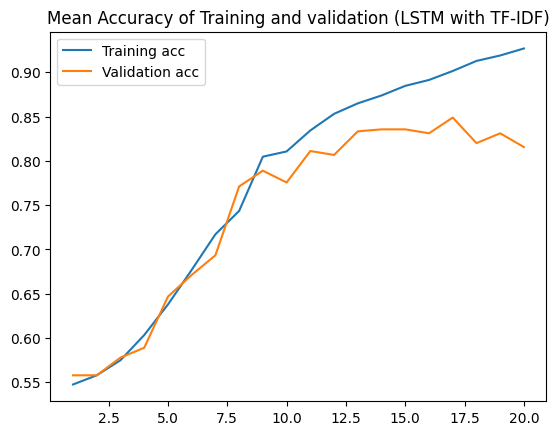

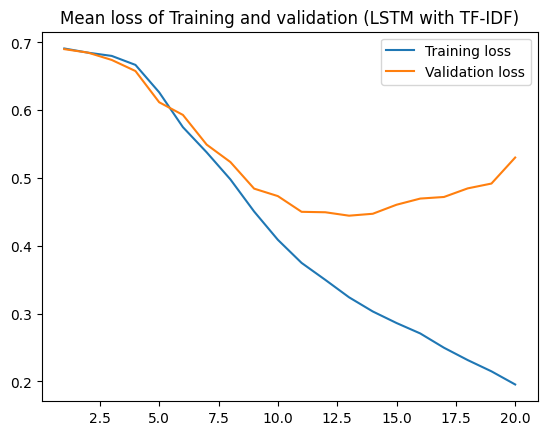

In [ ]:
accmean2=np.array(acc2).mean(axis=0)
val_accmean2=np.array(val_acc2).mean(axis=0)
lossmean2=np.array(loss2).mean(axis=0)
val_lossmean2=np.array(val_loss2).mean(axis=0)
plt.figure()
plt.plot(epochs, accmean2, label='Training acc')
plt.plot(epochs, val_accmean2, label='Validation acc')
plt.title('Mean Accuracy of Training and validation (LSTM with TF-IDF)')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, lossmean2, label='Training loss')
plt.plot(epochs, val_lossmean2, label='Validation loss')
plt.title('Mean loss of Training and validation (LSTM with TF-IDF)')
plt.legend()

plt.show()

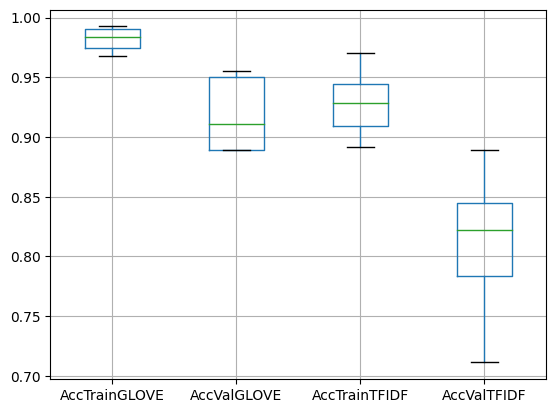

In [ ]:
dfacc = pd.DataFrame(np.c_[np.array(acc)[:,-1],np.array(val_acc)[:,-1],np.array(acc2)[:,-1],np.array(val_acc2)[:,-1]],
                  columns=['AccTrainGLOVE', 'AccValGLOVE', 'AccTrainTFIDF', 'AccValTFIDF'])
dfloss = pd.DataFrame(np.c_[np.array(loss)[:,-1],np.array(val_loss)[:,-1],np.array(loss2)[:,-1],np.array(val_loss2)[:,-1]],
                  columns=['LossTrainGLOVE', 'LossValGLOVE', 'LossTrainTFIDF', 'LossValTFIDF'])
boxplotacc = dfacc.boxplot(column=['AccTrainGLOVE', 'AccValGLOVE', 'AccTrainTFIDF', 'AccValTFIDF'])


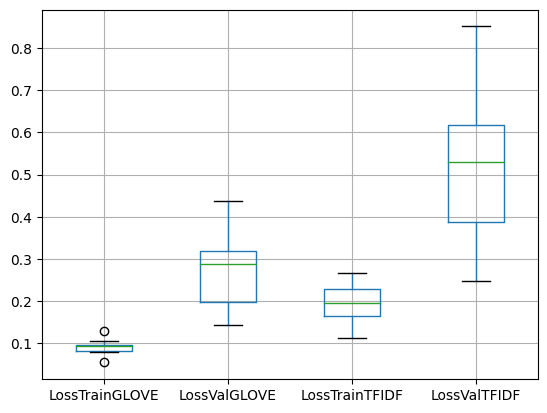

In [ ]:
boxplotloss = dfloss.boxplot(column=['LossTrainGLOVE', 'LossValGLOVE', 'LossTrainTFIDF', 'LossValTFIDF'])

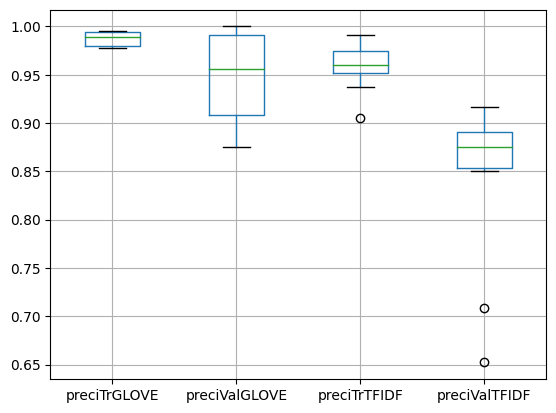

In [ ]:
dfprec = pd.DataFrame(np.c_[np.array(precTrain),np.array(precTest),np.array(precTrain2),np.array(precTest2)],
                  columns=['preciTrGLOVE', 'preciValGLOVE', 'preciTrTFIDF', 'preciValTFIDF'])
dfrecall = pd.DataFrame(np.c_[np.array(recallTrain),np.array(recallTest),np.array(recallTrain2),np.array(recallTest2)],
                  columns=['RecalTrGLOVE', 'RecalValGLOVE', 'RecalTrTFIDF', 'RecalValTFIDF'])
boxplotprec = dfprec.boxplot(column=['preciTrGLOVE', 'preciValGLOVE', 'preciTrTFIDF', 'preciValTFIDF'])

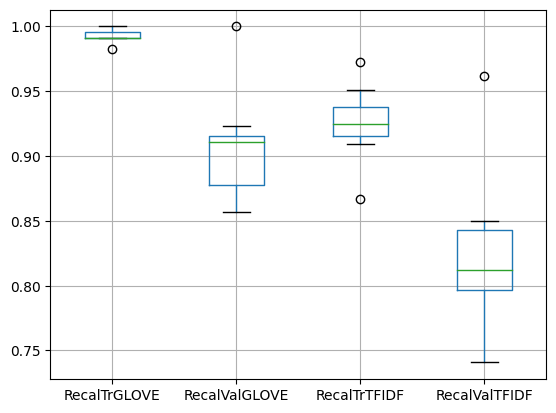

In [ ]:
boxplotrecall = dfrecall.boxplot(column=['RecalTrGLOVE', 'RecalValGLOVE', 'RecalTrTFIDF', 'RecalValTFIDF'])

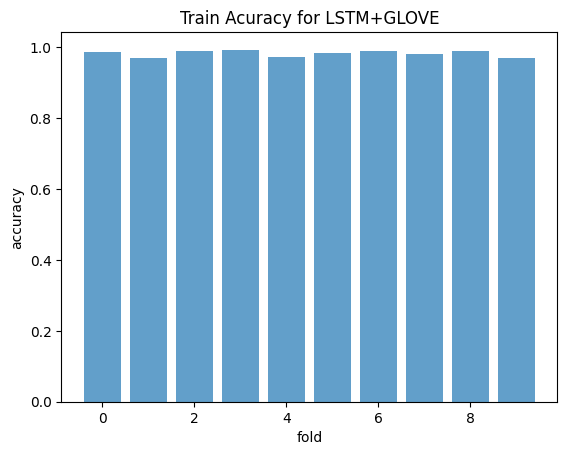

In [ ]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(acc)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Train Acuracy for LSTM+GLOVE')
plt.show()

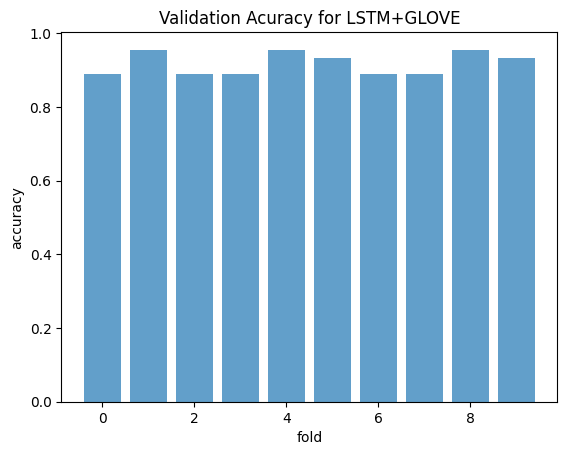

In [ ]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(val_acc)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Validation Acuracy for LSTM+GLOVE')
plt.show()

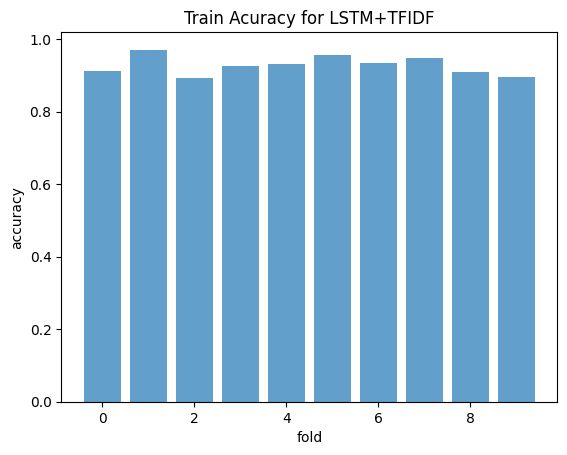

In [ ]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(acc2)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Train Acuracy for LSTM+TFIDF')
plt.show()

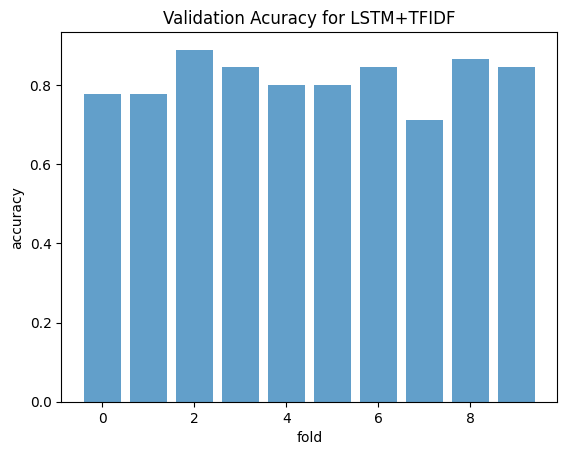

In [ ]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(val_acc2)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Validation Acuracy for LSTM+TFIDF')
plt.show()

In [13]:
df2['text_Cleaned'] = pd.DataFrame(df2['text'].apply(lambda y: clean1(y)))
df2.head()

text  target  injured  live  \
396  Flood Watch for Mitchell River to Glenaladale ...     0.0      0.0   0.0   
518  RT @vicsesnews: Flood Watch for Metung. For mo...     0.0      0.0   0.0   
700  Flood - EVACUATE NOW because Traralgon. For ne...     1.0      0.0   0.0   
635  EVACUATE NOW - RIVERINE FLOOD - Traralgon If y...     1.0      0.0   0.0   
308  RT @3AW693: If you live or work in the Traralg...     1.0      0.0   0.0   

     transmit                                       text_Cleaned  
396       0.0  flood watch for mitchell river to glenaladale ...  
518       0.0  rt  vicsesnews  flood watch for metung  for mo...  
700       1.0  flood   evacuate now because traralgon  for ne...  
635       1.0  evacuate now   riverine flood   traralgon if y...  
308       1.0  rt   aw     if you live or work in the traralg...

In [14]:
df2['text_Cleaned'].replace('[@+]', "", regex=True,inplace=True)
df2['text_Cleaned'].replace('[()]', "", regex=True,inplace=True)
df2['text_Cleaned']= df2['text_Cleaned'].replace('[#+]', "", regex=True)
url_regex = "((https?):((//)|(\\\\))+[\w\d:#@%/;$()~_?\+-=\\\.&]*)"
df2['text_Cleaned'] = df2['text_Cleaned'].replace(url_regex, "", regex=True)
df2['text_Cleaned'] = [nltk.word_tokenize(tweet) for tweet in df2['text_Cleaned']]
text_new=[]
for each_row in df2['text_Cleaned']:
    text_new.append([i for i in each_row if i.isalpha()])
stop_words = set(stopwords.words('english'))
text_new_alpha=[]
for each_row in text_new:
    text_new_alpha.append([i for i in each_row if i not in stop_words])

In [15]:
text_new_lemma = []
lemma = nltk.WordNetLemmatizer()
for each_row in text_new_alpha:
    text_new_lemma.append([lemma.lemmatize(word) for word in each_row])
df2['text_Cleaned'] = text_new_lemma
df2['text_Cleaned'] = [" ".join(desc) for desc in df2['text_Cleaned'].values]

In [16]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
df_n=df2[df2.target==1].reset_index(drop=True)


In [17]:
df_n=df2[df2.target==1].reset_index(drop=True)
y2=df_n[['injured','live','transmit']].values.astype(int)
y2

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0]])

In [18]:
text_new_lemma = [desc.split(" ") for desc in df_n['text_Cleaned'].values]
len(text_new_lemma)

351

In [19]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import multilabel_confusion_matrix

In [48]:
import seaborn as sns
def plot_confusion_matrix(confusion_matrix, class_names,nm, errors_only=False, figsize = (4,4), fontsize=10):
    fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)

    #Show errors only by filling diagonal with zeroes.
    if errors_only:
        np.fill_diagonal(confusion_matrix, 0)

    # ax2 - Confusion Matrix - Class Counts
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    heatmap = sns.heatmap(df_cm, ax=ax2, cmap='Blues', fmt='d', annot=True, annot_kws={"size": fontsize},
              linewidths=2, linecolor='black', cbar=False)

    ax2.tick_params(axis='x', labelrotation=0, labelsize=fontsize, labelcolor='black')
    ax2.tick_params(axis='y', labelrotation=0, labelsize=fontsize, labelcolor='black')
    #ax2.set_ylim(ax1.get_xlim()[0], ax1.get_xlim()[1])  #Fix bug in matplotlib 3.1.1.  Or, use earlier matplotlib.
    ax2.set_xlabel('PREDICTED CLASS', fontsize=fontsize, color='black')
    ax2.set_ylabel('TRUE CLASS', fontsize=fontsize, color='black')
    ax2.set_title(f'Confusion Matrix {nm} Class', pad=15, fontsize=fontsize, color='black')

# injured medical
# live
# transmit
class_labels = ["injMED", "live", "transmit"]

-----------------LSTM with GLOVE-------------------------------
Training for fold 1 ...
Epoch 1/20
10/10 [==============================] - 18s 659ms/step - loss: 0.6724 - accuracy: 0.3048 - val_loss: 0.6348 - val_accuracy: 0.3333
Epoch 2/20
10/10 [==============================] - 5s 543ms/step - loss: 0.6326 - accuracy: 0.3270 - val_loss: 0.5957 - val_accuracy: 0.3333
Epoch 3/20
10/10 [==============================] - 1s 116ms/step - loss: 0.6037 - accuracy: 0.3302 - val_loss: 0.5693 - val_accuracy: 0.3333
Epoch 4/20
10/10 [==============================] - 6s 658ms/step - loss: 0.5861 - accuracy: 0.3238 - val_loss: 0.5489 - val_accuracy: 0.3333
Epoch 5/20
10/10 [==============================] - 4s 388ms/step - loss: 0.5642 - accuracy: 0.3365 - val_loss: 0.5296 - val_accuracy: 0.3333
Epoch 6/20
10/10 [==============================] - 1s 76ms/step - loss: 0.5453 - accuracy: 0.3397 - val_loss: 0.5095 - val_accuracy: 0.3333
Epoch 7/20
10/10 [==============================] - 6s 654ms

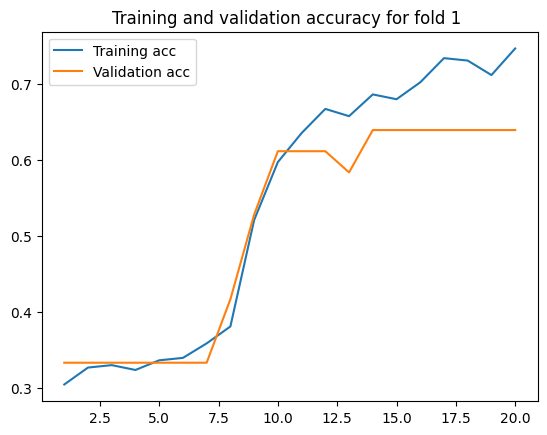

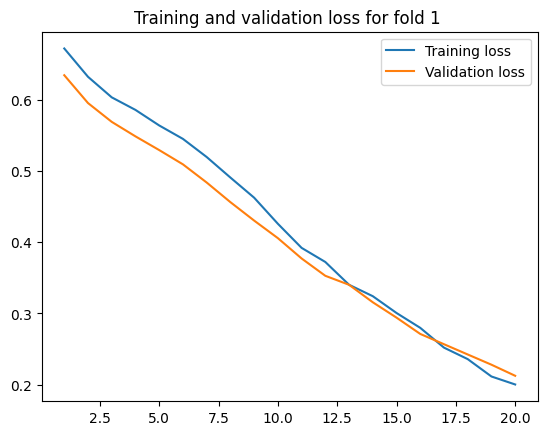

10/10 [==============================] - 1s 49ms/step
===== : TRAIN for fold 2 : =====
2/2 [==============================] - 0s 12ms/step
===== : TEST for fold 2 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 2 ...
Epoch 1/20
10/10 [==============================] - 14s 540ms/step - loss: 0.6825 - accuracy: 0.3703 - val_loss: 0.6658 - val_accuracy: 0.3714
Epoch 2/20
10/10 [==============================] - 6s 636ms/step - loss: 0.6512 - accuracy: 0.3703 - val_loss: 0.6236 - val_accuracy: 0.4286
Epoch 3/20
10/10 [==============================] - 2s 258ms/step - loss: 0.6024 - accuracy: 0.4905 - val_loss: 0.5652 - val_accuracy: 0.5714
Epoch 4/20
10/10 [==============================] - 6s 669ms/step - loss: 0.5592 - accuracy: 0.4589 - val_loss: 0.5086 - val_accuracy: 0.6000
Epoch 5/20
10/10 [==============================] - 2s 199ms/step - loss: 0.5167 - accuracy: 0.5285 - val_loss: 0.4668 - val_accuracy: 0.6286
Epoch 6/20
10/10 [============

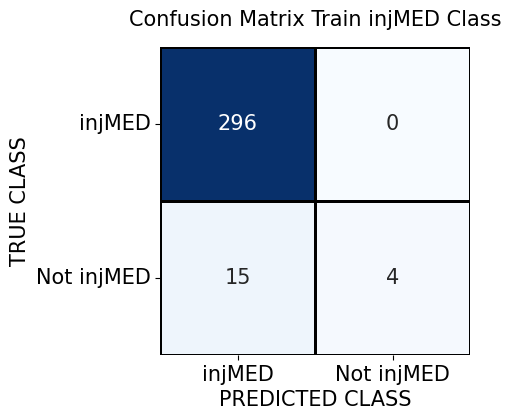

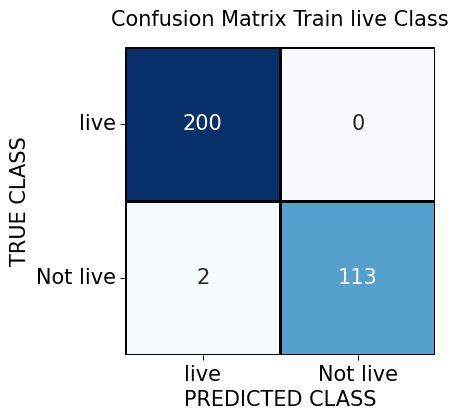

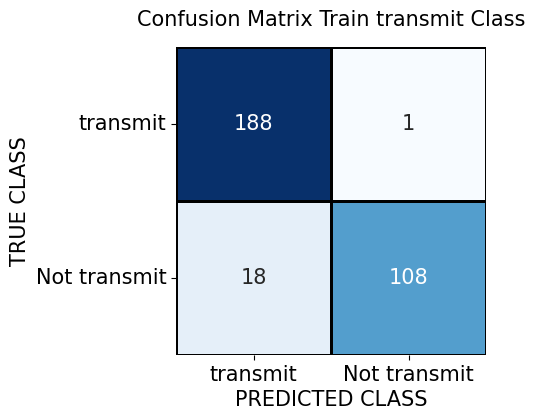

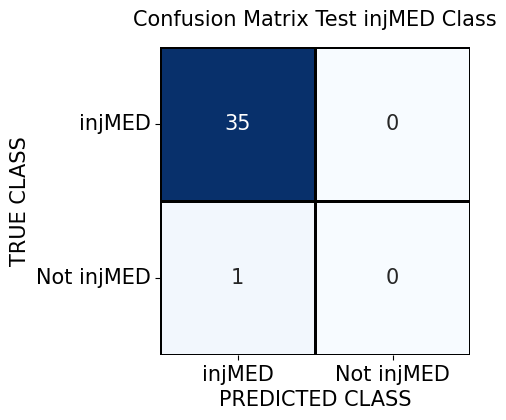

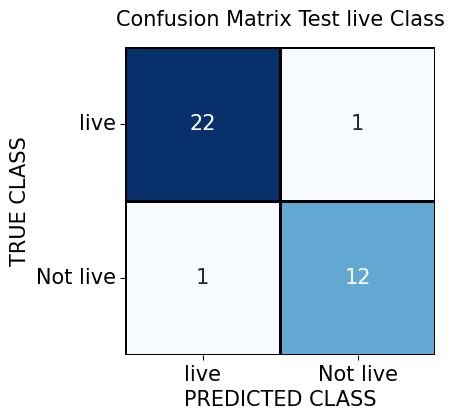

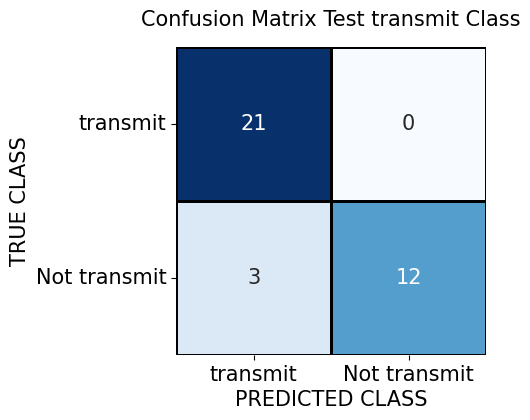

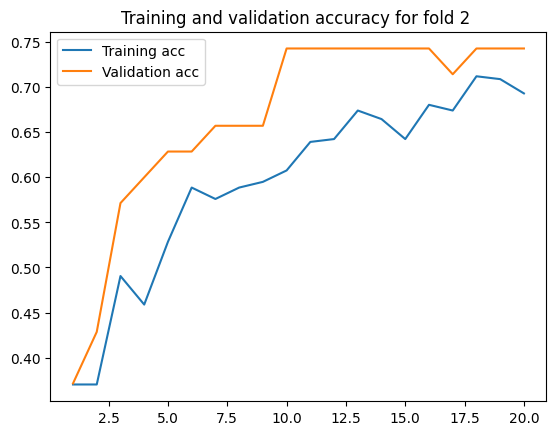

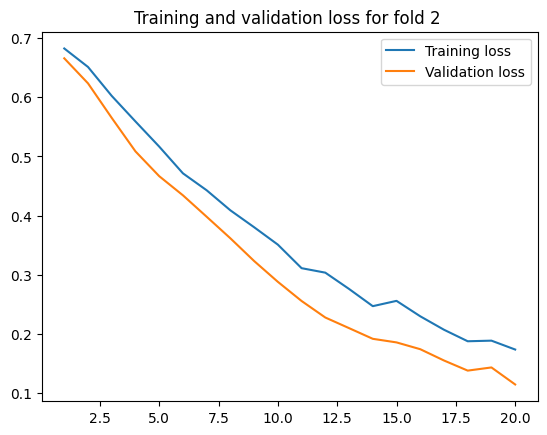

10/10 [==============================] - 1s 10ms/step
===== : TRAIN for fold 3 : =====
2/2 [==============================] - 0s 21ms/step
===== : TEST for fold 3 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 3 ...
Epoch 1/20
10/10 [==============================] - 12s 444ms/step - loss: 0.6825 - accuracy: 0.2595 - val_loss: 0.6495 - val_accuracy: 0.2857
Epoch 2/20
10/10 [==============================] - 2s 242ms/step - loss: 0.6173 - accuracy: 0.3892 - val_loss: 0.5866 - val_accuracy: 0.3143
Epoch 3/20
10/10 [==============================] - 1s 125ms/step - loss: 0.5777 - accuracy: 0.4114 - val_loss: 0.5419 - val_accuracy: 0.3429
Epoch 4/20
10/10 [==============================] - 5s 487ms/step - loss: 0.5499 - accuracy: 0.4146 - val_loss: 0.5112 - val_accuracy: 0.3714
Epoch 5/20
10/10 [==============================] - 4s 396ms/step - loss: 0.5351 - accuracy: 0.4399 - val_loss: 0.4868 - val_accuracy: 0.5429
Epoch 6/20
10/10 [============

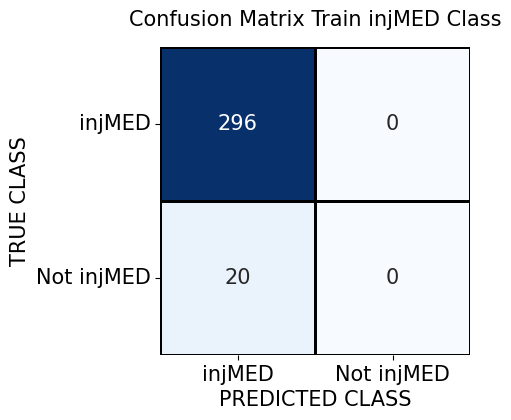

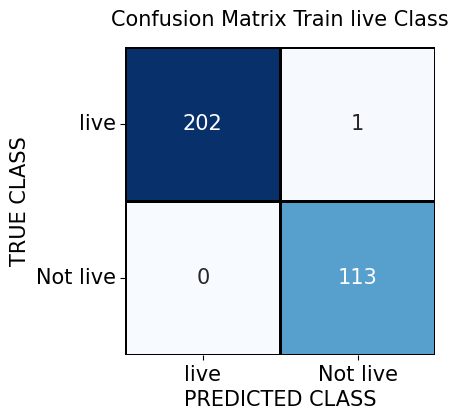

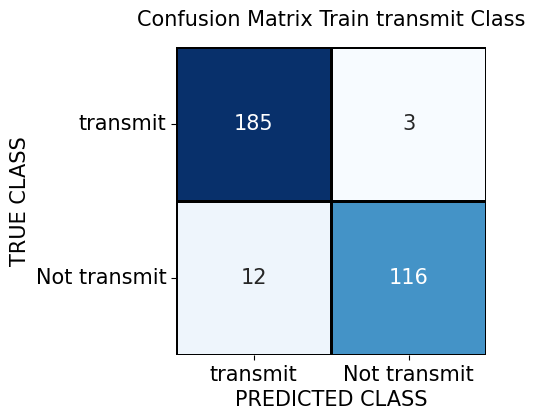

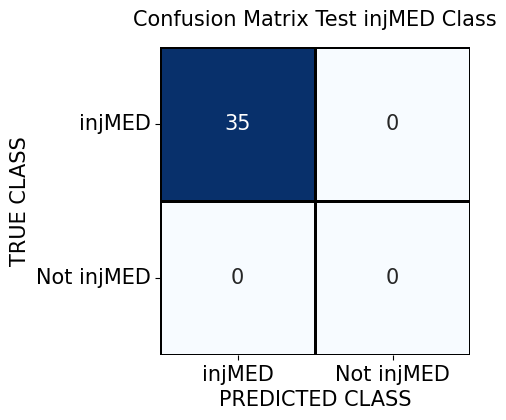

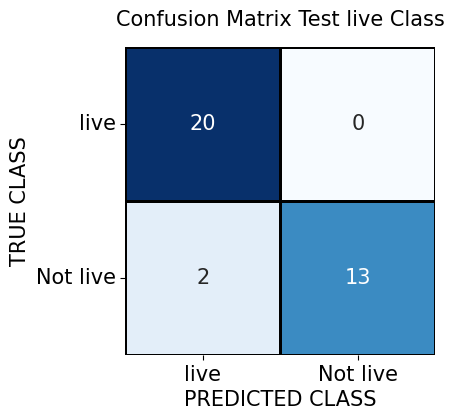

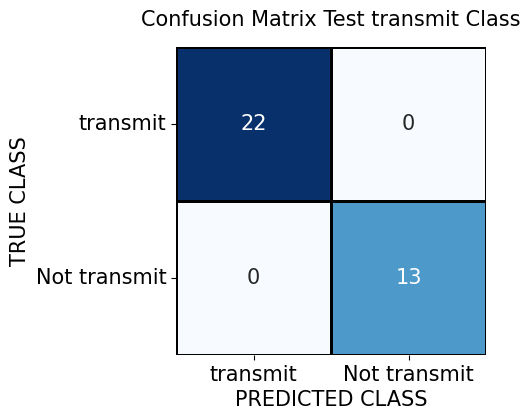

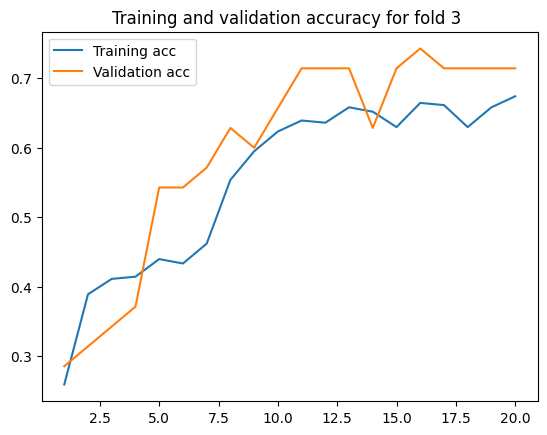

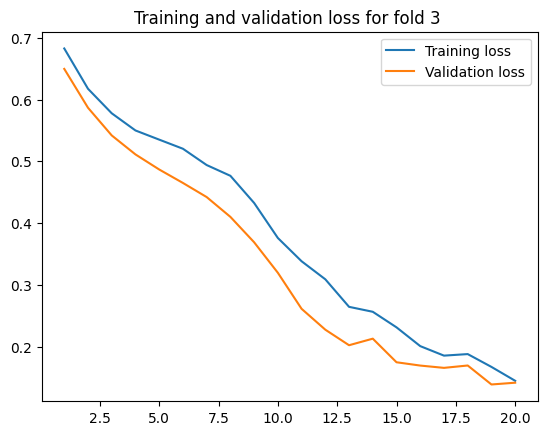

10/10 [==============================] - 1s 12ms/step
===== : TRAIN for fold 4 : =====
2/2 [==============================] - 0s 16ms/step
===== : TEST for fold 4 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 4 ...
Epoch 1/20
10/10 [==============================] - 10s 222ms/step - loss: 0.6638 - accuracy: 0.2975 - val_loss: 0.6261 - val_accuracy: 0.3143
Epoch 2/20
10/10 [==============================] - 6s 657ms/step - loss: 0.6059 - accuracy: 0.3259 - val_loss: 0.5809 - val_accuracy: 0.3429
Epoch 3/20
10/10 [==============================] - 2s 121ms/step - loss: 0.5666 - accuracy: 0.3481 - val_loss: 0.5513 - val_accuracy: 0.3429
Epoch 4/20
10/10 [==============================] - 5s 535ms/step - loss: 0.5355 - accuracy: 0.3608 - val_loss: 0.5356 - val_accuracy: 0.3429
Epoch 5/20
10/10 [==============================] - 6s 702ms/step - loss: 0.5152 - accuracy: 0.3987 - val_loss: 0.5217 - val_accuracy: 0.3429
Epoch 6/20
10/10 [============

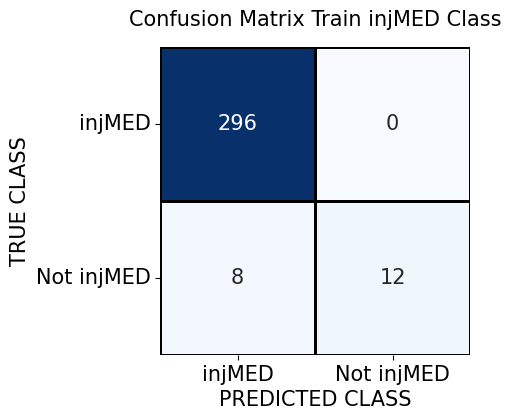

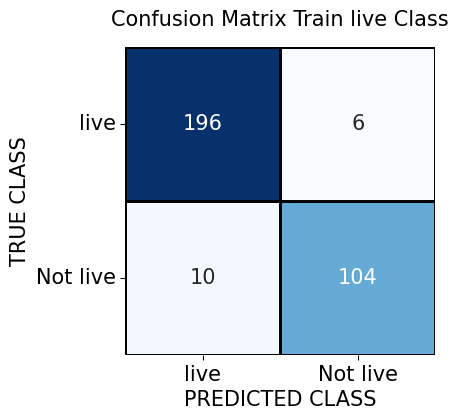

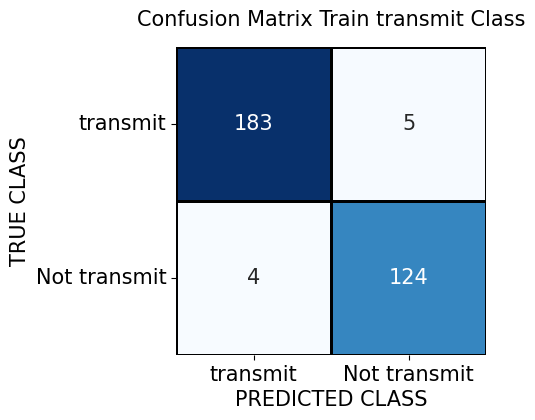

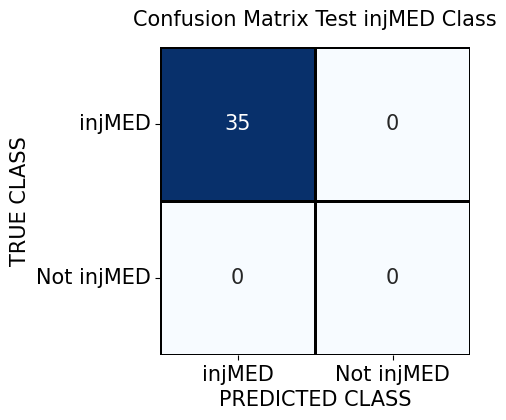

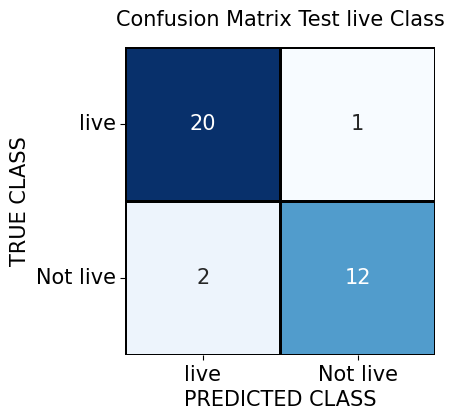

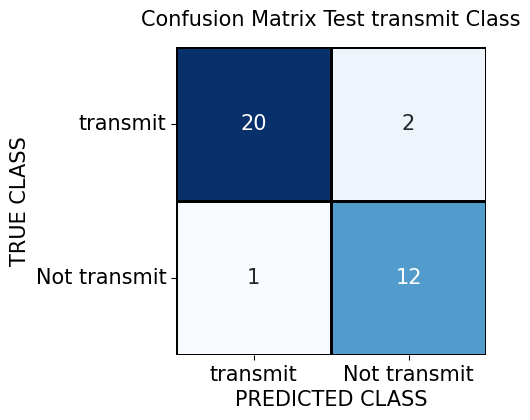

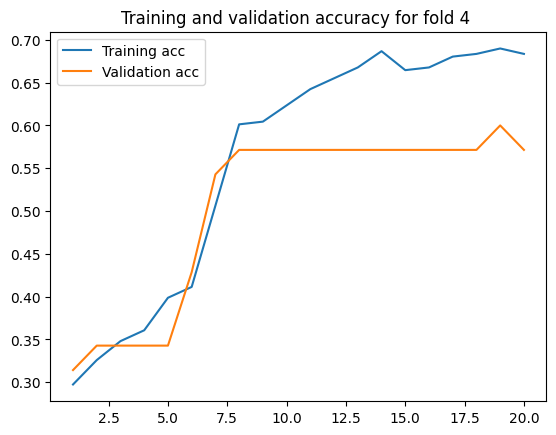

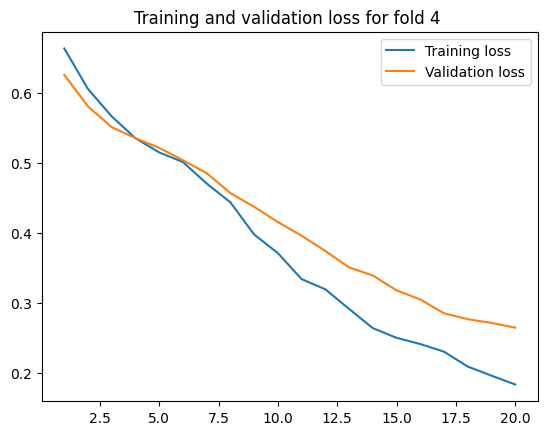

10/10 [==============================] - 2s 144ms/step
===== : TRAIN for fold 5 : =====
2/2 [==============================] - 1s 878ms/step
===== : TEST for fold 5 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 5 ...
Epoch 1/20
10/10 [==============================] - 11s 256ms/step - loss: 0.6398 - accuracy: 0.2880 - val_loss: 0.5898 - val_accuracy: 0.3429
Epoch 2/20
10/10 [==============================] - 5s 486ms/step - loss: 0.5720 - accuracy: 0.3829 - val_loss: 0.5180 - val_accuracy: 0.3714
Epoch 3/20
10/10 [==============================] - 1s 124ms/step - loss: 0.5242 - accuracy: 0.4177 - val_loss: 0.4780 - val_accuracy: 0.4571
Epoch 4/20
10/10 [==============================] - 2s 240ms/step - loss: 0.4970 - accuracy: 0.4620 - val_loss: 0.4599 - val_accuracy: 0.4571
Epoch 5/20
10/10 [==============================] - 5s 573ms/step - loss: 0.4854 - accuracy: 0.4430 - val_loss: 0.4456 - val_accuracy: 0.5143
Epoch 6/20
10/10 [==========

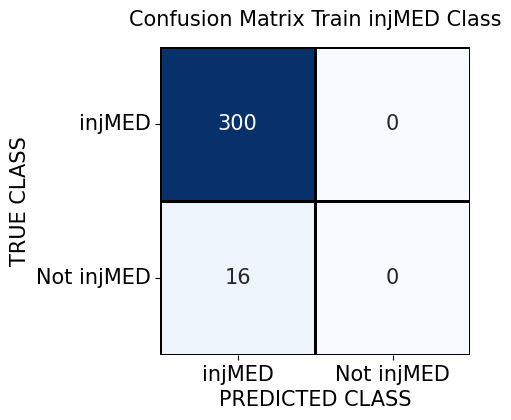

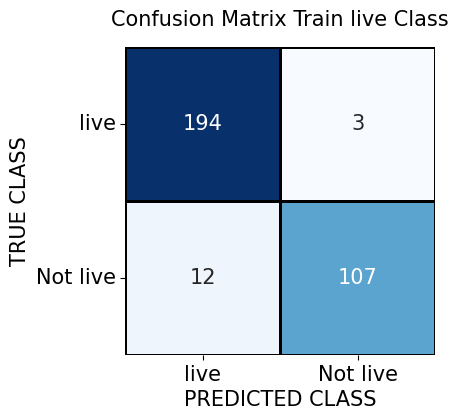

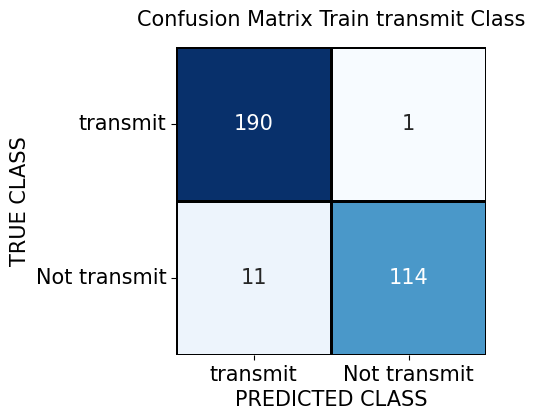

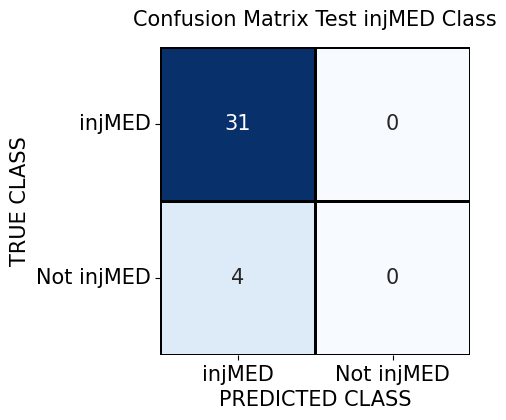

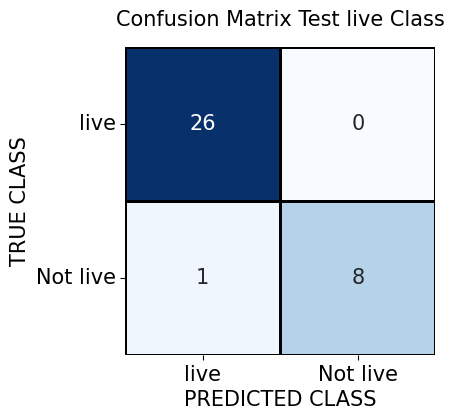

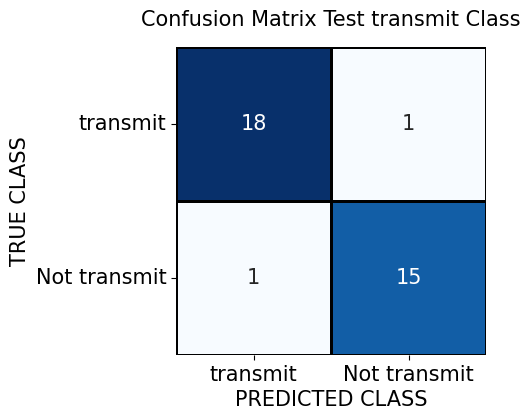

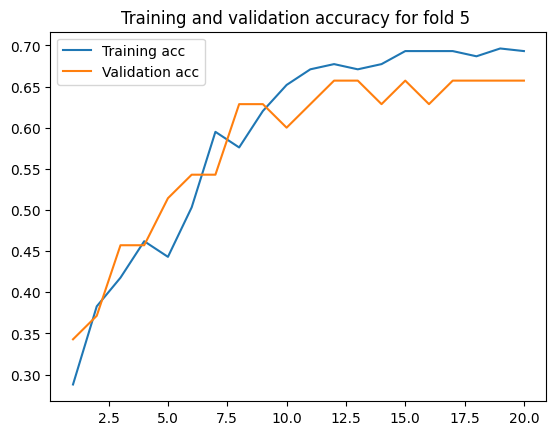

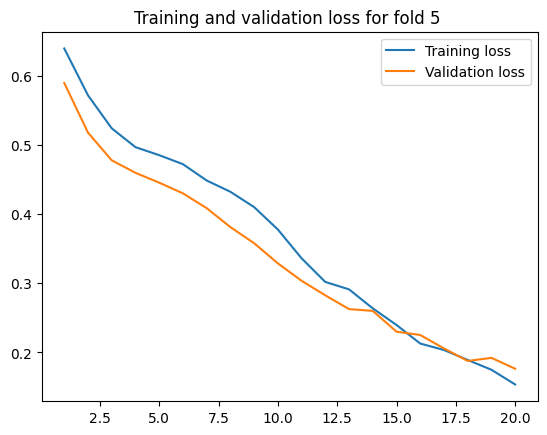

10/10 [==============================] - 2s 174ms/step
===== : TRAIN for fold 6 : =====
2/2 [==============================] - 0s 41ms/step
===== : TEST for fold 6 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 6 ...
Epoch 1/20
10/10 [==============================] - 16s 545ms/step - loss: 0.7014 - accuracy: 0.3291 - val_loss: 0.6783 - val_accuracy: 0.3714
Epoch 2/20
10/10 [==============================] - 5s 497ms/step - loss: 0.6730 - accuracy: 0.3924 - val_loss: 0.6686 - val_accuracy: 0.2571
Epoch 3/20
10/10 [==============================] - 7s 757ms/step - loss: 0.6520 - accuracy: 0.4557 - val_loss: 0.6580 - val_accuracy: 0.3143
Epoch 4/20
10/10 [==============================] - 2s 217ms/step - loss: 0.6236 - accuracy: 0.4241 - val_loss: 0.6412 - val_accuracy: 0.2857
Epoch 5/20
10/10 [==============================] - 1s 112ms/step - loss: 0.5965 - accuracy: 0.3987 - val_loss: 0.6228 - val_accuracy: 0.3429
Epoch 6/20
10/10 [===========

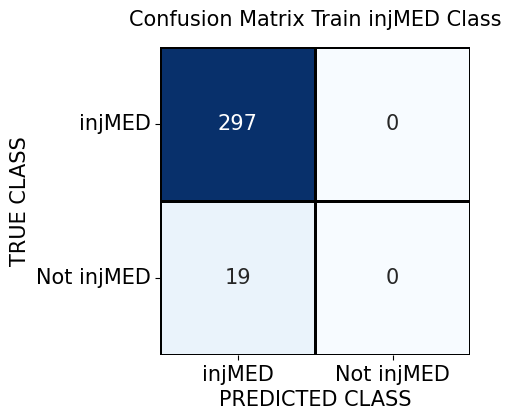

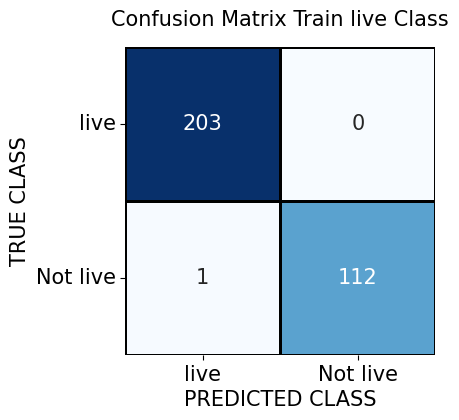

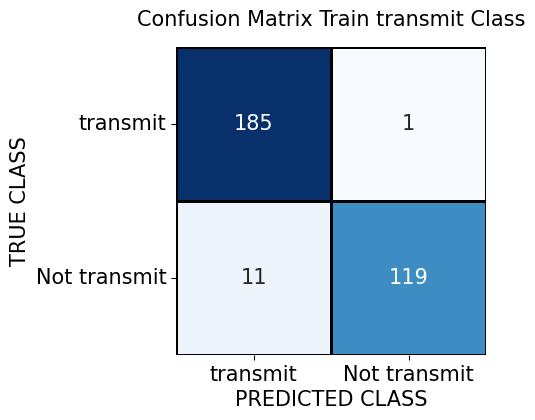

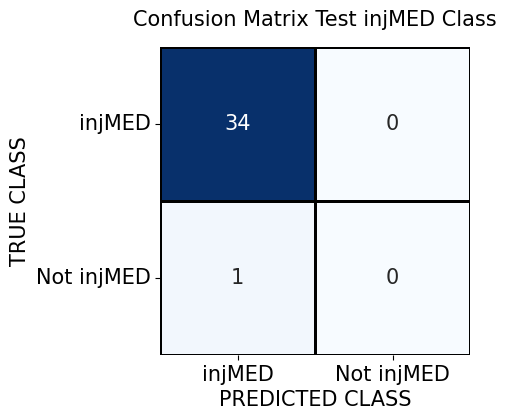

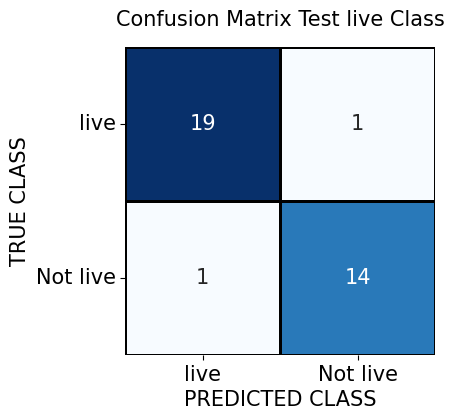

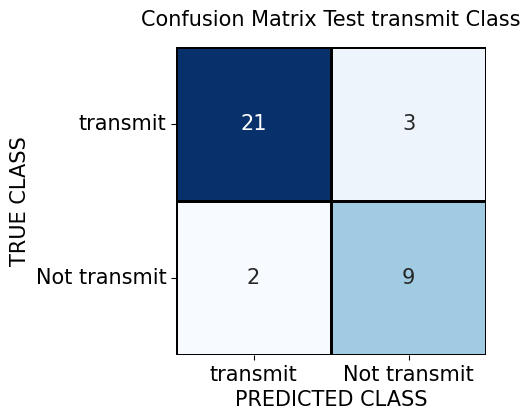

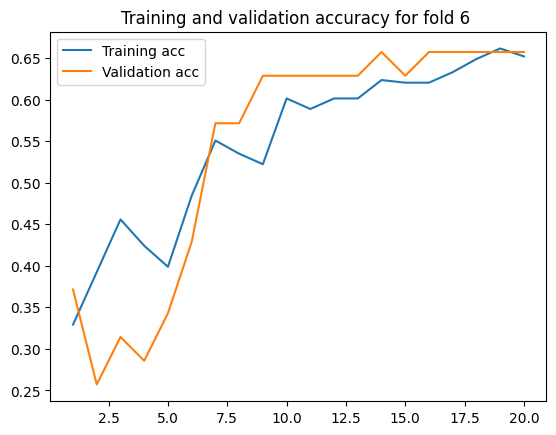

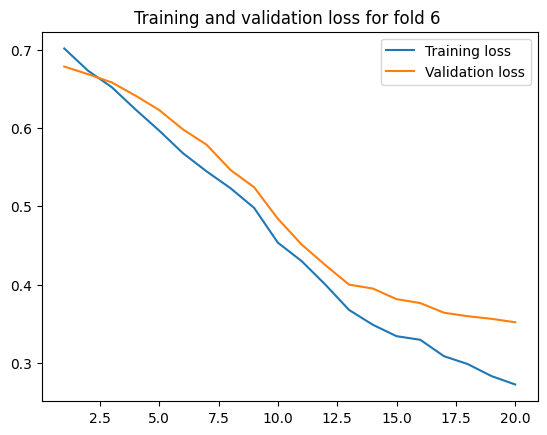

10/10 [==============================] - 3s 204ms/step
===== : TRAIN for fold 7 : =====
2/2 [==============================] - 1s 801ms/step
===== : TEST for fold 7 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 7 ...
Epoch 1/20
10/10 [==============================] - 13s 534ms/step - loss: 0.6757 - accuracy: 0.4494 - val_loss: 0.6503 - val_accuracy: 0.4286
Epoch 2/20
10/10 [==============================] - 2s 217ms/step - loss: 0.6306 - accuracy: 0.4399 - val_loss: 0.6107 - val_accuracy: 0.4000
Epoch 3/20
10/10 [==============================] - 5s 546ms/step - loss: 0.5905 - accuracy: 0.3861 - val_loss: 0.5719 - val_accuracy: 0.3429
Epoch 4/20
10/10 [==============================] - 5s 551ms/step - loss: 0.5500 - accuracy: 0.4304 - val_loss: 0.5315 - val_accuracy: 0.4286
Epoch 5/20
10/10 [==============================] - 2s 226ms/step - loss: 0.5119 - accuracy: 0.4937 - val_loss: 0.4896 - val_accuracy: 0.6286
Epoch 6/20
10/10 [==========

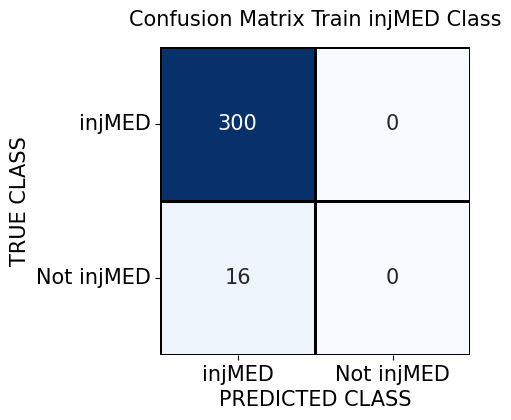

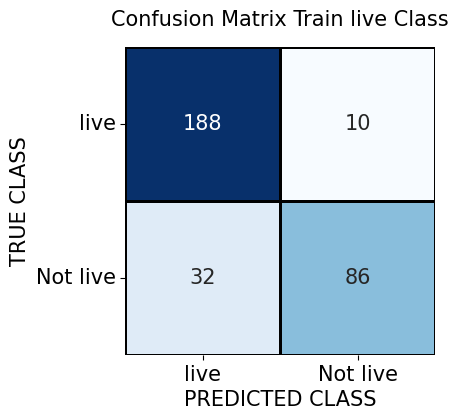

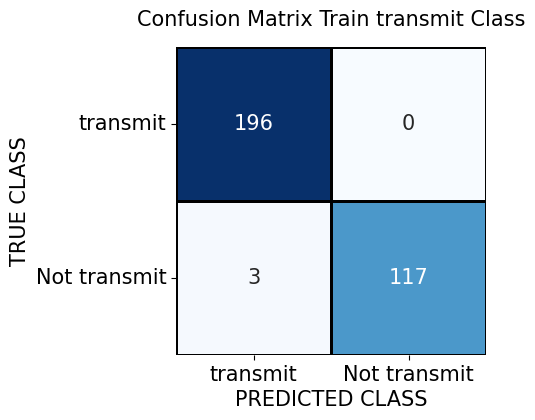

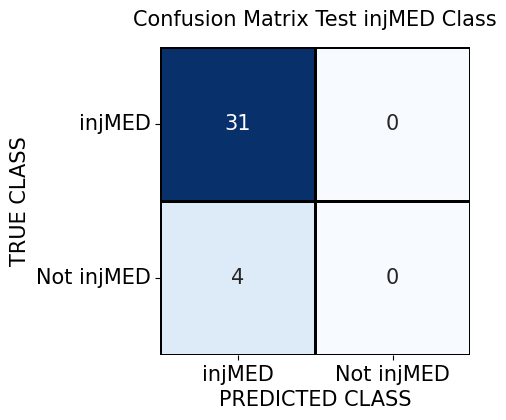

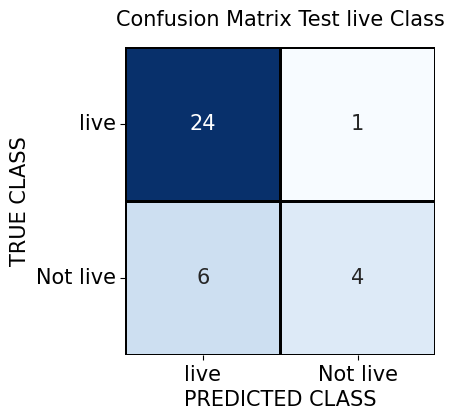

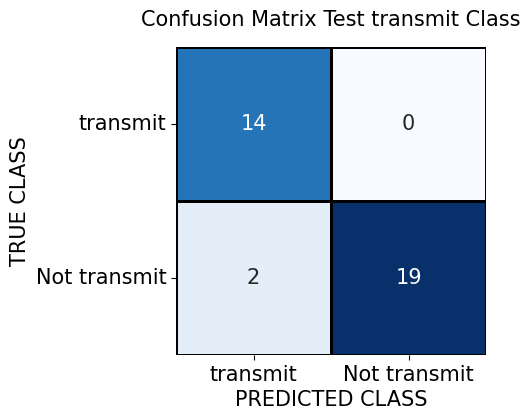

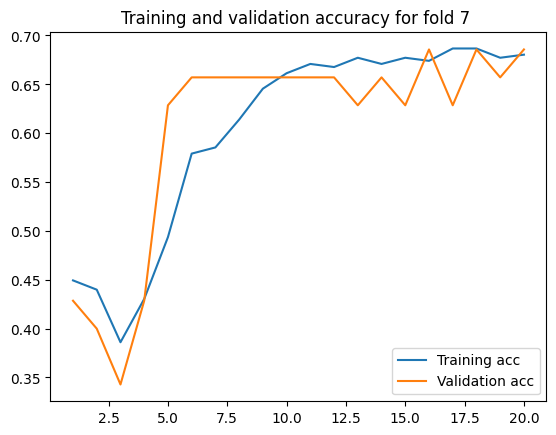

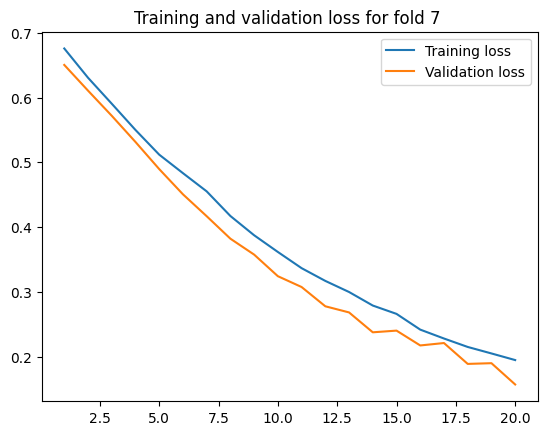

10/10 [==============================] - 1s 14ms/step
===== : TRAIN for fold 8 : =====
2/2 [==============================] - 1s 920ms/step
===== : TEST for fold 8 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 8 ...
Epoch 1/20
10/10 [==============================] - 14s 518ms/step - loss: 0.6839 - accuracy: 0.3513 - val_loss: 0.6696 - val_accuracy: 0.3429
Epoch 2/20
10/10 [==============================] - 1s 129ms/step - loss: 0.6436 - accuracy: 0.3766 - val_loss: 0.6297 - val_accuracy: 0.3429
Epoch 3/20
10/10 [==============================] - 4s 413ms/step - loss: 0.6047 - accuracy: 0.3639 - val_loss: 0.5945 - val_accuracy: 0.3429
Epoch 4/20
10/10 [==============================] - 1s 130ms/step - loss: 0.5678 - accuracy: 0.3956 - val_loss: 0.5649 - val_accuracy: 0.3714
Epoch 5/20
10/10 [==============================] - 6s 601ms/step - loss: 0.5380 - accuracy: 0.4019 - val_loss: 0.5302 - val_accuracy: 0.5143
Epoch 6/20
10/10 [===========

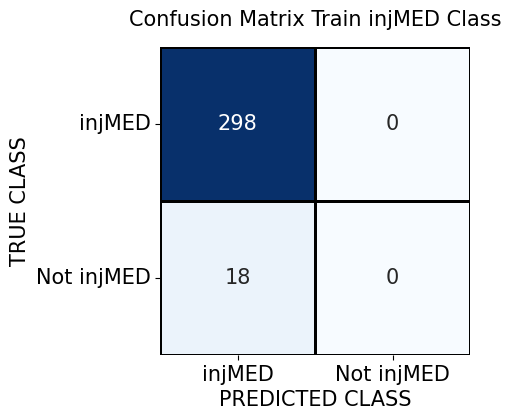

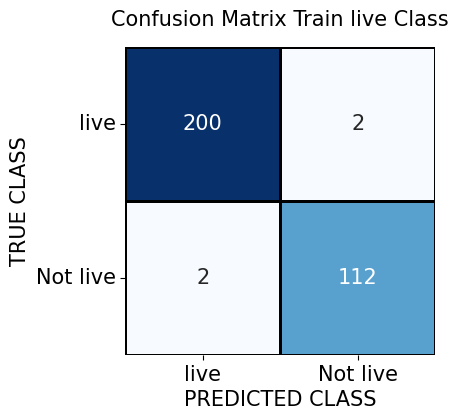

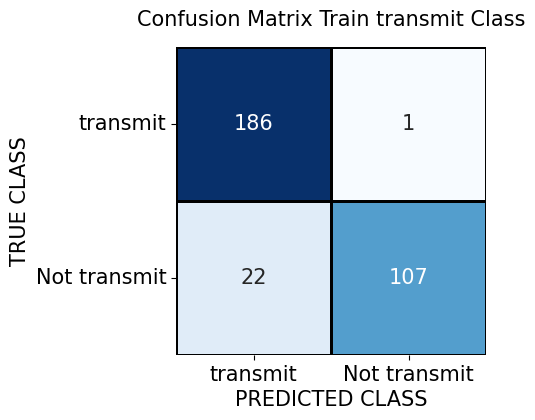

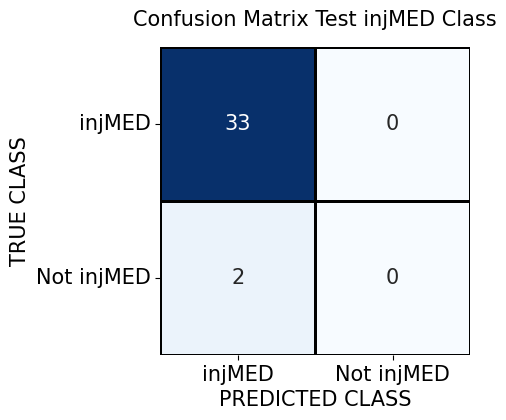

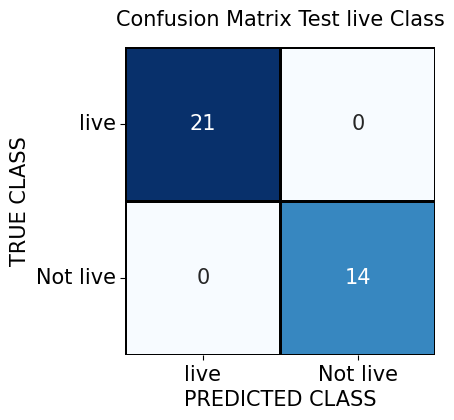

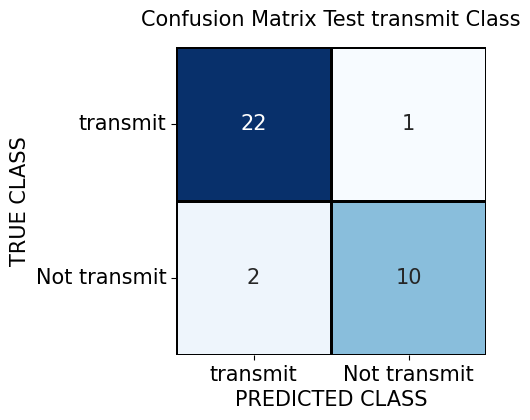

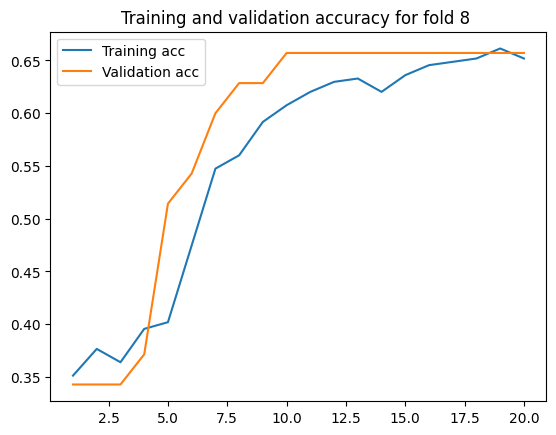

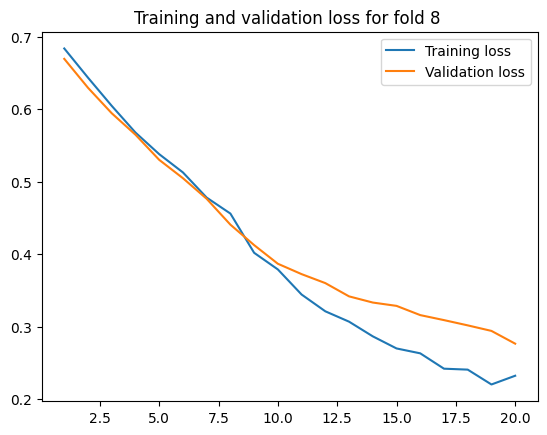

10/10 [==============================] - 2s 139ms/step
===== : TRAIN for fold 9 : =====
2/2 [==============================] - 1s 569ms/step
===== : TEST for fold 9 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 9 ...
Epoch 1/20
10/10 [==============================] - 14s 704ms/step - loss: 0.6738 - accuracy: 0.3892 - val_loss: 0.6598 - val_accuracy: 0.3714
Epoch 2/20
10/10 [==============================] - 6s 641ms/step - loss: 0.6416 - accuracy: 0.3766 - val_loss: 0.6379 - val_accuracy: 0.3429
Epoch 3/20
10/10 [==============================] - 1s 122ms/step - loss: 0.6253 - accuracy: 0.3703 - val_loss: 0.6256 - val_accuracy: 0.3429
Epoch 4/20
10/10 [==============================] - 8s 904ms/step - loss: 0.6100 - accuracy: 0.3671 - val_loss: 0.6045 - val_accuracy: 0.3429
Epoch 5/20
10/10 [==============================] - 2s 184ms/step - loss: 0.5863 - accuracy: 0.4209 - val_loss: 0.5760 - val_accuracy: 0.4286
Epoch 6/20
10/10 [==========

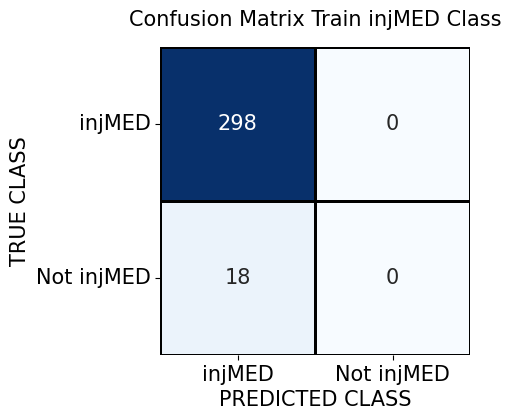

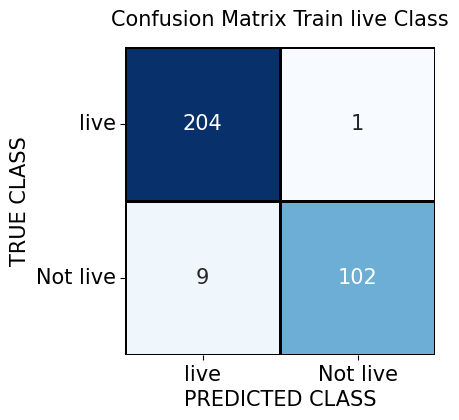

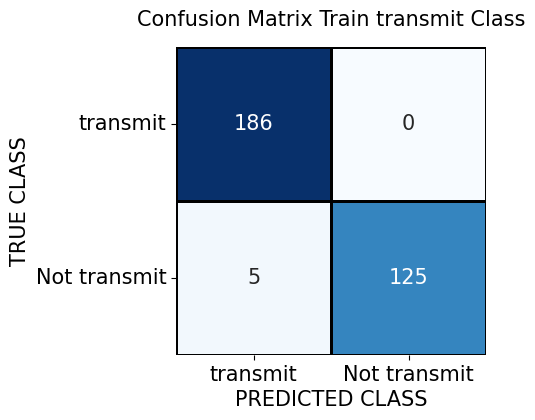

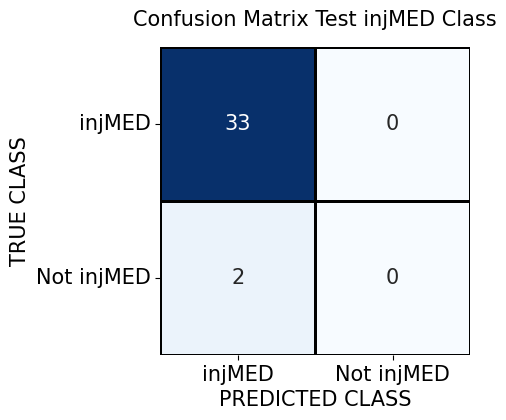

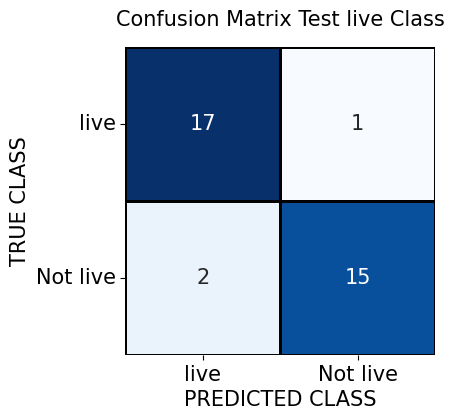

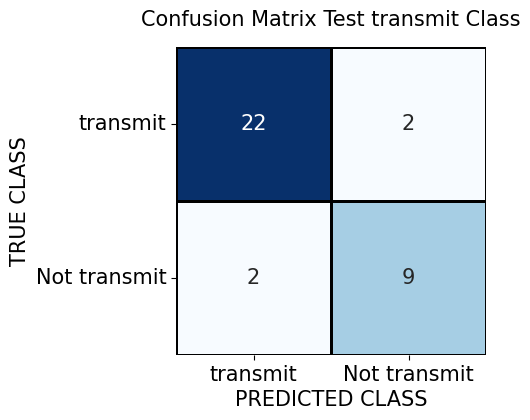

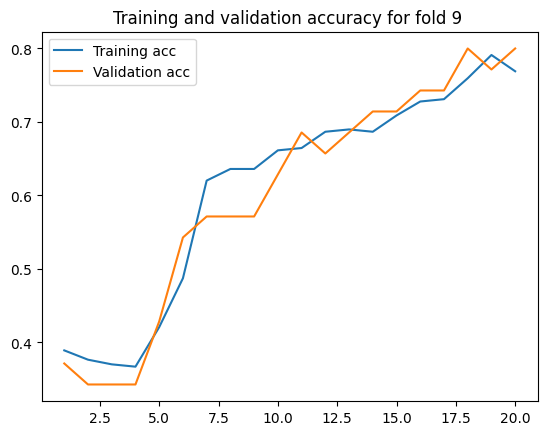

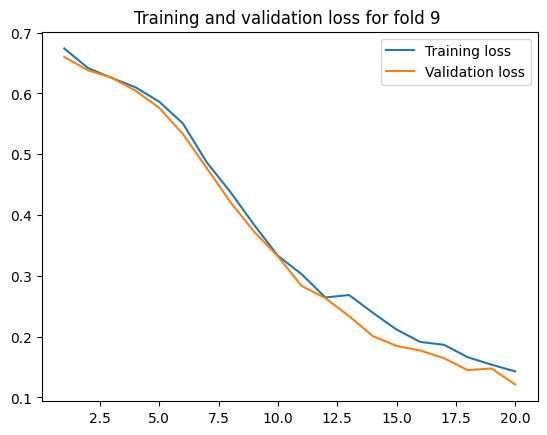

10/10 [==============================] - 2s 132ms/step
===== : TRAIN for fold 10 : =====
2/2 [==============================] - 0s 254ms/step
===== : TEST for fold 10 : =====
-----------------LSTM with GLOVE-------------------------------
Training for fold 10 ...
Epoch 1/20
10/10 [==============================] - 11s 303ms/step - loss: 0.6591 - accuracy: 0.3165 - val_loss: 0.6236 - val_accuracy: 0.3714
Epoch 2/20
10/10 [==============================] - 5s 535ms/step - loss: 0.6032 - accuracy: 0.3513 - val_loss: 0.5764 - val_accuracy: 0.3714
Epoch 3/20
10/10 [==============================] - 5s 506ms/step - loss: 0.5617 - accuracy: 0.3734 - val_loss: 0.5473 - val_accuracy: 0.4000
Epoch 4/20
10/10 [==============================] - 2s 223ms/step - loss: 0.5297 - accuracy: 0.3987 - val_loss: 0.5288 - val_accuracy: 0.4286
Epoch 5/20
10/10 [==============================] - 1s 128ms/step - loss: 0.5190 - accuracy: 0.3861 - val_loss: 0.5153 - val_accuracy: 0.4286
Epoch 6/20
10/10 [=======

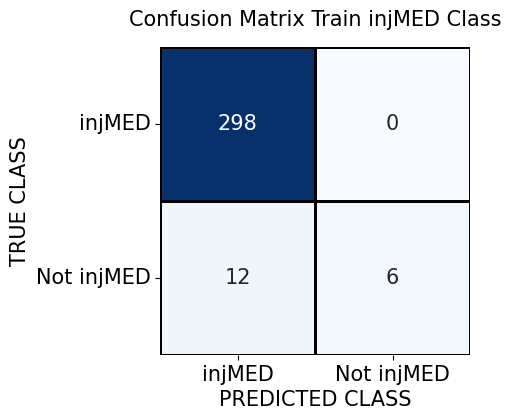

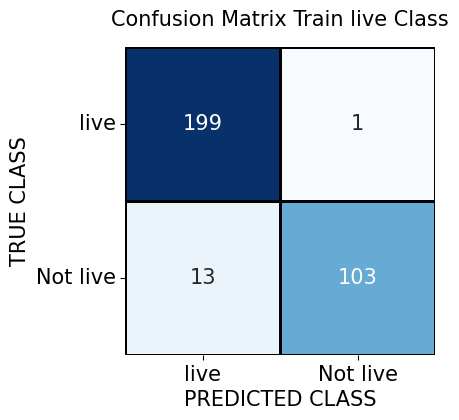

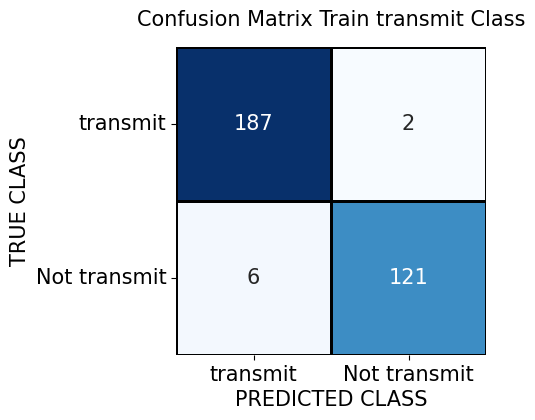

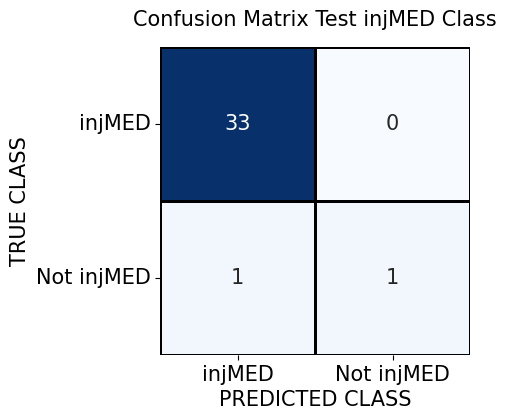

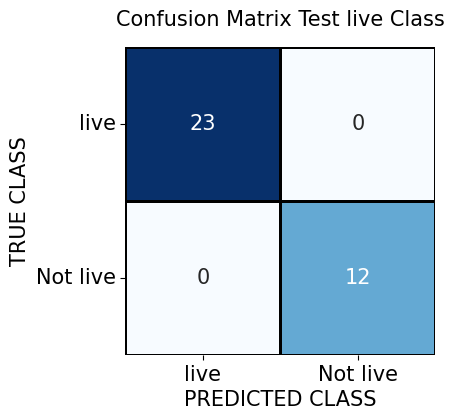

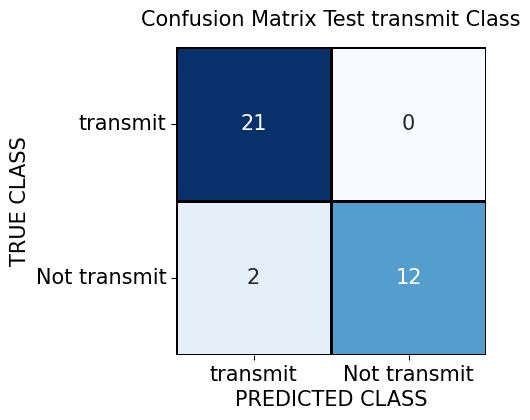

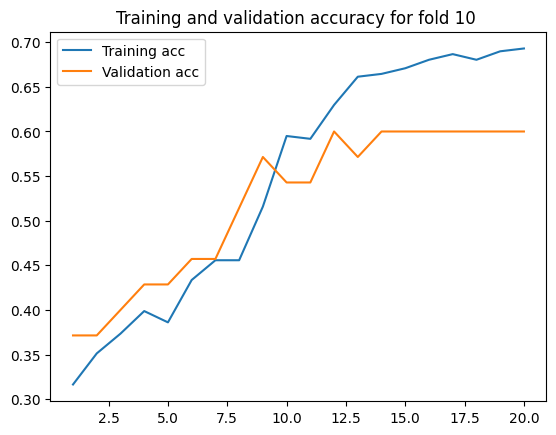

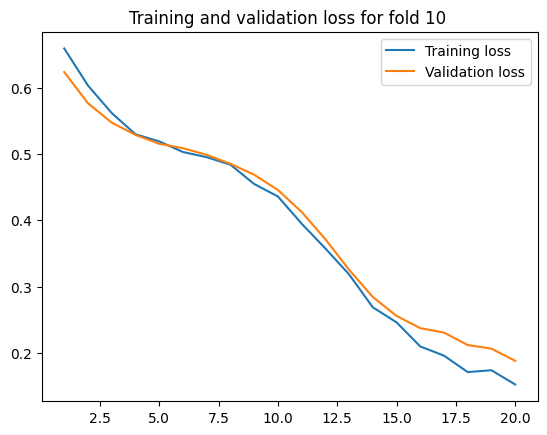

10/10 [==============================] - 1s 73ms/step
===== : TRAIN for fold 11 : =====
2/2 [==============================] - 0s 20ms/step
===== : TEST for fold 11 : =====


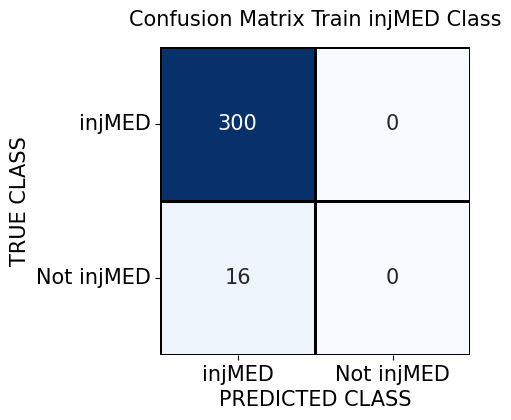

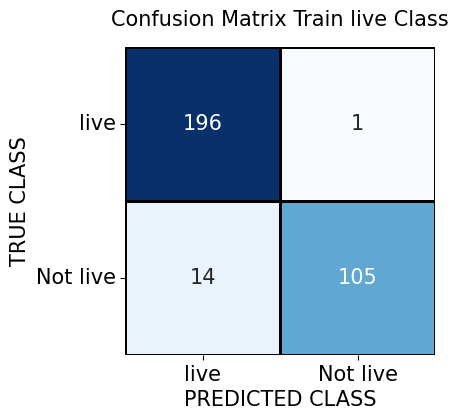

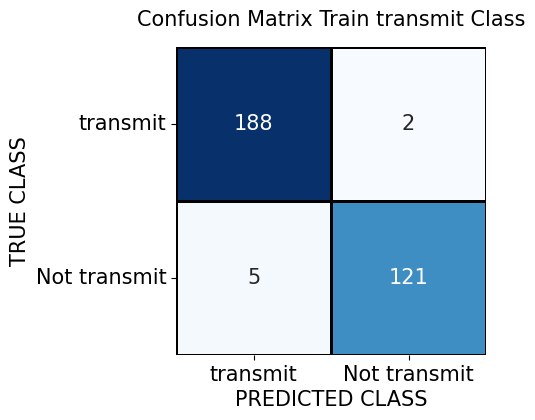

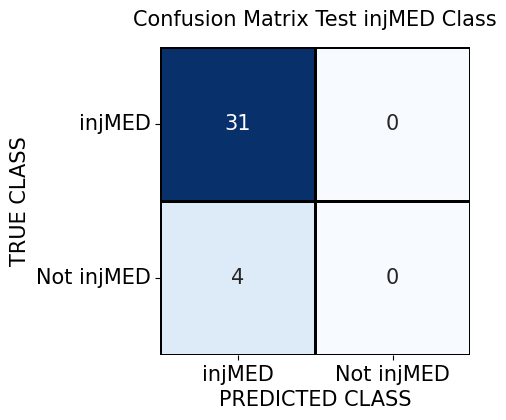

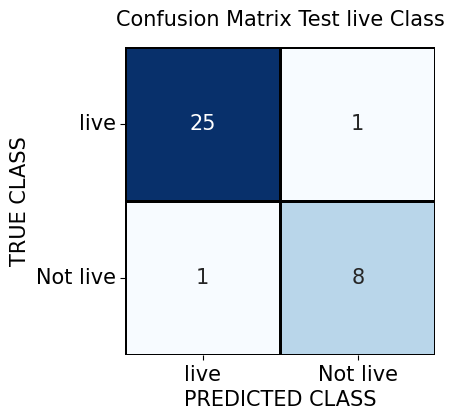

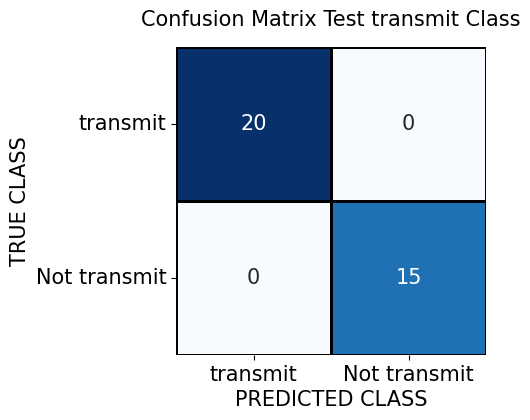

In [51]:
#LSTM with GLOVE by k-fold for needed classification
# K-fold Cross Validation model evaluation
embd_index={}
f=open("glove.6B.100d.txt",encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embd_index[word]=coefs
f.close()

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(text_new_lemma)
sequence=tokenizer_obj.texts_to_sequences(text_new_lemma)
word_index=tokenizer_obj.word_index
max_len=max([len(s) for s in text_new_lemma])
review_pad=pad_sequences(sequence,maxlen=max_len)
num_words=len(word_index)+1
EmbeddingDIM=100
emb_matrix=np.zeros((num_words,EmbeddingDIM))
for word,i in word_index.items():
    if i>num_words:
        continue
    emb_vector=embd_index.get(word)
    if emb_vector is not None:
        emb_matrix[i]=emb_vector

kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
acc=[]
val_acc=[]
loss=[]
val_loss=[]
recallTrain=[]
recallTest=[]
precTrain=[]
precTest=[]

recallClassTrain=[]
recallClassTest=[]
precClassTrain=[]
precClassTest=[]

for train, test in kfold.split(review_pad, y2):
    model=Sequential()
    embd_layer=Embedding(num_words, EmbeddingDIM, embeddings_initializer=Constant(emb_matrix),input_length=max_len)
    model.add(embd_layer)
    model.add(Bidirectional(LSTM(units=10,dropout=0.1,recurrent_dropout=0.1)))
    optimizer = keras.optimizers.Adam(lr=0.001)
    #optimizer =keras.optimizers.SGD(lr=0.1)
    #optimizer =keras.optimizers.RMSprop(lr=0.8)
    model.add(Dense(10, activation = "relu")) #denselayer_2
    model.add(Dropout(0.1)) #dropout_3
    model.add(Flatten())
    model.add(Dense(3, activation = 'sigmoid')) #classification_layer
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Generate a print
    print('-----------------LSTM with GLOVE-------------------------------')
    print(f'Training for fold {fold_no} ...')
    history =model.fit(review_pad[train], y2[train],
              validation_data= (review_pad[test], y2[test]),
              epochs= 20,verbose=1)

    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    epochs = range(1, 20 + 1)

    plt.figure()
    plt.plot(epochs, acc[-1], label='Training acc')
    plt.plot(epochs, val_acc[-1], label='Validation acc')
    plt.title(f'Training and validation accuracy for fold {fold_no} ')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, loss[-1], label='Training loss')
    plt.plot(epochs, val_loss[-1], label='Validation loss')
    plt.title(f'Training and validation loss for fold {fold_no} ')
    plt.legend()

    plt.show()
    # Increase fold number
    fold_no = fold_no + 1
    p_tr = (model.predict(review_pad[train])>0.5).astype("int32")
    print(f"===== : TRAIN for fold {fold_no} : =====")
    #mymetrics(y1[train],p_tr,f"Train LSTM with GLOVE for fold {fold_no}")
    #show_confusion_ROC(y2[train],p_tr,f'Train LSTM with GLOVE for fold {fold_no}')
    p_te = (model.predict(review_pad[test])>0.5).astype("int32")
    cm=multilabel_confusion_matrix(y2[train],p_tr)
    for j in range(3):
      plot_confusion_matrix(confusion_matrix=cm[j,:,:], class_names=[class_labels[j],'Not '+class_labels[j]],nm='Train '+class_labels[j], errors_only=False, fontsize=15)
    print(f"===== : TEST for fold {fold_no} : =====")
    #mymetrics(y1[test],p_te,f'Test LSTM with GLOVE for fold {fold_no}')
    #show_confusion_ROC(y2[test],p_te,f'Test LSTM with GLOVE for fold {fold_no}')
    cm=multilabel_confusion_matrix(y2[test],p_te)
    for j in range(3):
      plot_confusion_matrix(confusion_matrix=cm[j,:,:],class_names=[class_labels[j],'Not '+class_labels[j]],nm='Test '+class_labels[j], errors_only=False, fontsize=15)
    recallTrain.append(recall_score(y2[train],p_tr, average='macro'))
    precTrain.append(precision_score(y2[train],p_tr, average='macro'))
    recallTest.append(recall_score(y2[test],p_te, average='macro'))
    precTest.append(precision_score(y2[test],p_te, average='macro'))
    recallClassTrain.append(recall_score(y2[train],p_tr, average=None))
    precClassTrain.append(precision_score(y2[train],p_tr, average=None))
    recallClassTest.append(recall_score(y2[test],p_te, average=None))
    precClassTest.append(precision_score(y2[test],p_te, average=None))


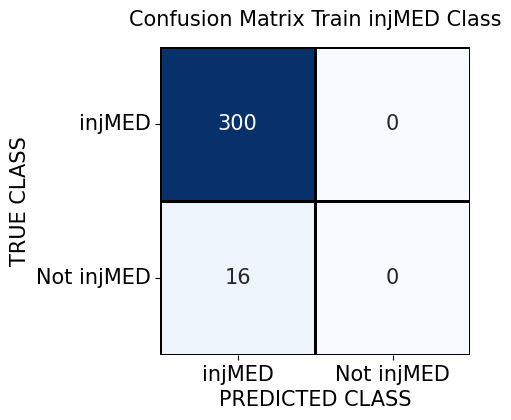

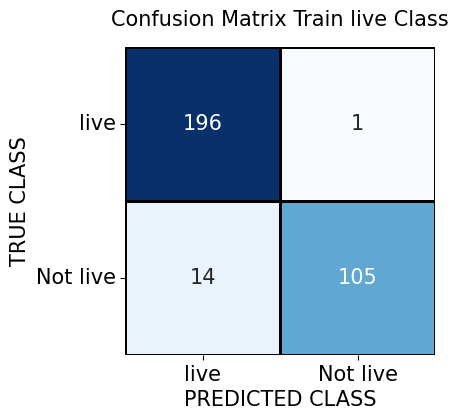

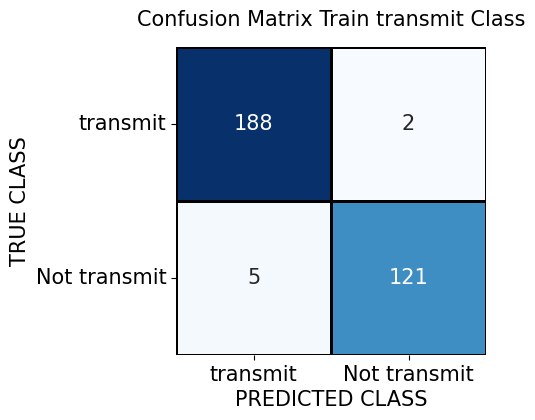

In [52]:
cm=multilabel_confusion_matrix(y2[train],p_tr)
for j in range(3):
  plot_confusion_matrix(confusion_matrix=cm[j,:,:], class_names=[class_labels[j],'Not '+class_labels[j]],nm='Train '+class_labels[j], errors_only=False, fontsize=15)

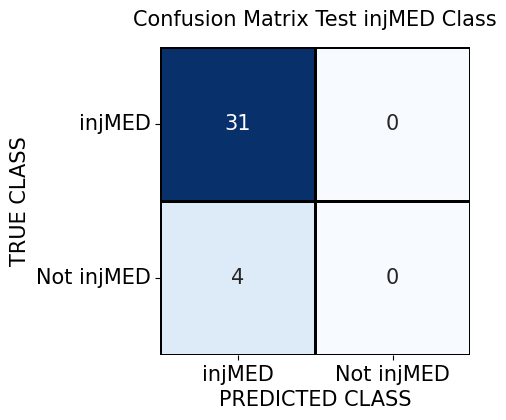

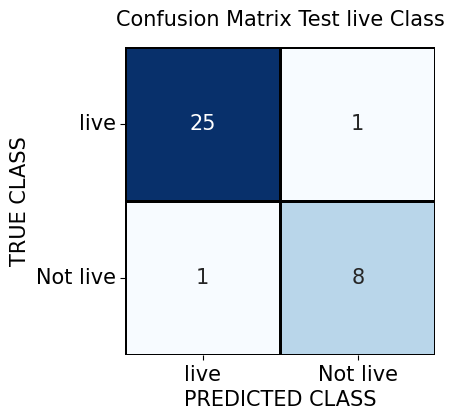

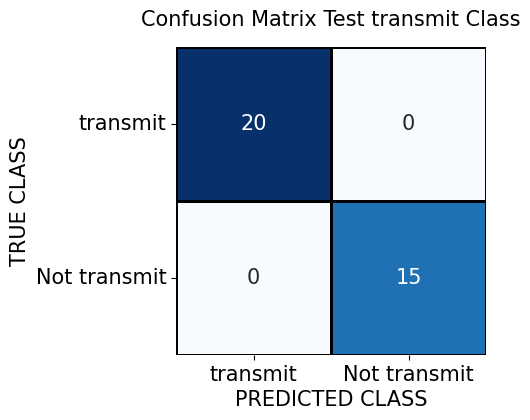

In [53]:
cm=multilabel_confusion_matrix(y2[test],p_te)
for j in range(3):
  plot_confusion_matrix(confusion_matrix=cm[j,:,:],class_names=[class_labels[j],'Not '+class_labels[j]],nm='Test '+class_labels[j], errors_only=False, fontsize=15)

In [77]:
print("TRAIN misclassed Tweet....")
treridx,trercl=np.where(y2[train]!=p_tr)
textarray=np.array(df2['text_Cleaned'])
for i,j in zip(train[treridx],treridx):
  print(f'real class={y2[i]} predicted={p_tr[j]} tweet: \n {textarray[i]}')


TRAIN misclassed Tweet....
real class=[1 0 0] predicted=[0 0 0] tweet: 
 ok flood fire mouse plague pandemic two year starting look bit biblical pharaoh still trying make people rich nobody know getting nobody actually taught proper history auspol
real class=[0 1 0] predicted=[0 0 0] tweet: 
 epearson today damage traralgon farmer face another flood everyone evacuating horrendous traralgon official second flood http
real class=[1 0 1] predicted=[0 0 1] tweet: 
 vicemergency government allowed life clear tree around house shed road etc dont build flood prone area house build footing called sand shoe flood area floodproof digging car park make car heavier still cheap plastic
real class=[0 1 1] predicted=[0 0 1] tweet: 
 minor flood warning issued mitchell river bairnsdale friday evening river peaking minor flood range see http
real class=[1 0 0] predicted=[0 0 0] tweet: 
 warning riverine flood thomson river cowwarr weir major flood warning issued thomson river cowwarr weir major floodin

In [78]:
print("Test misclassed Tweet....")
teeridx,teercl=np.where(y2[test]!=p_te)
for i,j in zip(test[teeridx],teeridx):
  print(f'real class={y2[i]} predicted={p_te[j]} tweet: \n {textarray[i]}')

Test misclassed Tweet....
real class=[0 1 1] predicted=[0 0 1] tweet: 
 wonthaggi request firm aid flood victim simply help
real class=[0 0 0] predicted=[0 1 0] tweet: 
 victoria flood emergency claimed second life woman whose body found state south west friend family paid tribute nina barake along brian gilliland car almost submerged gippsland
real class=[1 0 0] predicted=[0 0 0] tweet: 
 condolence go family affected flood tragedy gippsland flooding continues keep alert condition check http
real class=[1 0 1] predicted=[0 0 1] tweet: 
 moderate flood warning mitchell river bairnsdale info http
real class=[1 0 0] predicted=[0 0 0] tweet: 
 minor flood warning latrobe river downstream traralgon harrynytimes
real class=[1 0 0] predicted=[0 0 0] tweet: 
 vicemergency government allowed people clear tree around house shed road etc dont build flood prone area dont build flat house build footing use sand bag flood area floodproof underground car park make car heav


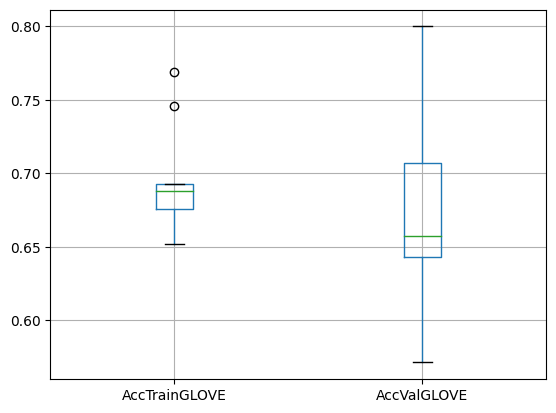

In [79]:
dfacc = pd.DataFrame(np.c_[np.array(acc)[:,-1],np.array(val_acc)[:,-1]],
                  columns=['AccTrainGLOVE', 'AccValGLOVE'])
dfloss = pd.DataFrame(np.c_[np.array(loss)[:,-1],np.array(val_loss)[:,-1]],
                  columns=['LossTrainGLOVE', 'LossValGLOVE'])
boxplotacc = dfacc.boxplot(column=['AccTrainGLOVE', 'AccValGLOVE'])

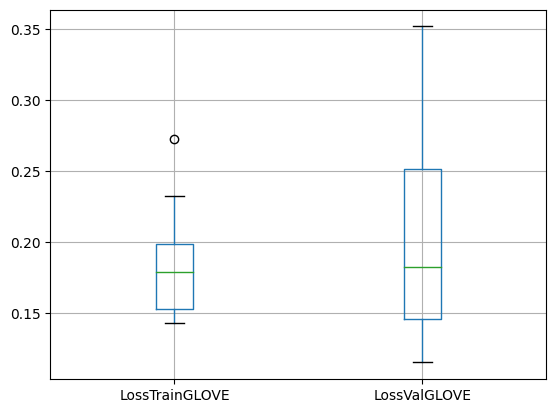

In [80]:
boxplotloss = dfloss.boxplot(column=['LossTrainGLOVE', 'LossValGLOVE'])

preciTrGLOVE     0.754233
preciValGLOVE    0.655926
dtype: float64

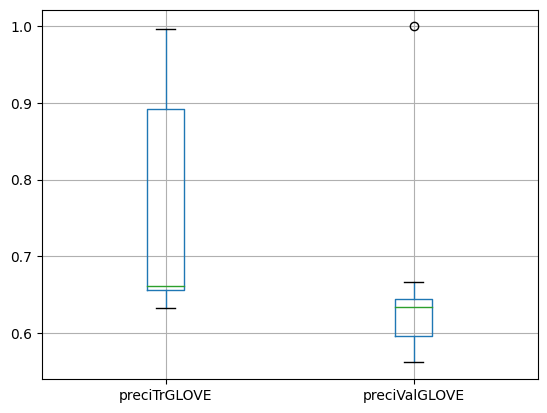

In [87]:
dfprec = pd.DataFrame(np.c_[np.array(precTrain),np.array(precTest)],
                  columns=['preciTrGLOVE', 'preciValGLOVE'])
dfrecall = pd.DataFrame(np.c_[np.array(recallTrain),np.array(recallTest)],
                  columns=['RecalTrGLOVE', 'RecalValGLOVE'])
boxplotprec = dfprec.boxplot(column=['preciTrGLOVE', 'preciValGLOVE'])


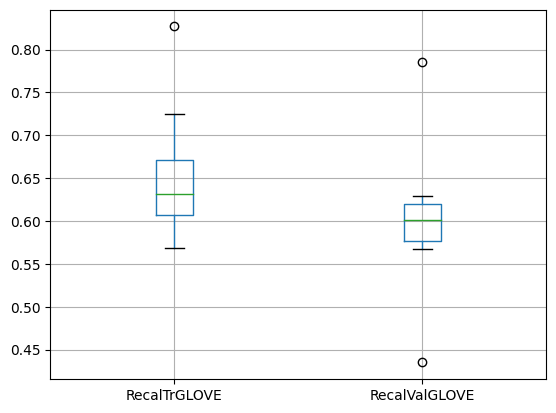

In [82]:
boxplotrecall = dfrecall.boxplot(column=['RecalTrGLOVE', 'RecalValGLOVE'])

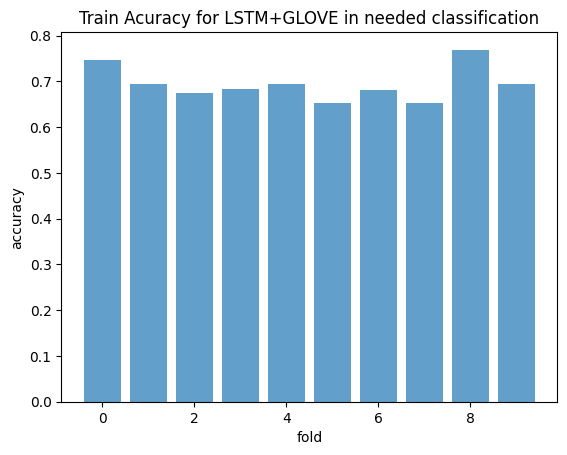

In [83]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(acc)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Train Acuracy for LSTM+GLOVE in needed classification')
plt.show()

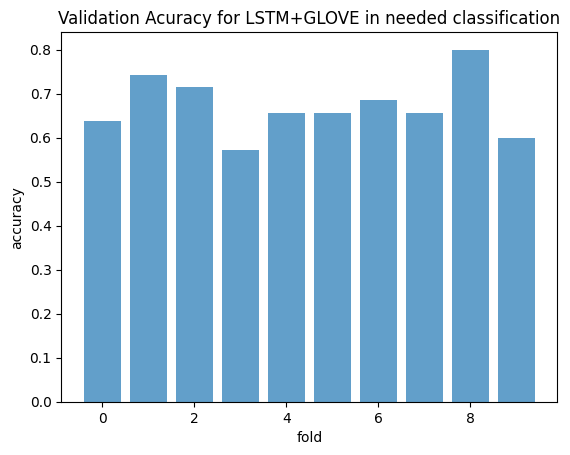

In [84]:
y_pos = np.arange(10)
plt.bar(y_pos, np.array(val_acc)[:,-1], align='center', alpha=0.7)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.title('Validation Acuracy for LSTM+GLOVE in needed classification')
plt.show()

In [85]:
data = {'injuredMedical':[recallClassTrain[-1][0], precClassTrain[-1][0]],
        'live':[recallClassTrain[-1][1],  precClassTrain[-1][1]],
        'transmit':[recallClassTrain[-1][2],  precClassTrain[-1][2]]}
df = pd.DataFrame(data, index =['Recall', 'Precision'])
print(df)

           injuredMedical      live  transmit
Recall                0.0  0.882353  0.960317
Precision             0.0  0.990566  0.983740


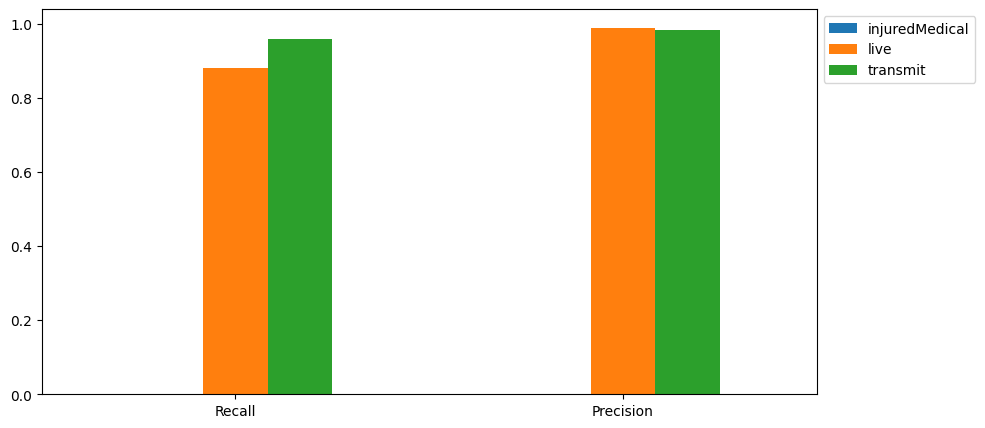

In [88]:
ax = df.plot.bar(rot=0,figsize=(10, 5))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [97]:
print("precision train and test:")
dfprec.mean().to_numpy()

precision train and test:


array([0.75423295, 0.65592639])

In [98]:
print("recall train and test:")
dfrecall.mean().to_numpy()

recall train and test:


array([0.65227095, 0.60108431])

In [99]:
Fscore = 2 * (dfprec.mean().to_numpy() * dfrecall.mean().to_numpy()) / (dfprec.mean().to_numpy()+ dfrecall.mean().to_numpy())
print("Fscore train and test:")
Fscore

Fscore train and test:


array([0.69955617, 0.62730899])